# Import packages

## List of packages
- `time`, datetime - ability to get current time for logs
- `math` - basic mathematical functions (as logarithm etc.))
- `random` - generate random selection from probability distributions
- `NumPy` - for scientific, mathematical, numerical calculations
- `Scipy` - for clustering and correlation calculations
- `Pandas` - for efficient work with large data structures (you need pandas **version 0.25.3**)
- `cx_Oracle` and sqlalchemy - for loading data from Oracle database (DWH etc.)
- `scikit`-learn - all important machine learning (and statistical) algorithms used for training the models
- `matplotlib` - for plotting the charts
- `seaborn` - for statistical visualisations
- `os` - for setting output paths for generated image files
- `pickle` - to save models to external files
- `tqdm` - intelligent progress bar (**version 4.40.0 or higher**)
- `tkinter` - for interactive Interactions tool GUI
- `xgboost` - gradient boosting used for feature selection before regression
- `lightgbm shap hyperopt` - faster implementations of gradient boosting
- `python-docx` - library for creating and updating Microsoft Word (.docx) files

**If any of these packages is missing, you have to install it from the Anaconda prompt using command *conda install packagename* where *packagename* is the name of the installed package.**

There is another package called *scoring*, which is distributed along with this workflow. **The folder *scoring* must be located in the same folder as this workflow for the package to be loaded correctly.** Alternatively, you can locate it somewhere else and then use *sys.path.insert()* to map this location.

## Other important prerequisites

For the grouping some **extensions for Jupyter must be installed and enabled before Jupyter is started and the notebook is loaded**. These extensions are Javascripts running in the browser, so it is necessary to have a compatibile browser. Generally, Chrome is OK, Internet Explorer 11 is NOT OK. To install the extensions, run this in your Anaconda prompt:

- `conda install ipywidgets`
- `jupyter nbextension enable --py --sys-prefix widgetsnbextension`
- `jupyter nbextension enable --py --sys-prefix qgrid`

To be able to connect to Oracle database (to get the data directly from your DWH) you need a compatibile Oracle driver to be installed on your computer. **With 64-bit Python, you need to have 64-bit Oracle driver installed.** Before you install the driver, you need to have Java 8 JDK (JRE is not enough) installed on your computer.

In [1]:
import time
import datetime
import operator
import math
import random
import numpy as np
import pandas as pd

# import cx_Oracle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import gc
import json
from tqdm.notebook import tqdm

import sys
sys.path.insert(1, 'C:/Users/insan.aprilian_molad/')
import scoring

import warnings
warnings.filterwarnings('ignore')

Set general technical parameters and paths.

In [2]:
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True
from IPython.display import display, Markdown, HTML
pd.options.display.max_columns = None
pd.options.display.max_rows = 15

psw_version = '0.9.0'
scoring.check_version(psw_version, list_versions=False)

# create the documentation folders 
output_folder = 'documentation_adscore_2_0'
subfolders = [
    "performance",
    "predictors",
    "stability",
    "stability_grouping",
    "stability_short",
    "analysis", 
    "model",
    "nan_share"
]

os.makedirs(output_folder, exist_ok=True)
    
for folder in subfolders:
    os.makedirs(os.path.join(output_folder, folder), exist_ok=True)

# Input data

## Import data
Importing data from a CSV file. It is important to set the following parameters:

encoding: usually 'utf-8' or windows-xxxx on Windows machines, where xxxx is 1250 for Central Europe, 1251 for Cyrilic etc.
sep: separator of columns in the file
decimal: decimal dot or coma
index_col: which columns is used as index - should be the unique credit case identifier

**Defining NA values:** In different datasets, there can be different values to be considered *N/A*. By default, we set only blank fields to be considered *N/A*, however you might want to change it and add values like *'NA'*, *'NAN'*, *'null'* to be also considered *N/A*. User parameter `na_values` for this.

In [3]:
# Load data
data = pd.read_csv('data_adscore_v2_target.csv',index_col='appid')
data.columns = [str(col).lower() for col in data.columns]
print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

Data loaded on 2024-01-25 09:30:39


In [4]:
data.head()

no_kontrak   ktp_no_customer      nama_customer  contact_phone  \
appid                                                                   
41747      1.9058  3275102107830003     DAVID MARGANDA            NaN   
41749      7.3258  3674030712940012  ADRIANUS YULIANTO  '085691800057   
41750      7.3255  3671040907670001            SUTARDI  '085213119039   
41752      1.9043  3173061807700006            TANAMAS  '081213086506   
41765      1.9044  1471090504830181      SYAHRUL DAMAR  '081212685860   

      bookingdate closetxndate jenis_loan skema_pembiayaan  fpd10_obs  \
appid                                                                   
41747  2023-01-27          NaN    Moladin      Refinancing          1   
41749  2022-12-28   2024-01-05    Moladin      Refinancing          1   
41750  2022-12-15   2023-06-20    Moladin      Refinancing          1   
41752  2022-12-16          NaN    Moladin      Refinancing          1   
41765  2022-12-21          NaN    Moladin      Refinancing          1   

       fpd30_obs  fspd10_obs  fspd30_obs  fstpd30_obs  fstqpd30_obs  \
appid                                                                 
41747          1           1           1            1             1   
41749          1           1           1            1             1   
41750          1           1           1            1             1   
41752          1           1           1            1             1   
41765          1           1           1            1             1   

       fpd10_cnt  fpd30_cnt  fspd10_cnt  fspd30_cnt  fstpd30_cnt  \
appid                                                              
41747          0          0           0           0            0   
41749          0          0           0           0            0   
41750          0          0           0           0            0   
41752          0          0           0           0            0   
41765          0          0           0           0            0   

       fstqpd30_cnt marital_status jenis_kelamin  usia  pencairan   cabang bm  \
appid                                                                           
41747             0        MARRIED     Laki-Laki  40.0   46200034  KALIMALANG   
41749             0         SINGLE     Laki-Laki  28.0   37889400     CIBUBUR   
41750             0  WIDOW/WIDOWER     Laki-Laki  55.0   60509550     CIBUBUR   
41752             0        MARRIED     Laki-Laki  52.0  241051757  KALIMALANG   
41765             0        MARRIED     Laki-Laki  40.0   57491000  KALIMALANG   

          brand  tahun_kendaraan job category               jobname  \
appid                                                                 
41747     VESPA           2022.0     KARYAWAN     ADMINISTRASI UMUM   
41749    DATSUN           2016.0     KARYAWAN     ADMINISTRASI UMUM   
41750    SUZUKI           2013.0     KARYAWAN  PEGAWAI PEMERINTAHAN   
41752     HONDA           2019.0   WIRASWASTA            WIRASWASTA   
41765  DAIHATSU           2015.0   WIRASWASTA            WIRASWASTA   

       usia_pasangan provisiononloan admonloan to_status kepemilikan_bpkb  \
appid                                                                       
41747           40.0           False     False    NON_TO          Sendiri   
41749            NaN           False     False    NON_TO       orang_lain   
41750            NaN           False     False    NON_TO       orang_lain   
41752           50.0           False     False    NON_TO       orang_lain   
41765           40.0           False     False    NON_TO          Sendiri   

      birthplace spousebirthplace        custkec           custcity  \
appid                                                                 
41747    JAKARTA           BEKASI  JATI SAMPURNA             BEKASI   
41749    JAKARTA              NaN    PONDOK AREN  TANGERANG SELATAN   
41750    JAKARTA              NaN          BENDA          TANGERANG   
41752      JAMBI     BANGKA BARAT      KALIDERE

In [5]:
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 2581
Number of columns: 44


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2581 entries, 41747 to 48610
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   no_kontrak        2581 non-null   float64
 1   ktp_no_customer   2581 non-null   object 
 2   nama_customer     2581 non-null   object 
 3   contact_phone     2553 non-null   object 
 4   bookingdate       2581 non-null   object 
 5   closetxndate      157 non-null    object 
 6   jenis_loan        2581 non-null   object 
 7   skema_pembiayaan  2581 non-null   object 
 8   fpd10_obs         2581 non-null   int64  
 9   fpd30_obs         2581 non-null   int64  
 10  fspd10_obs        2581 non-null   int64  
 11  fspd30_obs        2581 non-null   int64  
 12  fstpd30_obs       2581 non-null   int64  
 13  fstqpd30_obs      2581 non-null   int64  
 14  fpd10_cnt         2581 non-null   int64  
 15  fpd30_cnt         2581 non-null   int64  
 16  fspd10_cnt        2581 non-null   int

In [7]:
data['bookingdate'] = pd.to_datetime(data['bookingdate'],format="%Y-%m-%d")
start = datetime.datetime.strptime('2023-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime('2023-10-01 00:00:00', '%Y-%m-%d %H:%M:%S')
# data = data.loc[(data['bookingdate']>=start) & (data['bookingdate']<end)]
data = data.loc[(data['bookingdate']>=start)]

In [8]:
data.shape

(2558, 44)

In [9]:
data['pencairan'] = data['pencairan'].str.replace('Rp','')
data['pencairan'] = data['pencairan'].str.replace(',','')
data['pencairan'] = data['pencairan'].astype(float)

In [10]:
data['flag_same_city_domktp'] = np.where(data['custcity']==data['custcityhome'],'1','0')
data['flag_same_prov_domktp'] = np.where(data['custprov']==data['custprovhome'],'1','0')
data['flag_same_city_domush'] = np.where(data['custcityhome']==data['companycity'],'1','0')

In [11]:
data['flag_same_city_domush'].value_counts()

1    1763
0     795
Name: flag_same_city_domush, dtype: int64

## Metadata definitions
Assigning ID column, target column, time column and month column. The month column don't have to exist in the dataset, it will be created later in this workflow.

In [12]:
### THESE COLUMNS MUST BE INCLUDED IN THE DATA SET ###
#name of the target columnxxxx
col_target = "fspd30_cnt"
#name of the time column
col_time = "bookingdate"
col_id = "appid"

### THESE COLUMNS DON'T HAVE TO BE INCLUDED IN THE DATA SET AND ARE CREATED AUTOMATICALLY LATER ###
#name of the base column
col_base = "fspd30_obs"
#name of the month column
col_month = "MONTH"
#name of the day column
col_day = "DAY"
#name of the weight column - CURRENTLY COMMENTED OUT BECAUSE OF REASONS MENTIONED LATER
col_weight = 'WEIGHT'
#name of the reject column - only use if exists in your data, used for reject inference analysis
col_reject = 'REJECTED'

Inicialize doctools object for documentation generation.

In [13]:
from scoring import doctools

documentation = doctools.ProjectParameters()

Set a list of targets with their respective bases, time variable and rowid variable for plotting.

In [14]:
documentation.targets = [(col_target, col_base)]
documentation.time_variable = col_month
documentation.rowid_variable = col_id
documentation.weight = col_weight

In [15]:
data[col_target] = data[col_target].astype(np.float)

If you don't have base column in your data set, the following code adds it (based on if target is filled).

In [16]:
if col_base not in data:
    data[col_base] = 0
    data.loc[data[col_target] == 0, col_base] = 1
    data.loc[data[col_target] == 1, col_base] = 1
    print("Column", col_base, "added/modified. Number of columns:", data.shape[1])
else:
    print("Column", col_base, "already exists.")

Column fspd30_obs already exists.


If you don't have weight column in your data set, the following code adds it, with value = 1 for each row. **The weights are currently supported by Data Exploration, Interactive Grouping and Model Selection (L1 regression and Stepwise) classes, but not by all functions in the workflow. This is why they are commented out now (can be uncommented by the user).**

In [17]:
if col_weight not in data:
    data[col_weight] = 1
    print('Column',col_weight,'added/modified. Number of columns:',data.shape[1])
else:
    print('Column',col_weight,'already exists.')

Column WEIGHT added/modified. Number of columns: 48


Create the month and day column from the time column is doing the following
- take the time column and tell in which format the time is saved in - **you need to specify this in variable *dtime_input_format*** (see https://docs.python.org/3/library/time.html#time.strftime for reference)
- strip the format just to year, month, day string
- convert the string to number
- the new column will be added to the dataset as day
- truncate this column to just year and month and add it to dataset as month

In [18]:
dtime_input_format = "%Y-%m-%d %H:%M:%S"

In [19]:
data[col_day] = pd.to_numeric(pd.to_datetime(data[col_time], format=dtime_input_format, cache=False).dt.strftime("%Y%m%d"))
data[col_month] = data[col_day].apply(lambda x: math.trunc(x / 100))
print("Columns", col_day, "and", col_month, "added/modified. Number of columns:", data.shape[1])

Columns DAY and MONTH added/modified. Number of columns: 50


In [20]:
data.head(5)

no_kontrak   ktp_no_customer      nama_customer  contact_phone  \
appid                                                                   
41889     1.90690  1803152405980001       DIKA SAPUTRA  '085215167585   
41911     6.12845  3201054605750003  IMELDA IRENE HIMA  '089675989947   
41919     1.90610  3328164110830003       SITI PATONAH  '085889649863   
41922     1.90600  3172032309930005      INDRA CAHYADI  '081298307869   
41927     7.32680  3205312702900001          ALI SOBUR  '082311640256   

      bookingdate closetxndate jenis_loan skema_pembiayaan  fpd10_obs  \
appid                                                                   
41889  2023-03-17          NaN    Moladin      Refinancing          1   
41911  2023-02-01          NaN    Moladin      Refinancing          1   
41919  2023-02-07   2023-08-24    Moladin      Refinancing          1   
41922  2023-02-06          NaN    Moladin      Refinancing          1   
41927  2023-02-01          NaN    Moladin      Refinancing          1   

       fpd30_obs  fspd10_obs  fspd30_obs  fstpd30_obs  fstqpd30_obs  \
appid                                                                 
41889          1           1           1            1             1   
41911          1           1           1            1             1   
41919          1           1           1            1             1   
41922          1           1           1            1             1   
41927          1           1           1            1             1   

       fpd10_cnt  fpd30_cnt  fspd10_cnt  fspd30_cnt  fstpd30_cnt  \
appid                                                              
41889          0          0           0         0.0            0   
41911          1          0           1         0.0            0   
41919          1          1           1         1.0            1   
41922          0          0           0         0.0            0   
41927          0          0           0         0.0            0   

       fstqpd30_cnt marital_status jenis_kelamin  usia    pencairan  \
appid                                                                 
41889             0        MARRIED     Laki-Laki  25.0  354147275.0   
41911             1        MARRIED     Perempuan  48.0   25022300.0   
41919             1        MARRIED     Perempuan  39.0  120433680.0   
41922             0         SINGLE     Laki-Laki  29.0   60008880.0   
41927             0        MARRIED     Laki-Laki  33.0   80438749.0   

        cabang bm     brand  tahun_kendaraan job category            jobname  \
appid                                                                          
41889  KALIMALANG    TOYOTA           2022.0   WIRASWASTA         WIRASWASTA   
41911       BOGOR  DAIHATSU           2017.0   WIRASWASTA         WIRASWASTA   
41919  KALIMALANG     HONDA           2015.0   WIRASWASTA         WIRASWASTA   
41922  KALIMALANG    TOYOTA           2014.0     KARYAWAN  AKUNTING/KEUANGAN   
41927     CIBUBUR  DAIHATSU           2017.0     KARYAWAN  ADMINISTRASI UMUM   

       usia_pasangan provisiononloan admonloan to_status kepemilikan_bpkb  \
appid                                                                       
41889           23.0           False     False    NON_TO          Sendiri   
41911           48.0           False     False    NON_TO          Sendiri   
41919            NaN           False     False        TO       orang_lain   
41922            NaN           False     False    NON_TO       orang_lain   
41927           36.0           False     False    NON_TO          Sendiri   

                birthplace spousebirthplace         custkec       custcity  \
appid                                                                        
41889  TULANG BAWANG BARAT          LAMPUNG    BEKASI BARAT         BEKASI   
41911              JAKARTA          JAKARTA  BABAKAN MADANG          BOGOR   
41919                TEGAL            TEGAL        SURADADI          TEGAL   
41922              

In [21]:
list(data.columns)

['no_kontrak',
 'ktp_no_customer',
 'nama_customer',
 'contact_phone',
 'bookingdate',
 'closetxndate',
 'jenis_loan',
 'skema_pembiayaan',
 'fpd10_obs',
 'fpd30_obs',
 'fspd10_obs',
 'fspd30_obs',
 'fstpd30_obs',
 'fstqpd30_obs',
 'fpd10_cnt',
 'fpd30_cnt',
 'fspd10_cnt',
 'fspd30_cnt',
 'fstpd30_cnt',
 'fstqpd30_cnt',
 'marital_status',
 'jenis_kelamin',
 'usia',
 'pencairan',
 'cabang bm',
 'brand',
 'tahun_kendaraan',
 'job category',
 'jobname',
 'usia_pasangan',
 'provisiononloan',
 'admonloan',
 'to_status',
 'kepemilikan_bpkb',
 'birthplace',
 'spousebirthplace',
 'custkec',
 'custcity',
 'custprov',
 'custkechome',
 'custcityhome',
 'custprovhome',
 'companykec',
 'companycity',
 'flag_same_city_domktp',
 'flag_same_prov_domktp',
 'flag_same_city_domush',
 'WEIGHT',
 'DAY',
 'MONTH']

Load the predictors list from a csv file. The csv should have just one column, without any header, containing the name of the variables that should be used as predictors.

Support for boolean predictors in **not** currently implemented. Convert boolean predictors to object to use them.

`s = s.apply(lambda value: str(value) if not np.isnan(value) else value).astype('object')`

In [22]:
from scoring.data_manipulation import split_predictors_bytype

cols_pred = [
    'marital_status'
    ,'jenis_kelamin'
    ,'usia'
    ,'pencairan'
    ,'cabang bm'
    ,'brand'
    ,'tahun_kendaraan'
    ,'job category'
    ,'jobname'
    ,'usia_pasangan'
    ,'provisiononloan'
    ,'admonloan'
    ,'to_status'
    ,'kepemilikan_bpkb'
    ,'birthplace'
    ,'spousebirthplace'
    ,'custkec'
    ,'custcity'
    ,'custprov'
    ,'custkechome'
    ,'custcityhome'
    ,'custprovhome'
    ,'companykec'
    ,'companycity'
]
# cols_pred = ['avg_pf_otherconsumercredit_avgcp_24m', 'days_since_nbfi_inquiry',
#             'days_since_delinquencydate', 'avg_cnt_cal_dok_24m',
#             'r_cnt_pf_otherconsumercredit_contr_24m', 'days_since_disbursementdate_bigbank',
#             'min_tenor_12m', 'cnt_csc_settled_24m', 'max_worstpastdueamount_nbf1_12m',
#             'max_mob', 'cnt_nbfi_mdc_6m', 'days_since_delinquencydate_wco',
#             'avg_pf_workingcapitalother_maxoa_24m', 'cnt_nbfi_pf_24m',
#             'avg_pf_otherconsumercredit_maxpa_6m']

cols_pred, cols_pred_num, cols_pred_cat = split_predictors_bytype(data,
                                                                  pred_list=cols_pred,
                                                                  non_pred_list= [],
                                                                  optimize_types=True,
                                                                  convert_bool2int=True)

List of numerical predictors: [4]

usia                                float64
pencairan                           float64
tahun_kendaraan                     float64
usia_pasangan                       float64

List of categorical predictors: [20]

marital_status                      category
jenis_kelamin                       category
cabang bm                           category
brand                               category
job category                        category
jobname                             category
provisiononloan                     category
admonloan                           category
to_status                           category
kepemilikan_bpkb                    category
birthplace                          category
spousebirthplace                    category
custkec                             category
custcity                            category
custprov                            category
custkechome                         category
custcityhome                  

In [23]:
for col in cols_pred_cat:
    data[col] = data[col].astype(str)

In [24]:
from scoring.data_manipulation import split_predictors_bytype

cols_pred = [
    'marital_status'
    ,'jenis_kelamin'
    ,'usia'
    ,'pencairan'
    ,'cabang bm'
    ,'brand'
    ,'tahun_kendaraan'
    ,'job category'
    ,'jobname'
    ,'usia_pasangan'
    ,'provisiononloan'
    ,'admonloan'
    ,'to_status'
    ,'kepemilikan_bpkb'
#     ,'birthplace'
#     ,'spousebirthplace'
#     ,'custkec'
#     ,'custcity'
    ,'custprov'
#     ,'custkechome'
#     ,'custcityhome'
    ,'custprovhome'
#     ,'companykec'
#     ,'companycity'
    ,'flag_same_city_domktp'
    ,'flag_same_prov_domktp'
    ,'flag_same_city_domush'
]

# cols_pred = ['avg_pf_otherconsumercredit_avgcp_24m', 'days_since_nbfi_inquiry',
#             'days_since_delinquencydate', 'avg_cnt_cal_dok_24m',
#             'r_cnt_pf_otherconsumercredit_contr_24m', 'days_since_disbursementdate_bigbank',
#             'min_tenor_12m', 'cnt_csc_settled_24m', 'max_worstpastdueamount_nbf1_12m',
#             'max_mob', 'cnt_nbfi_mdc_6m', 'days_since_delinquencydate_wco',
#             'avg_pf_workingcapitalother_maxoa_24m', 'cnt_nbfi_pf_24m',
#             'avg_pf_otherconsumercredit_maxpa_6m']

cols_pred, cols_pred_num, cols_pred_cat = split_predictors_bytype(data,
                                                                  pred_list=cols_pred,
                                                                  non_pred_list= [],
                                                                  optimize_types=True,
                                                                  convert_bool2int=True)

List of numerical predictors: [4]

usia                                float64
pencairan                           float64
tahun_kendaraan                     float64
usia_pasangan                       float64

List of categorical predictors: [15]

marital_status                      category
jenis_kelamin                       category
cabang bm                           category
brand                               category
job category                        category
jobname                             category
provisiononloan                     category
admonloan                           category
to_status                           category
kepemilikan_bpkb                    category
custprov                            category
custprovhome                        category
flag_same_city_domktp               category
flag_same_prov_domktp               category
flag_same_city_domush               category


**Please check if all predictors were categorized correctly.** 
`Category` dtype is now used for categorical columns for memory efficiency. This means it will not be editable as *string*. If you need to edit values of a categorical column convert it to *string* using this syntax:

`data['Column name'] = data['Column name'].astype(str)`

## Data exploration

In [132]:
list(data['marital_status'].unique())

['MARRIED', 'SINGLE', 'WIDOW/WIDOWER', 'OTHERS', 'nan']

In [25]:
descrip = data.describe(include="all").transpose()
pd.options.display.max_rows = 1000
display(descrip.fillna(""))
pd.options.display.max_rows = 15

count unique                  top  freq      first  \
no_kontrak             2558.0                                          NaT   
ktp_no_customer        2558.0   2434     3319036101810007     9        NaT   
nama_customer          2558.0   2372   MONICA ANANDA SARI     9        NaT   
contact_phone          2533.0   2403        '082138163929     9        NaT   
bookingdate            2558.0    230  2023-11-30 00:00:00    31 2023-02-01   
closetxndate            148.0     77           2023-12-29    20        NaT   
jenis_loan             2558.0      4              Moladin  1620        NaT   
skema_pembiayaan       2558.0      2          Refinancing  2322        NaT   
fpd10_obs              2558.0                                          NaT   
fpd30_obs              2558.0                                          NaT   
fspd10_obs             2558.0                                          NaT   
fspd30_obs             2558.0                                          NaT   
fstpd30_obs            2558.0                                          NaT   
fstqpd30_obs           2558.0                                          NaT   
fpd10_cnt              2558.0                                          NaT   
fpd30_cnt              2558.0                                          NaT   
fspd10_cnt             2558.0                                          NaT   
fspd30_cnt             2558.0                                          NaT   
fstpd30_cnt            2558.0                                          NaT   
fstqpd30_cnt           2558.0                                          NaT   
marital_status         2558.0      5              MARRIED  1869        NaT   
jenis_kelamin          2558.0      3            Laki-Laki  1642        NaT   
usia                   2426.0                                          NaT   
pencairan              2444.0                                          NaT   
cabang bm              2558.0     33                  nan   186        NaT   
brand                  2558.0     25               TOYOTA   764        NaT   
tahun_kendaraan        2444.0                                          NaT   
job category           2558.0      5           WIRASWASTA  1620        NaT   
jobname                2558.0     19           WIRASWASTA  1600        NaT   
usia_pasangan          1282.0                                          NaT   
provisiononloan        2558.0      3                False  2138        NaT   
admonloan              2558.0      3                False  2154        NaT   
to_status              2558.0      3               NON_TO  1681        NaT   
kepemilikan_bpkb       2558.0      4           orang_lain  1163        NaT   
birthplace             2558.0    407              JAKARTA   256        NaT   
spousebirthplace       2558.0    406                  nan   566        NaT   
custkec                2558.0   1085               CAKUNG    14        NaT   
custcity               2558.0    257               BEKASI   127        NaT   
custprov               2558.0     25           JAWA BARAT   582        NaT   
custkechome            2558.0   1042                  nan    16        NaT   
custcityhome           2558.0    240               BEKASI   140        NaT   
custprovhome           2558.0     21           JAWA BARAT   621        NaT   
companykec             2558.0    979                  nan   434        NaT   
companycity            2558.0    189                  nan   256        NaT   
flag_same_city_domktp  2558.0      2                    1  2306        NaT   
flag_same_prov_domktp  2558.0      2                    1  2424        NaT   
flag_same_city_domush  2558.0      2                    1  1763        NaT   
WEIGHT                 2558.0                                          NaT   
DAY                    2558.0                                          NaT   
MONTH                  2558.0                                          NaT   

                            last             

**explore_numerical** and **explore_categorical** functions give graphical data exploratory analyses. They can also output into html files. You just need to specify the folder for output.

If you want the detailed legacy HTML output (v0.4.3) comment-out the cell below

These functions analyze only the part of data where target is not null even if it is not explicitly specified.

In [26]:
# from scoring.data_exploration import explore_categorical, explore_numerical, join_explorations

# explored_columns = list()
# for name, column in tqdm(data[cols_pred].iteritems(), total=len(cols_pred), leave=False):
#     if name in cols_pred_num[:]:
#         if (column.count() > 0) and (column.max() != column.min()):
#             explore_numerical(column, data[col_target], weightCol=None, htmlOut=True, ntbOut=False, 
#                               outFolder=os.path.join(output_folder,"predictors/exploration"))
#             explored_columns.append(name)
#     if name in cols_pred_cat[:]:
#         if (column.count() > 0) and (len(set(column.unique()) - {np.nan}) > 1):
#             explore_categorical(column, data[col_target], weightCol=None, htmlOut=True, ntbOut=False, 
#                                 outFolder=os.path.join(output_folder,"predictors/exploration"))
#             explored_columns.append(name)

# # comment out the line below if you didn't generate html files in this cell
# join_explorations(explored_columns, filename="_exploration.html", outFolder=os.path.join(output_folder,"predictors/exploration"), weighted=False)

**explore_df** function creates a simple text report about the important variable. The report can be then printed either to the screen or to a file.

In the following code, only such part of data that has col_base = 1 is analyzed. You can remove the condition if you wish.

In [27]:
from scoring.data_exploration import explore_df

st = explore_df(data[data[col_base] == 1], col_month, col_target, cols_pred)
print(st, file=open(os.path.join(output_folder,"predictors/data_exp.txt"), "w", encoding="utf-8"))
# print(st)

**Default rate in time**: Simple visualisation of observation count and default rate in time

In [28]:
observable_mask = data[col_base] == 1

In [29]:
documentation.sample_dict = {
    "Observable": observable_mask}

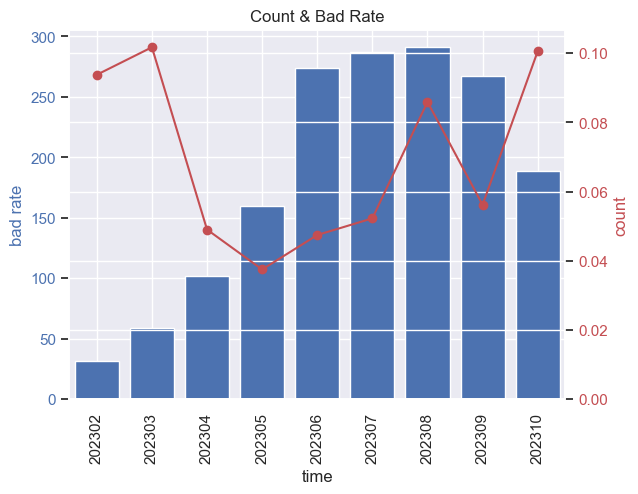

In [30]:
documentation.PlotDataset(
    data,
    sample="Observable",
    target=col_target,
#     segment_col="Categorical_5",
    output_folder=os.path.join(output_folder, 'analysis'),
    show_plot=True
)

In [31]:
jual_beli = (data['skema_pembiayaan']=="Jual Beli") 
refinancing = (data['skema_pembiayaan']=="Refinancing") 
dt = (data['jenis_loan']=="Moladin") 
ro = (data['jenis_loan']=="Organik") 

In [32]:
products = {'jual_beli':jual_beli,'refinancing':refinancing, 'DT':dt,'RO':ro}

jual_beli


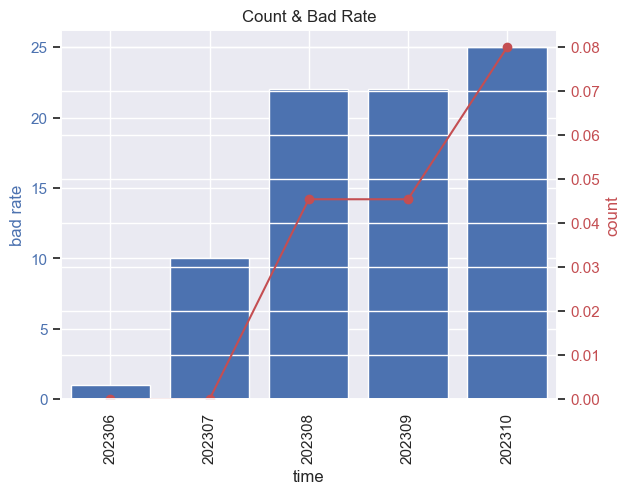

refinancing


DT


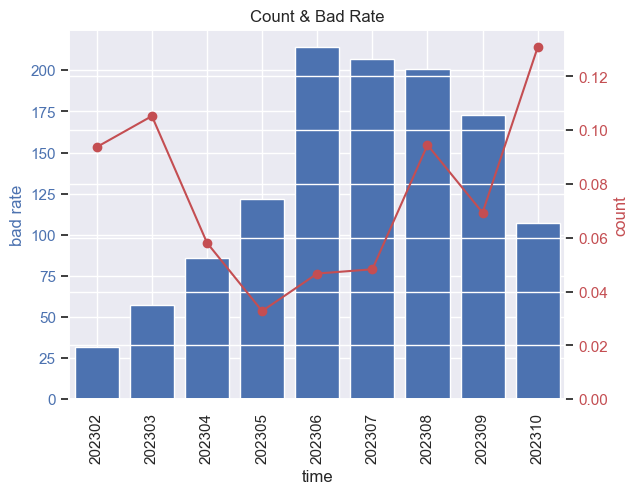

RO


In [33]:
from scoring.plot import plot_dataset
for name, product in products.items():
    print(name)
    documentation.PlotDataset(
        data[product],
        sample="Observable",
        target=col_target,
    #     segment_col="Categorical_5",
#         output_folder=os.path.join(output_folder, 'analysis'),
        show_plot=True
    )

**NaN share by month** for each variable in dataset:

In [34]:
# from scoring.data_exploration import nan_share_development

# pd.options.display.max_rows = 100

# nan_table = nan_share_development(
#     data[cols_pred+['pef_vec_1_1_score'] + [col_month]],
#     col_month,
#     make_images=True,
#     show_images=False,
#     output_path=output_folder + "/nan_share/",
# )
# display(nan_table.replace({0:""}))

## Data split

- Split data into five parts (in time training, in time validation, in time test, out of time, historical out of time)
- Adds a new column indicating to which part the observations belong
- The *splitting_points* (first date of train and first date of out of time sample) can be adjusted (there can be any number of such splitting points) - it should correspond to values of column specified by *time_column* parameter
- For each time split, you can create multiple random splits (i.e. train/valid/test), the ratio of sizes of these splits is set by parameter *sample_sizes*
- The random splits can be stratified by multiple variables, which are specified in a list - argument to *stratify_by_columns* parameter
- Set the random seed so the results are replicable

**Before you run data split, make sure that index in your dataset in unique!** If not, you need to create new unique index.

In [35]:
# #saving original index to a new column and resetting it
# data['INDEX_ORIGINAL'] = data.index
# data.reset_index(inplace=True)

In [36]:
from scoring.data_manipulation import data_sample_time_split

col_datatype = "data_type"

data[col_datatype] = data_sample_time_split(
    data,
    time_column=col_month,
    splitting_points=[202309],
    sample_sizes=[[0.6, 0.4], [1]],
    sample_names=[["train", "valid"], ["oot"]],
    stratify_by_columns=[col_month, col_target],
    random_seed=1234,
)

train   723 rows
valid   482 rows
oot     1,353 rows


Masks: boolean vectors corresponding to rows in the datasets. True if an row is observable and its data type belongs to given sample.

In [37]:
train_mask = (data[col_datatype] == "train") & (data[col_base] == 1)
valid_mask = (data[col_datatype] == "valid") & (data[col_base] == 1)
# test_mask = (data[col_datatype] == "test") & (data[col_base] == 1)
oot_mask = (data[col_datatype] == "oot") & (data[col_base] == 1)
# hoot_mask = (data[col_datatype] == "hoot") & (data[col_base] == 1)

In [38]:
documentation.sample_dict.update(
    {
#         "Historical Out of Time": hoot_mask,
        "Train": train_mask,
        "Validation": valid_mask,
#         "Test": test_mask,
        "Out of Time": oot_mask,
    }
)

Add masks to _documentation_ object.

Data summary (number of defaults, number in base, number of observations, default rate) by month and by sample

In [39]:
data_summary = data.groupby([col_month, col_datatype]).aggregate({col_target: "sum", col_base: ["sum", "count"]})
data_summary.columns = [col_target, col_base, "Rows"]
data_summary[col_target + " rate"] = data_summary[col_target] / data_summary[col_base]
display(data_summary)

data_summary = data_summary.reset_index(level=col_datatype).pivot(columns=col_datatype)
display(data_summary.round(3).fillna(""))
data_summary.to_csv(output_folder + "/analysis/summary.csv")

fspd30_cnt  fspd30_obs  Rows  fspd30_cnt rate
MONTH  data_type                                               
202302 train             2.0          19    19         0.105263
       valid             1.0          13    13         0.076923
202303 train             4.0          36    36         0.111111
       valid             2.0          23    23         0.086957
202304 train             3.0          61    61         0.049180
...                      ...         ...   ...              ...
202309 oot              15.0         267   267         0.056180
202310 oot              19.0         189   318         0.100529
202311 oot               2.0           0   301              inf
202312 oot               0.0           0   256              NaN
202401 oot               0.0           0   211              NaN

[19 rows x 4 columns]

fspd30_cnt             fspd30_obs                 Rows         \
data_type        oot train valid        oot  train  valid    oot  train   
MONTH                                                                     
202302                 2.0   1.0              19.0   13.0          19.0   
202303                 4.0   2.0              36.0   23.0          36.0   
202304                 3.0   2.0              61.0   41.0          61.0   
202305                 4.0   2.0              96.0   64.0          96.0   
202306                 8.0   5.0             164.0  110.0         164.0   
202307                 9.0   6.0             172.0  115.0         172.0   
202308                15.0  10.0             175.0  116.0         175.0   
202309          15.0                  267.0                267.0          
202310          19.0                  189.0                318.0          
202311           2.0                    0.0                301.0          
202312           0.0                    0.0                256.0          
202401           0.0                    0.0                211.0          

                 fspd30_cnt rate                
data_type  valid             oot  train  valid  
MONTH                                           
202302      13.0                  0.105  0.077  
202303      23.0                  0.111  0.087  
202304      41.0                  0.049  0.049  
202305      64.0                  0.042  0.031  
202306     110.0                  0.049  0.045  
202307     115.0                  0.052  0.052  
202308     116.0                  0.086  0.086  
202309                     0.056                
202310                     0.101                
202311                       inf                
202312                                          
202401

## Metadata export

Metadata from data preparation can be reused for example in gradient boosting workflow

In [40]:
metadata_export = {
        "col_time": col_time,
        "col_month": col_month,
        "col_day": col_day,
        "col_target": col_target,
        "col_base": col_base,
        "col_weight": col_weight,
        "col_reject": col_reject,
        "col_datatype": col_datatype,
        "col_id": col_id,
                  }

pd.DataFrame.from_dict(metadata_export, orient='index').to_csv(output_folder + "/model/metadata.csv", header=None)

# Derived variables

## Date differences

Function *datetime_difference()* takes name of dataset and names of two variables with datetime strings (the format of those strings can be also specified in parameters) and caluclates their difference in specified time units. We then append names of these difference columns to the list of numerical predictors.

First, **please cast your date variables as datetimes.**

In [41]:
# data["DateVariable_1"] = pd.to_datetime(data["DateVariable_1"])
# data["DateVariable_2"] = pd.to_datetime(data["DateVariable_2"], format="%Y-%m-%d %H:%M:%S")

It is handful to check for given variables whether they contain values over current date.  
This might indicate so-called **Y2K errors**. 
When date is in format such as 31/10/68, such date will get interpreted as 31st of October, 2068.

If you encounter such variables, there exist function `fix_y2k_errors`.  
You are advised to find the root issue of such dates, though.

In [42]:
# print(f"Maximal date in 'DateVariable_1' is {max(data['DateVariable_1'])}")
# print(f"Maximal date in 'DateVariable_2' is {max(data['DateVariable_2'])}")

# # from scoring.date_tools import fix_y2k_errors
# # data['DateVariable_1'] = fix_y2k_errors(data['DateVariable_1'], years=18)
# # data['DateVariable_2'] = fix_y2k_errors(data['DateVariable_2'], reference_date='2000-01-01')

When you are sure that everything is correct, you are free to proceed with calculating datetime differences.

In [43]:
# from scoring.date_tools import datetime_difference

# data["AGE"] = datetime_difference(pd.to_datetime(data[col_time]), data["DateVariable_1"], unit="years", rounding=None)
# data["NEW_TIME_VARIABLE"] = datetime_difference(
#     pd.to_datetime(data[col_time]), data["DateVariable_2"], unit="months", rounding="floor"
# )


# date_difference_predictors = ["AGE", "NEW_TIME_VARIABLE"]

# for predictor in date_difference_predictors:
#     if predictor not in cols_pred_num:
#         cols_pred_num.append(predictor)
#         cols_pred = cols_pred_num + cols_pred_cat
#         print(f"predictor {predictor} added to predictor list")

## Brute force interactions

**Finding interactions by brute force. Can work with a limitied number of predictors and/or small dataset only as it is testing each combination of any two predictors meaning its complexity is quadratic and can take very long time with more than lower tens of predictors if the dataset is large.**

The class has two testing methods to find out whether interaction of two variables makes sense. The method is specified in parameter `test_method`:

- *gini*: trains logistic regression model using the two variables and another model using their interaction as the only predictor. Then calculates Gini difference between the model with the interaction and the model using the two original predictors.
- *lr*: performs a likelihood ratio test between two logistic regression models: the richer model is using the two original predictors and their interaction, the simpler model just the two original variables. Calculates p-value of the test

Before this testing is performed, the variables are transformed to be compatible with the logistic regression, which is given by parameters `use_grouping` and `use_grouping_interactions`:

- if `use_grouping` is True, the two original predictors are first grouped and WOE transformed (parameters `groups_per_predictor` and `min_group_size` are taken into account).
- otherwise, the two original predictor are transformed using mean target encoding: numerical predictors are first grouped into `groups_per_predictor` quantiles and then mean target encoding with parameter `mean_target_regularization_weight` and logit transformation is applied. Categorical predictors are mean-target encoded without any pre-grouping, again with parameter `mean_target_regularization_weight`, and the logit transformation is applied.
- if `use_grouping_interactions` is True, interaction is calculated as cartesian product of the transformed original predictors, then each value of the cartesian product is mean target encoded with parameter `mean_target_regularization_weight` and then logit transformation is applied.
- otherwise, interaction is calculated as cartesian product of the transformed original predictors, then grouping and WOE transformation is applied (parameters `groups_per_predictor` and `min_group_size` are taken into account).

**As the result of the test, the pairs with highest Gini differences or lowest p-values should be considered as potential candidates for interaction creation.**

### Gini method

In [44]:
# from scoring.brute_force_interactions import BruteForceInteractions

In [45]:
# bfinter = BruteForceInteractions(
#         pred_num=cols_pred_num,
#         pred_cat=cols_pred_cat,
#         target=col_target,
#         base=col_base,
#         weight=col_weight,
#         test_method="gini",
#         use_grouping=False,
#         use_grouping_interactions=False,
#         groups_per_predictor=5,
#         min_group_size=100,
#         mean_target_regularization_weight=0.1,
#         grouping_category_limit=100,
#     )

# inter_tab_gini = bfinter.test_interactions(data[train_mask])

In [46]:
# display(inter_tab_gini)

## Export to Gradient Boosting Workflow

Transformed data can be reused for example in gradient boosting workflow.

You can add more columns to the `metadata_export` dictionary if you plan to use them in Gradient Boosting Workflow (e.g. multiple targets)

### Likelihood ratio method

In [47]:
# data.to_csv('data_prepared.csv')

In [48]:
# bfinter = BruteForceInteractions(
#         pred_num=cols_pred_num,
#         pred_cat=cols_pred_cat,
#         target=col_target,
#         base=col_base,
#         weight=col_weight,
#         test_method="lr",
#         use_grouping=False,
#         use_grouping_interactions=False,
#         groups_per_predictor=5,
#         min_group_size=100,
#         mean_target_regularization_weight=0.1,
#         grouping_category_limit=100,
#     )

# inter_tab_lr = bfinter.test_interactions(data[train_mask])

In [49]:
# display(inter_tab_lr)

In [50]:
# metadata_export["cols_pred_num"] = cols_pred_num
# metadata_export["cols_pred_cat"] = cols_pred_cat

# json.dump(metadata_export, open("metadata.json", "w", encoding="utf8"), indent=4)

# Grouping and WOE transformation of variables

Don't use such variables which have only 0 or 1 unique levels. Grouping doesn't work for them.

In [51]:
# cols_fill_na = ['avg_pf_mortgageabove70sqm_cnt_nsdelinquent_24m',
#                 'cnt_crt_banks_pd1_default_12m',
#                 'cnt_ct_creditcard_pns4_monitored_24m',
#                 'cnt_crt_banks_pd1_warning_12m',
#                 'cnt_crt_banks_pd2_warning_12m',
#                 'cnt_crt_banks_pd2_warning_24m',
#                 'cnt_crt_banks_pd3_warning_12m',
#                 'cnt_crt_banks_pd4_warning_12m',
#                 'cnt_crt_nbfi_pns4_substandard_12m',
#                 'cnt_ct_installment_pns4_substandard_24m',
#                 'cnt_pf_otherconsumercredit_pd1_warning_12m',
#                 'cnt_pf_otherconsumercredit_pd1_warning_24m',
#                 'cnt_pf_otherconsumercredit_pd2_warning_12m',
#                 'cnt_pf_workingcapitalother_pns4_monitored_24m']
# for col in cols_fill_na:
#     if col in data.columns:
#         data[col] = data[col].fillna(0, inplace=True)

In [52]:
cols_del = list()
for name, column in tqdm(data[train_mask][cols_pred].iteritems(), total=len(cols_pred)):
    if name in cols_pred_num:
        if column.value_counts(dropna=True).shape[0] < 2:
            cols_del.append(name)
            cols_pred_num.remove(name)
    if name in cols_pred_cat:
        if column.value_counts(dropna=True).shape[0] < 2:
            cols_del.append(name)
            cols_pred_cat.remove(name)
cols_pred = cols_pred_num + cols_pred_cat

if len(cols_del) > 0:
    print("Variables", cols_del, "will not be further used as they have only 1 unique level.")
else:
    print("All predictors have more than 1 unique level.")
del cols_del

  0%|          | 0/19 [00:00<?, ?it/s]

All predictors have more than 1 unique level.


In [53]:
# for name, column in tqdm(data[cols_pred_num].iteritems(), total=len(cols_pred_num), leave=False):
#     if np.any(np.isinf(column.values)):
#         print(f"{name} containes INF values. Please deal with them.")

# # data['predictor'].replace(to_replace=np.inf, value=<good idea>, inplace=True)

There are two options how to group your variables. 
1. Automatic grouping groups the variables using a decision tree. User can't change the grouping in any interactive way. The grouping can be saved into external file using its method *save()*. 
2. Interactive grouping is suitable for smaller numbers of variables. User can control which values of each varible will enter which group. The grouping can be saved into external file using the interactive environment.

## Stability grouping

Automatic binning with optimal stable Gini.
    Idea is to make most of the decisions pertaining to design of WOE bins all in one place 
    from point of view of performance and rank time-stability of the resulting bins.
    Aim is to significantly minimize the manual and time consuming interactive binning,
    while at the same time preserving compatibility with the interactive binning should
    that be still occasionally needed (e.g. for business reasons).

**ALGORITHM:**  
for each variable, for n_bins in range:
1. train a tree model (LGBM - see comment below) M, on training dataset, 
    with parameters `min_data_in_leaf = 5%` of training data length
    (this condition can be released for special variables (e.g. hardchecks) -
    in such case the `min_data_in_leaf` is set to 100). 
2. evaluate Gini of M on each time stamp of validation set (most frequently month):
    if we have `k` months, we have `k` ginis. Take average gini of those
    `k ginis --> Gini(n_bins)`
3. At the same time, calculate Elena's Rank Stability Index - RSI (version 1) 
    for target rate : the model M defines a certain grouping of variable
    (e.g. for `n_bins = 3` we have var partitioned into 3 bins) so calculate target rate
    in each bin across the time stamp and  get the RSI as usual. (The RSI for all bins
    is the average of RSI of each constituent bin.  The RSI of a constituent bin is 100%
    if the rank of its target rate relative to other bins's target rates remained 
    constant across all time stamps; otherwise, it decreases depending on how many
    times did the rank of the bin change).

In [54]:
# from scoring.stability_grouping import StableGrouping

# sgrouping = StableGrouping(
#     columns=cols_pred_num,
#     cat_columns=cols_pred_cat,
#     bin_stability_threshold=0.10,
#     max_leaves=10,
#     important_minorities=[],
#     must_have_variables=[],
#     min_data_in_leaf_for_minotirites=100,
#     min_data_in_leaf_share=0.05,
#     output_folder='documentation/stability_grouping/',
#     show_plots=False,
# )

# sgrouping.fit(
#     X_train=data[train_mask][cols_pred_num+cols_pred_cat],
#     X_valid=data[valid_mask][cols_pred_num+cols_pred_cat],
#     y_train=data[train_mask][col_target],
#     y_valid=data[valid_mask][col_target],
#     t_train=data[train_mask][col_month],
#     t_valid=data[valid_mask][col_month],
#     w_train=data[train_mask][col_weight],
#     w_valid=data[valid_mask][col_weight],
#     progress_bar=True,
# )

In [55]:
# sgrouping.save("stability_grouping.json")

## Automatic Grouping
The grouping uses decision tree algorithm and the grouping is supervised based on the target variable. In the following code:

A new instance of **Grouping** class is created. There are two important parameters:
 - *colums*: list of numerical columns to be grouped
 - *cat_columns*: list of categorical columns to be grouped
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In [56]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=3, 
                    min_samples=100, 
                    min_samples_cat=100)

In [57]:
grouping.fit(data[train_mask][cols_pred],
             data[train_mask][col_target],
            w=data[train_mask][col_weight],
            progress_bar=True, category_limit=100);

if len(grouping.bins_data_) > 0:
    for v,g in grouping.bins_data_.items():
        print('Variable:',v)
        print('Bins:',g['bins'])
        print('WOEs:',g['woes'])
        if v in cols_pred_num:
            print('nan WOE:',g['nan_woe'])
        if v in cols_pred_cat:
            print('WOE for unknown values:',g['unknown_woe'])
        print()

  0%|          | 0/19 [00:00<?, ?cols/s]

Variable: pencairan
Bins: [          -inf 8.47613680e+07 1.70016872e+08            inf]
WOEs: [ 0.42367138 -0.54663287  0.2945896 ]
nan WOE: 0.0

Variable: tahun_kendaraan
Bins: [  -inf 2012.5 2014.5    inf]
WOEs: [ 0.0243912   0.53488089 -0.13090223]
nan WOE: 0.0

Variable: usia
Bins: [-inf 37.5 42.5  inf]
WOEs: [-0.38850426 -0.09014294  0.48150728]
nan WOE: 4.2111431414356275

Variable: usia_pasangan
Bins: [-inf 37.5 46.5  inf]
WOEs: [-0.20705186  0.71214553  0.38435981]
nan WOE: -0.37915442514852193

Variable: admonloan
Bins: {'False': 0, 'True': 0, nan: 1}
WOEs: [0. 0.]
WOE for unknown values: 0

Variable: brand
Bins: {'DAIHATSU': 1, 'HONDA': 2, 'TOYOTA': 0, 'AUDI': 0, 'BMW': 0, 'CHEVROLET': 0, 'DATSUN': 0, 'FORD': 0, 'HINO': 0, 'HYUNDAI': 0, 'ISUZU': 0, 'KIA': 0, 'LEXUS': 0, 'MAZDA': 0, 'MERCEDES': 0, 'MINI': 0, 'MITSUBISHI': 0, 'NISSAN': 0, 'SERTIFIKAT TANAH&BANGUNAN': 0, 'SUZUKI': 0, 'VOLKSWAGEN': 0, 'WULING': 0, nan: 3}
WOEs: [ 0.23031976 -0.10096334 -0.54663287  0.        ]
WO

In [58]:
grouping.save("adscore_2_0_myGrouping.json")

'Grouping saved on 2024-01-25 09:30:45 to file adscore_2_0_myGrouping.json'

Load data from stability grouping.

In [59]:
# grouping.load("myGrouping.json")

In [60]:
# grouping.load(filename="stability_grouping.json")

## Interactive grouping

New Interactive grouping uses these arguments:
- *data*: training dataset the grouping should be based on
 - *target*: as the grouping is supervised and calculates WOE values, you need to specify the target column name
 - *time_column* time of each observation (usually month) used for stability charts  
 - *weight*: vector of weights of obervation (if not filled, grouping behaves as there are equal weights)

- **Chart section**:
 - For **numerical variables**, there is chart with equifrequncy fine classing (observations as bars, default rate as line), equidistant fine classing and the final groups.
 - For **categorical varibles** there is chart with each of the original categorical values and a chart with the final groups.
 - Stability of default rate and population in time. This uses _time_ column.
- **Variable section**: here you can choose tab with varible which you want to edit. 
 - For **numerical variables**, the tab contains of the borders of the final groups. You can edit these borders, add new with [+] button and remove them with [-] button. You can also manually set WOE for nulls. There is also a button to perform automatic grouping on the selected variable.
 - For **categorical variables**, the tab contains of two tables. In the top table, you can see some statistics for each of the categorical values. In the rightmost column, there is the number of group which is assigned to the category. You can edit this value (doubleclick on it) to change the grouping. In the bottom table you can see statistics for the groups. It is not editable. There is also a button to perform automatic grouping on the selected variable.
 
If this new version does not work for you, the old is still available in scoring library.

In [61]:
USE_INTERATIVE_GROUPING = False

In [62]:
if USE_INTERATIVE_GROUPING:
    from scoring.grouping import Grouping, InteractiveGrouping

    grouping = InteractiveGrouping(columns = sorted(cols_pred_num),
                                   cat_columns = sorted(cols_pred_cat),
                                   group_count=5,
                                   min_samples=100, 
                                   min_samples_cat=100,
                                   woe_smooth_coef=0.001)

In [63]:
if USE_INTERATIVE_GROUPING:
    sns.reset_orig()
    %matplotlib notebook
    %config InlineBackend.close_figures=False

    grouping.display(train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]],
                     #train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]+[col_weight]], #for call with weight
                     columns = sorted(cols_pred_num),
                     cat_columns = sorted(cols_pred_cat),
                     target_column = col_target,
                     #w_column = col_weight,
#                      filename = 'myIntGrouping.json',
                     bin_count=20,
                     woe_smooth_coef=0.001,
                     group_count=3,
                     min_samples=100,
                     min_samples_cat=100)

**Don't forget to *Apply and Save* your changes.**

(or save using save method in the next step):

In [64]:
#reset the graphical environment to be used by the normal non-interactive charts
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

In [65]:
# from scoring.grouping import Grouping
# grouping = Grouping(columns = sorted(cols_pred_num),
#                     cat_columns = sorted(cols_pred_cat),
#                     group_count=5, 
#                     min_samples=100, 
#                     min_samples_cat=100) 
# g_filename = 'myIntGrouping.json'
# grouping.load(g_filename)

Load the grouping from a file (don't forget to set the right filename) and add the WOE columns to the original dataset.

In [66]:
# grouping_plot_list = ['avg_pf_otherconsumercredit_avgcp_24m', 'days_since_nbfi_inquiry',
#                     'days_since_delinquencydate', 'avg_cnt_cal_dok_24m',
#                     'r_cnt_pf_otherconsumercredit_contr_24m', 'days_since_disbursementdate_bigbank',
#                     'min_tenor_12m', 'cnt_csc_settled_24m', 'max_worstpastdueamount_nbf1_12m',
#                     'max_mob', 'cnt_nbfi_mdc_6m', 'days_since_disbursementdate_occ',
#                     'cnt_pc_open_12m', 'max_outstandingamount_6m',
#                     'r_cnt_r_pf_12m_24m', 'avg_pf_otherconsumercredit_maxpa_6m']

***

### pencairan

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD  \
BIN_pencairan                                                                  
[-inf, 84761368.0)             363.0     15.0    0.0413    0.3333     0.5133   
[84761368.0, 170016872.0)      232.0     24.0    0.1034    0.5333     0.3068   
[170016872.0, inf)             128.0      6.0    0.0469    0.1334     0.1799   
nan                              0.0      0.0       NaN    0.0000     0.0000   

                              WOE  WOE_check   SHARE  
BIN_pencairan                                         
[-inf, 84761368.0)         0.4237     0.4316  0.5021  
[84761368.0, 170016872.0) -0.5466    -0.5530  0.3209  
[170016872.0, inf)         0.2946     0.2996  0.1770  
nan                           NaN    -2.7125  0.0000

IV: 0.2170
Gini: 23.50


***

### tahun_kendaraan

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD  \
BIN_tahun_kendaraan                                                      
[-inf, 2012.5)           148.0      9.0    0.0608    0.2000     0.2050   
[2012.5, 2014.5)         135.0      5.0    0.0370    0.1111     0.1917   
[2014.5, inf)            440.0     31.0    0.0705    0.6889     0.6032   
nan                        0.0      0.0       NaN    0.0000     0.0000   

                        WOE  WOE_check   SHARE  
BIN_tahun_kendaraan                             
[-inf, 2012.5)       0.0244     0.0247  0.2047  
[2012.5, 2014.5)     0.5349     0.5454  0.1867  
[2014.5, inf)       -0.1309    -0.1328  0.6086  
nan                     NaN    -2.7125  0.0000

IV: 0.0555
Gini: 10.12


***

### usia

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD     WOE  \
BIN_usia                                                                  
[-inf, 37.5)      268.0     24.0    0.0896    0.5333     0.3599 -0.3885   
[37.5, 42.5)      118.0      8.0    0.0678    0.1778     0.1622 -0.0901   
[42.5, inf)       333.0     13.0    0.0390    0.2889     0.4720  0.4815   
nan                 4.0      0.0    0.0000    0.0000     0.0059  4.2111   

              WOE_check   SHARE  
BIN_usia                         
[-inf, 37.5)    -0.3934  0.3707  
[37.5, 42.5)    -0.0915  0.1632  
[42.5, inf)      0.4908  0.4606  
nan              5.5818  0.0055

IV: 0.1923
Gini: 21.32


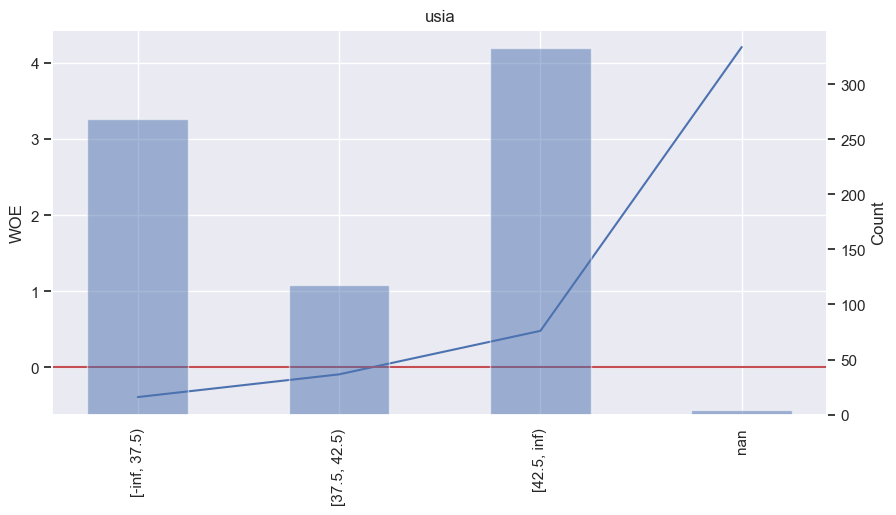

***

### usia_pasangan

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD     WOE  \
BIN_usia_pasangan                                                              
[-inf, 37.5)           185.0     14.0    0.0757    0.3111     0.2522 -0.2071   
[37.5, 46.5)           161.0      5.0    0.0311    0.1111     0.2301  0.7121   
[46.5, inf)            163.0      7.0    0.0429    0.1556     0.2301  0.3844   
nan                    214.0     19.0    0.0888    0.4222     0.2876 -0.3792   

                   WOE_check   SHARE  
BIN_usia_pasangan                     
[-inf, 37.5)         -0.2099  0.2559  
[37.5, 46.5)          0.7278  0.2227  
[46.5, inf)           0.3913  0.2254  
nan                  -0.3840  0.2960

IV: 0.1798
Gini: 22.07


In [67]:
grouping.plot_bins(data=data, cols_pred_num=cols_pred_num, cols_pred_cat=[],
                    mask=train_mask, col_target=col_target, output_folder=output_folder, col_weight=None)

## Apply the grouping to the dataset

### WOE transformation

Don't forget to apply the grouping to the data. *Grouping.transform()* method now automatically renames columns with proper suffix. If you need to transform just subset of columns use parameter *columns_to_transform=\[...\]*.

In [68]:
data_woe = grouping.transform(data, transform_to="woe", progress_bar=True)

  0%|          | 0/19 [00:00<?, ?cols/s]

### Dummy transformation

**Optional:** Transformation to dummy variables. Use if you want to use "full" regression instead of WOE regression

In [69]:
# data_dummy = grouping.transform(data, transform_to='dummy', progress_bar=True)

### Categorical variables transformation

**Optional:** Transformation to categorical variables. Name of categories instead of WOE values - not useful for modelling.

In [70]:
# data_shortnames = grouping.transform(data, transform_to='shortnames', progress_bar=True)

Plot the fitted WOEs.

In [71]:
# documentation.GroupingPlots(
#     data,
#     predictors=cols_pred,
#     sample="Train",
#     target=col_target,
#     grouping=grouping,
#     output_folder="documentation",
#     use_weight=True,
# )

## Add the transformed variables to the data set

### WOE variables

Add WOE variabes to the data set.

In [72]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in data:
        woe_columns_to_replace.append(column)
        print("Column", column, "dropped as it already existed in the data set.")
data = data.drop(woe_columns_to_replace, axis="columns")
data = data.join(data_woe)

del data_woe
gc.collect()

print("Added WOE variables. Number of columns:", data.shape[1])
cols_woe = [s + "_WOE" for s in cols_pred]

Added WOE variables. Number of columns: 70


### Dummy variables

**Optional.**

In [73]:
# dummy_columns_to_replace = list()
# for column in data_dummy.columns:
#     if column in data:
#         dummy_columns_to_replace.append(column)
#         print("Column", column, "dropped as it already existed in the data set.")
# data = data.drop(dummy_columns_to_replace, axis="columns")
# data = data.join(data_dummy)

# del data_dummy
# gc.collect()

# print("Added dummy variables. Number of columns:", data.shape[1])

#  Feature selection

First remove WOE variables with one WOE value only - they will have no predictive power.

In [74]:
cols_del = list()
for name, column in data[train_mask][cols_woe].iteritems():
    if (column.count() == 0) or (column.max() == column.min()):
        cols_del.append(name)
        cols_woe.remove(name)

if len(cols_del) > 0:
    print("Variables", cols_del, "will not be further used as they have only 1 unique WOE level.")
else:
    print("All predictors have more than 1 unique WOE level.")

Variables ['cabang bm_WOE', 'provisiononloan_WOE', 'admonloan_WOE', 'flag_same_city_domktp_WOE', 'flag_same_prov_domktp_WOE'] will not be further used as they have only 1 unique WOE level.


## Predictor power analysis

Calculates IV and Gini of each predictor, sorts the predictors by their power. The power is calculated for each of the samples (train, validate, test, OOT, H.OOT). **If one or more of the samples are empty, comment the according part of the code.**

In [75]:
from scoring.metrics import iv, gini, lift

power_tab = []
for j in range(0, len(cols_woe)):
    power_tab.append(
        {
            "Name": cols_woe[j],
            "IV Train": iv(
                data.loc[train_mask, col_target],
                data.loc[train_mask, cols_woe[j]],
            ),
            "Gini Train": gini(
                data.loc[train_mask, col_target],
                -data.loc[train_mask, cols_woe[j]],
                sample_weight = data.loc[train_mask, col_weight]
            ),
            "IV Validate": iv(
                data.loc[valid_mask, col_target],
                data.loc[valid_mask, cols_woe[j]],
            ),
            "Gini Validate": gini(
                data.loc[valid_mask, col_target],
                -data.loc[valid_mask, cols_woe[j]],
                sample_weight = data.loc[valid_mask, col_weight]
            ),
#             "IV Test": iv(
#                 data.loc[test_mask, col_target],
#                 data.loc[test_mask, cols_woe[j]],
#             ),
#             "Gini Test": gini(
#                 data.loc[test_mask, col_target],
#                 -data.loc[test_mask, cols_woe[j]],
#                 sample_weight = data.loc[test_mask, col_weight]
#             ),
            "IV OOT": iv(
                data.loc[oot_mask, col_target],
                data.loc[oot_mask, cols_woe[j]],
            ),
            "Gini OOT": gini(
                data.loc[oot_mask, col_target],
                -data.loc[oot_mask, cols_woe[j]],
                sample_weight = data.loc[oot_mask, col_weight]
            ),
#             "IV HOOT": iv(
#                 data.loc[hoot_mask, col_target],
#                 data.loc[hoot_mask, cols_woe[j]],
#             ),
#             "Gini HOOT": gini(
#                 data.loc[hoot_mask, col_target],
#                 -data.loc[hoot_mask, cols_woe[j]],
#                 sample_weight = data.loc[hoot_mask, col_weight]
#             ),
        }
    )
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index("Name")
power_out = power_out.sort_values("Gini Validate", ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(output_folder + "/predictors/covariates.csv")

IV Train  Gini Train  IV Validate  Gini Validate  \
Name                                                                          
pencairan_WOE              0.203923    0.235005     0.387025       0.150566   
tahun_kendaraan_WOE        0.038056    0.101213     0.066425       0.119021   
job category_WOE           0.047552    0.108161     0.047962       0.115639   
to_status_WOE              0.030374    0.076893     0.048307       0.100378   
jenis_kelamin_WOE          0.042695    0.105015     0.030058       0.093612   
brand_WOE                  0.110275    0.154310     0.072027       0.077879   
jobname_WOE                0.051692    0.113963     0.110719       0.069698   
usia_pasangan_WOE          0.152254    0.220747     0.023764       0.027376   
usia_WOE                   0.170324    0.213242     0.087864       0.024701   
marital_status_WOE         0.093997    0.138938     0.001744      -0.027533   
kepemilikan_bpkb_WOE       0.013528    0.058407     0.004581      -0.033984   
flag_same_city_domush_WOE  0.001776    0.011898     0.074681      -0.140340   
custprov_WOE               0.039574    0.093707     0.307112      -0.238279   
custprovhome_WOE           0.013091    0.059587     0.418113      -0.291378   

                             IV OOT  Gini OOT  
Name                                           
pencairan_WOE              0.120253  0.186298  
tahun_kendaraan_WOE        0.028844  0.090884  
job category_WOE           0.055590  0.118762  
to_status_WOE              0.001248  0.005576  
jenis_kelamin_WOE          0.015498 -0.049624  
brand_WOE                  0.034448 -0.037009  
jobname_WOE                0.186326  0.146362  
usia_pasangan_WOE          0.074988 -0.010036  
usia_WOE                   0.159073  0.183858  
marital_status_WOE         0.006621  0.012963  
kepemilikan_bpkb_WOE       0.015331 -0.065514  
flag_same_city_domush_WOE  0.003219 -0.036800  
custprov_WOE               0.011343 -0.012824  
custprovhome_WOE           0.012320 -0.019166

## Correlations

Show correlation matrix of all the WOE variables

In [76]:
# cols_corr = ['avg_pf_otherconsumercredit_avgcp_24m_WOE', 'days_since_nbfi_inquiry_WOE',
#                     'days_since_delinquencydate_WOE', 'avg_cnt_cal_dok_24m_WOE',
#                     'r_cnt_pf_otherconsumercredit_contr_24m_WOE', 'days_since_disbursementdate_bigbank_WOE',
#                     'min_tenor_12m_WOE', 'cnt_csc_settled_24m_WOE', 'max_worstpastdueamount_nbf1_12m_WOE',
#                     'max_mob_WOE', 'cnt_nbfi_mdc_6m_WOE', 'days_since_disbursementdate_occ_WOE',
#                     'cnt_pc_open_12m_WOE', 'max_outstandingamount_6m_WOE',
#                     'r_cnt_r_pf_12m_24m_WOE', 'avg_pf_otherconsumercredit_maxpa_6m_WOE']
# documentation.Correlations(
#     data,
#     predictors=cols_corr,
#     sample="All",
#     output_folder=output_folder + "/analysis/",
#     filename="correlation_full.png",
#     show_plot=True,
# )

## Hierarchical variable clustering.
- Starts with each variable as a separate cluster
- Creates clusters based on highest average correlations
- The stopping criterion is either parameter *max_cluster_correlation* - once no correlation between clusters is larger than this parameter, the clustering is finished; or *max_clusters* - when this many clusters are created, the clustering is finished. If both specified, the one that makes less clusters is used.

In [77]:
from scoring import variable_clustering

clustering_correlation = variable_clustering.CorrVarClus(
    max_correlation=0.5,
    # max_clusters=9,
    standardize=True,
    sample_size=50000,
)

clustering_correlation.fit(data[train_mask][cols_woe], data[train_mask][col_target])

Standardazing data...
Checking data for columns with zero variance...
Calculating Gini of variables...
Calculating order of variables in clusters...
Done! Use method draw() to visualise clusters, display() to display results in a table, bestVariables() to get list of the best variables from each cluster


Dendrogram (tree scheme of the hierarchical clustering)

In [78]:
# clustering_correlation.draw(output_file=output_folder + "/analysis/clustering_dendrogram.png")

Table of predictors with number of cluster they are in and order in their respective clusters ranked by gini.

In [79]:
# clustering_correlation.display(output_folder + "/predictors/predictor_clusters.csv")

Subset of WOE variables created that contains only the strongest (based on **training Gini**) variable of each cluster. It's up to the user to choose whether they want to used the full set (in this workflow by default) or such restricted set.

In [80]:
# print("Best variables based on correlation clustering:")
# clustering_correlation.bestVariables()

In [81]:
# len(clustering_correlation.bestVariables())

There are two other options for clustering in the scoring library:

 - Feature agglomeration (`variable_clustering.FeatureAggVarClus`) which is very similar to correlation. It uses cosine distance (which is closely related to correlation) and you can also specify usage of nearest neighbors connectivity constraints there.
 - k-means with PCA (`variable_clustering.KMeansVarClus`) which uses Euclidean distance between the observations to find the variable clusters. However, Euclidean distance suffers from the curse of dimensionality in high-dimensional spaces, so PCA is applied to the data first. Anyway, this method is not recommended as the dimensionality problem is not solved fully and the results of the previous two methods seems to be much more usable.
 
For reference for these methods, see the classes in scoring library themself (there are docstrings there).

## L1 regularized Logistic Regression

Efficient way how to select subset of predictors from a very big set of covariate. Uses grid search through value of L1 regularization parameter. We start with no predictor in the model and try to add predictors from list called **cols_shortlist** which is defined below (by default, we put there all the WOE variables). The best model selected based on validation Gini.

Interation process can be tuned using various parameters:
 - *steps*: number of steps of grid search
 - *grid_length*: length of the grid for grid search
 - *log_C_init*: initial value of log10 of C parameter for grid search
 - *max_predictors*: maximal number of predictors to enter the model. Ignored if set to 0.
 - *max_correlation*: maximal absolute value of correlation of predictors in the model (variable with larger correlation with existing predictors will not be added to the model)
 - *beta_sgn_criterion*: if this is set to True, all the betas in the model must have the same signature (all positive or all negative)
 - *stop_when_decr*: if this is set to True, the Gini must increase in each iteration. Models with more predictor having lower Gini than the previous will be considered invalid.
 - *stop_immediately*: the iteration process will be stopped immediately after a model which is not fulfilling the criteria (max_predictors, max_correlation, beta_sgn_criterion, stop_when_decr) is found. No further models are searched for.
 - *correlation_sample*: for better performance, correlation matrix is calculated just on a sample of data. The size of the sample is set in this parameter
 - *use_cv*: boolean if Cross Validation should be used instead of train/validation split. In this case, if both training and validation samples are presented to the fit method, they are concatenated together and are used for CV. Gini is evaluated as average of all CV's folds' validation Gini. **Please, be aware that using CV after automatic grouping which was trained using train/validate split might lead to overfitted model.**
 - *cv_folds*: parameter for Cross Validation - number of folds
 - *cv_seed*: parameter for Cross Validation - random seed used to split the folds
 
The *fit* method can be called with two arguments *fit(X,y)* or with four agruments *fit(X_train,y_train,X_valid,y_valid)*. When called with four arguments, the Gini is measured on the validation sample (i.e. validation sample is used for decisions about what steps to be done in stepwise).

There are another optional arguments, *sample_weight* and *sample_weight_valid* where you can put the vector (data set column) with weights of the observations for the train and validation samples.

In [82]:
# #Define a shortlist of predictors to enter the modelling in the next steps.
# cols_shortlist = cols_woe
# #cols_shortlist = list(set(cols_woe) - set(['unwanted1','unwanted2']))

In [83]:
# from scoring.model_selection import L1GiniModelSelection

# modelL1 = L1GiniModelSelection(
#     steps=100,
#     grid_length=5,
#     log_C_init=None,
#     max_predictors=200,
#     max_correlation=0.75,
#     beta_sgn_criterion=False,
#     stop_immediately=False,
#     stop_when_decr=False,
#     correlation_sample=10000,
#     penalty="l1",
#     use_cv=False,
#     cv_folds=5,
#     cv_seed=98765,
#     n_jobs=2,
# )

# modelL1.fit(
#     data[train_mask][cols_shortlist],
#     data[train_mask][col_target],
#     data[valid_mask][cols_shortlist],
#     data[valid_mask][col_target],
#     sample_weight = data[train_mask][col_weight],
#     sample_weight_valid = data[valid_mask][col_weight],
#     progress_bar=True,
# )

In [84]:
# from operator import itemgetter
# newlist = sorted(modelL1.allModels, key=itemgetter('gini validate'), reverse=True) 
# l1predictors = list(newlist[0]['predictors'])

In [85]:
# modelL1.draw_coeff_progression(cols_shortlist, output_folder + "/model/l1path.png")

In [86]:
# modelL1.draw_gini_progression(output_folder + "/model/l1gini.png")

In [87]:
# print("Predictors in the model:", l1predictors)

Save the model to disk.

In [88]:
# model_filename1 = "myModelL1.model"
# pickle.dump(modelL1, open(model_filename1, "wb"))

Load model.

In [89]:
# model_filename1 = 'myModelL1.model'
# modelL1 = pickle.load(open(model_filename1, 'rb'))

The drawback of regularized model is that it is not calibrated, so it must be refitted afterwards. In this workflow, there is stepwise regression after this L1 regression which can serve this purpose (i.e. fitting model with the same set or subset of predictors, but without the regularization).

## Feature selection using LGBM and SHAP values

This sections contains set of methods (functions) that are necessary to develop and fine-tune gradient boosting model.

Note: *lgbm*, *shap* and *hyperopt* packages has to be installed in computer.  
--    `pip install lightgbm shap hyperopt`

In [90]:
params = {
    "learning_rate": 0.05,
    "num_leaves": 100,
    "colsample_bytree": 0.75,
    "subsample": 0.75,
    "subsample_freq": 1,
    "max_depth": 3,
    "nthreads": 3,
    "verbose": 1,
    "metric": "auc",
    "objective": "binary",
    "early_stopping_rounds": 100,
    "num_boost_round": 100000,
    "seed": 1234,
}

In [91]:
# cols_pred_direct = [w.replace('_WOE', '') for w in cols_shortlist2]

In [92]:
from scoring import lgbm

model_lgb = lgbm.LGBM_model(cols_pred, params, use_CV=False, CV_folds=3, CV_seed=9876)

### Fit standard or cross-validated model
output: List of lgbm boosters (models)

I am not using CV option, training is stopped when model starts to overfit on valid set
 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45, number of negative: 678
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062241 -> initscore=-2.712485
[LightGBM] [Info] Start training from score -2.712485
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

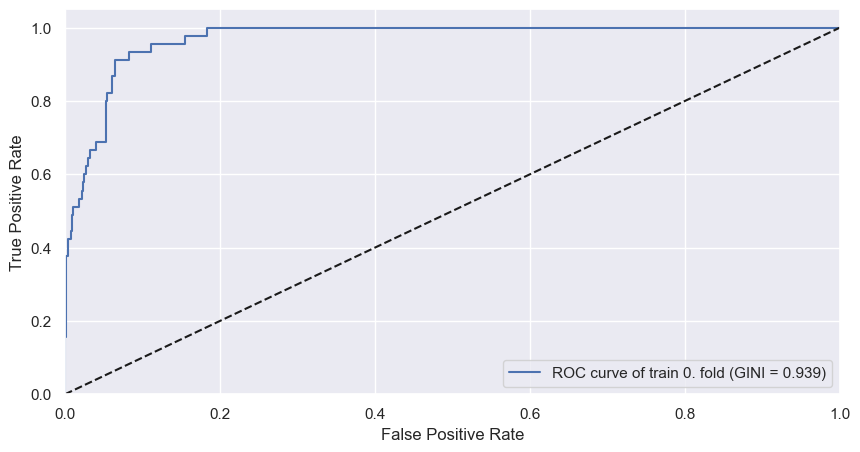

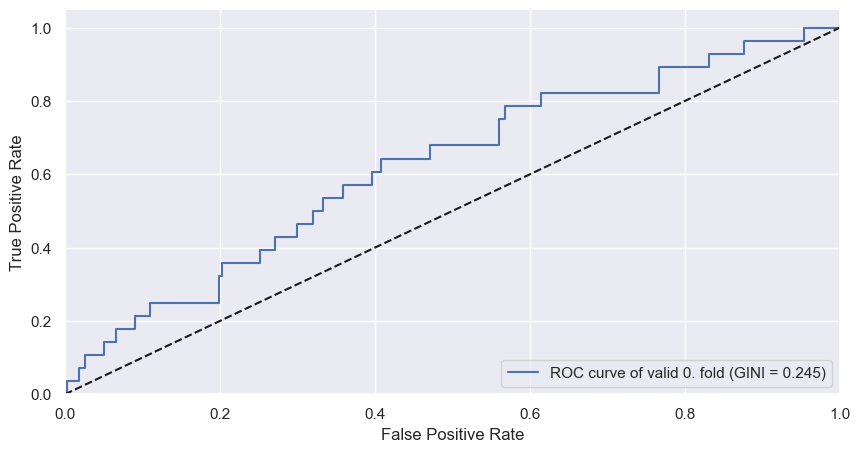

In [93]:
model1 = model_lgb.fit_model(
    data[train_mask],
    data[valid_mask],
    data[train_mask][col_target],
    data[valid_mask][col_target],
    w_train = data[train_mask][col_weight],
    w_valid = data[valid_mask][col_weight],
)

**Predict to unseen dataset**

In case of CV is chosen, then the predictions are average predictions from each of CV models.

In [94]:
from scoring.metrics import gini

predictions = model_lgb.predict(data[valid_mask])
gini(data[valid_mask][col_target], predictions)

0.24528005034612965

### Gain or weight variable importances

Output: DataFrame with features and chosen importance

In case of CV is chosen, then the variable importance is computed as the average variable importance from each CV models.


In [95]:
var_imp = model_lgb.plot_imp(model1, "importance_gain", ret=True, show=True, n_predictors=30)

**Computing shap values for given dataset**

Theoretical background for shap values can be found here https://christophm.github.io/interpretable-ml-book/shapley.html

Output: DataFrame with features and its mean absolute shap values that coresponds with second chart


In [96]:
var_imp_shap = model_lgb.print_shap_values(
    cols_pred_num,
    cols_pred_cat,
    data[train_mask],
    data[valid_mask],
    data[train_mask][col_target],
    data[valid_mask][col_target],
    set_to_shap = data[valid_mask],
    w_train = data[train_mask][col_weight],
    w_valid = data[valid_mask][col_weight],
)

Model has to be trained again because of categorical variables encoding
 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45, number of negative: 678
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062241 -> initscore=-2.712485
[LightGBM] [Info] Start training from score -2.712485
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [97]:
var_imp_shap[:30]

Feature  Shap_importance
1               pencairan         0.208681
0                    usia         0.134675
3           usia_pasangan         0.130088
6               cabang bm         0.094504
5           jenis_kelamin         0.087975
..                    ...              ...
18  flag_same_city_domush         0.004542
10        provisiononloan         0.000000
11              admonloan         0.000000
16  flag_same_city_domktp         0.000000
17  flag_same_prov_domktp         0.000000

[19 rows x 2 columns]

In [98]:
list_pred = list(set().union(var_imp['Feature'].tolist(),
                             var_imp_shap[:30]['Feature'].tolist()))

I am not using CV option, training is stopped when model starts to overfit on valid set
 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45, number of negative: 678
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062241 -> initscore=-2.712485
[LightGBM] [Info] Start training from score -2.712485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

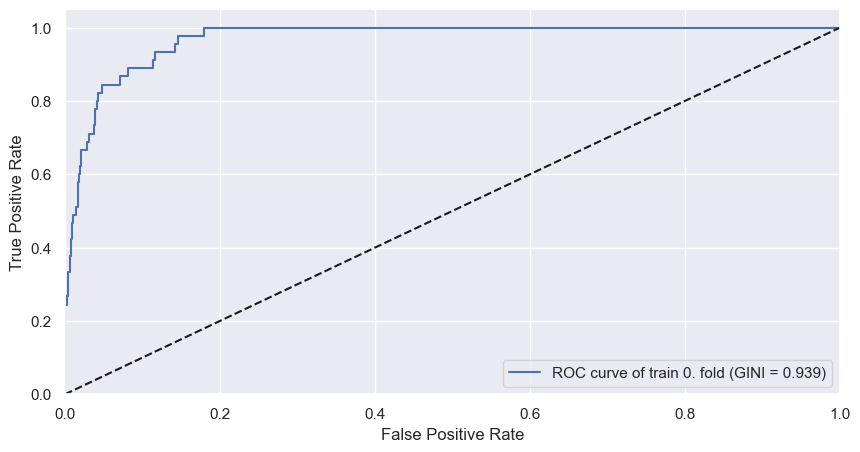

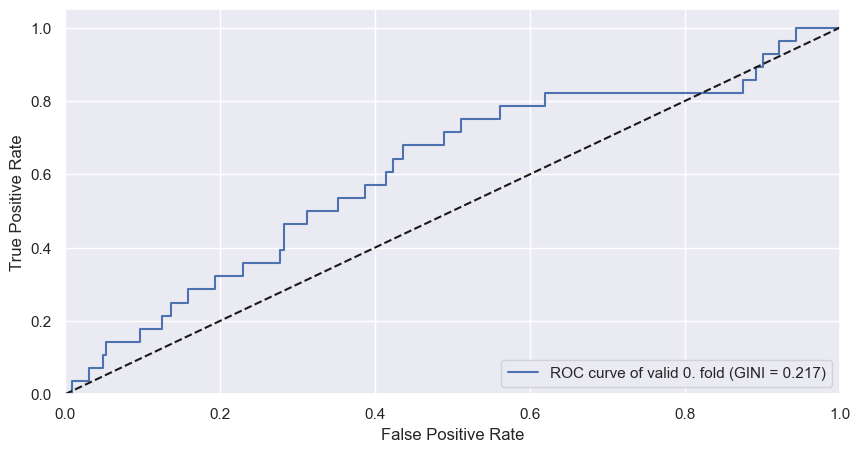

In [99]:
from scoring import lgbm

model_lgb = lgbm.LGBM_model(list_pred, params, use_CV=False, CV_folds=3, CV_seed=9876)

model1 = model_lgb.fit_model(
    data[train_mask],
    data[valid_mask],
    data[train_mask][col_target],
    data[valid_mask][col_target],
    w_train = data[train_mask][col_weight],
    w_valid = data[valid_mask][col_weight],
)

In [100]:
from scoring.metrics import gini

predictions = model_lgb.predict(data[valid_mask])
gini(data[valid_mask][col_target], predictions)

0.21711768407803644

# Scorecard estimator

## Stepwise logistic Regression

### Estimate model

We run stepwise logistic regression on training data set. We start with no predictor in the model and try to add predictors from list called **cols_shortlist2** which is defined below.

We can put there all the WOE variables, but we can also used output of one of the feature selection methods above or some kind of their combination).

In [101]:
cols_shortlist2 = cols_woe
# cols_shortlist2 = clustering_correlation.bestVariables()
# cols_shortlist2_new = sorted(np.unique(l1predictors+
#                                        [s + '_WOE' for s in list_pred]+
#                                        clustering_correlation.bestVariables()))
# cols_shortlist2 = ['avg_csc_settled_cnt_dok_24m_WOE',
# cols_shortlist2 = ['avg_pf_otherconsumercredit_avgcp_24m_WOE', 'days_since_nbfi_inquiry_WOE',
#                     'days_since_delinquencydate_WOE', 'avg_cnt_cal_dok_24m_WOE',
#                     'r_cnt_pf_otherconsumercredit_contr_24m_WOE', 'days_since_disbursementdate_bigbank_WOE',
#                     'min_tenor_12m_WOE', 'cnt_csc_settled_24m_WOE', 'max_worstpastdueamount_nbf1_12m_WOE',
#                     'max_mob_WOE', 'cnt_nbfi_mdc_6m_WOE', 'days_since_disbursementdate_occ_WOE',
#                     'cnt_pc_open_12m_WOE', 'max_outstandingamount_6m_WOE',
#                     'r_cnt_r_pf_12m_24m_WOE', 'avg_pf_otherconsumercredit_maxpa_6m_WOE']

In [102]:
cols_shortlist2_test = [w.replace('_WOE', '') for w in cols_shortlist2]

In [103]:
pd.options.display.max_rows = 1000
descrip = data[cols_shortlist2].describe(include="all").apply(lambda s: s.apply('{0:.2f}'.format)).transpose()
display(descrip.fillna(""))

count   mean   std    min    25%    50%    75%  \
usia_WOE                   2558.00   0.28  1.00  -0.39  -0.39  -0.09   0.48   
pencairan_WOE              2558.00   0.07  0.43  -0.55  -0.55   0.29   0.42   
tahun_kendaraan_WOE        2558.00   0.02  0.24  -0.13  -0.13  -0.13   0.02   
usia_pasangan_WOE          2558.00  -0.05  0.43  -0.38  -0.38  -0.21   0.38   
marital_status_WOE         2558.00   0.05  0.26  -0.42   0.00   0.20   0.20   
jenis_kelamin_WOE          2558.00   0.02  0.23  -0.15  -0.15  -0.15   0.33   
brand_WOE                  2558.00   0.05  0.27  -0.55  -0.10   0.23   0.23   
job category_WOE           2558.00   0.02  0.24  -0.15  -0.15  -0.15   0.39   
jobname_WOE                2558.00   0.04  0.26  -0.16  -0.16  -0.16   0.38   
to_status_WOE              2558.00   0.01  0.15  -0.22  -0.22   0.11   0.11   
kepemilikan_bpkb_WOE       2558.00   0.01  0.11  -0.11  -0.11   0.12   0.12   
custprov_WOE               2558.00   0.02  0.24  -0.12  -0.12  -0.12  -0.12   
custprovhome_WOE           2558.00   0.01  0.14  -0.08  -0.08  -0.08   0.00   
flag_same_city_domush_WOE  2558.00   0.00  0.02  -0.03  -0.03   0.02   0.02   

                            max  
usia_WOE                   4.21  
pencairan_WOE              0.42  
tahun_kendaraan_WOE        0.53  
usia_pasangan_WOE          0.71  
marital_status_WOE         0.20  
jenis_kelamin_WOE          0.33  
brand_WOE                  0.23  
job category_WOE           0.39  
jobname_WOE                0.38  
to_status_WOE              0.11  
kepemilikan_bpkb_WOE       0.12  
custprov_WOE               0.46  
custprovhome_WOE           0.26  
flag_same_city_domush_WOE  0.02

Stepwise process can be tuned using various parameters:
 - *initial_predictors*: set of starting predictors (useful for backward method)
 - *max_iter*: maximal number of iterations
 - *min_increase*: minimal marginal Gini contribution for predictor to be added
 - *max_decrease*: minimal marginal Gini diminution for predictor to be removed
 - *max_predictors*: maximal number of predictors to enter the model. Ignored if set to 0.
 - *max_correlation*: maximal absolute value of correlation of predictors in the model (variable with larger correlation with existing predictors will not be added to the model). **This parameter works for "forward" selection method only.**
 - *beta_sgn_criterion*: if this is set to True, all the betas in the model must have the same signature (all positive or all negative). **This parameter works for "forward" selection method only.**
 - *penalty, C*: regularization parameters for logitic regression (sklearn library)
 - *correlation_sample*: for better performance, correlation matrix is calculated just on a sample of data. The size of the sample is set in this parameter
 - *selection_method*: stepwise or forward or backward
 - *use_cv*: boolean if Cross Validation should be used instead of train/validation split. In this case, if both training and validation samples are presented to the fit method, they are concatenated together and are used for CV. Gini is evaluated as average of all CV's folds' validation Gini. **Please, be aware that using CV after automatic grouping which was trained using train/validate split might lead to overfitted model.**
 - *cv_folds*: parameter for Cross Validation - number of folds
 - *cv_seed*: parameter for Cross Validation - random seed used to split the folds
 
The *fit* method can be called with two arguments *fit(X,y)* or with four agruments *fit(X_train,y_train,X_valid,y_valid)*. When called with four arguments, the Gini is measured on the validation sample (i.e. validation sample is used for decisions about what steps to be done in stepwise).

There are another optional arguments, *sample_weight* and *sample_weight_valid* where you can put the vector (data set column) with weights of the observations for the train and validation samples.

In [104]:
from scoring.model_selection import GiniStepwiseLogit

modelSW = GiniStepwiseLogit(
    initial_predictors=[],
    max_iter=1000,
    min_increase=0.00000,
    max_decrease=0.00000,
    max_predictors=10,
    max_correlation=0.55,
    beta_sgn_criterion=False,
    penalty="l2",
    C=10e10,
    correlation_sample=10000,
    selection_method="forward",
    use_cv=True,
    cv_folds=5,
    cv_seed=98765,
    n_jobs=2,
)

modelSW.fit(
    data[train_mask][cols_shortlist2],
    data[train_mask][col_target],
    data[valid_mask][cols_shortlist2],
    data[valid_mask][col_target],
    sample_weight = data[train_mask][col_weight],
    sample_weight_valid = data[valid_mask][col_weight],
)

Cross validation will be used for the union of training and validation sample.
If you want to use cross validation for training sample only, do not submit any validation sample.
min_increase parameter was <= max_decrease, it is set to max_decrease+0.01 now
Iteration  0

Iter    Gini    GiniΔ  #Pred   AddedPred                                RemovedPred
[ 0]    0.00              0    []
[ 1]   20.49   +20.49     1    pencairan_WOE                            
[ 2]   23.22    +2.73     2    usia_WOE                                 
[ 3]   24.60    +1.38     3    to_status_WOE                            
[ 4]   25.17    +0.57     4    brand_WOE                                
[ 5]   25.37    +0.20     5    marital_status_WOE                       
[ 6]   25.37    +0.00     5                                             


In [105]:
pd.options.display.max_rows = 1000
modelSW.print_final_model()

Coefficient
Variable                       
Intercept             -2.710480
pencairan_WOE         -0.529610
usia_WOE              -0.558413
to_status_WOE         -0.970233
brand_WOE             -0.675796
marital_status_WOE    -0.423619

In [106]:
# modelSW.draw_gini_progression(output_folder + "/model/stepwisegini.png")

In [107]:
# modelSW.progress
# to view specific iterations or rows use code below
# modelSW.progress[modelSW.progress['iteration']==1]

### Full Regression

**Optional:** Alternative to WOE logistic regression. Uses dummy variables instead of WOE variables - it is necessary to make Dummy transformation as the output of Grouping instead of WOE variables.

As predictor set which is served to the class *GiniStepwiseFullLogit*, list of original variables (i.e. names of variables before dummy transformation) is used.

Grouping, which was used to create dummy variables, is served to the class as parameter called *dummy_bindings*. The algorithm then automatically extracts bindings between original and dummy variables and uses it during steps of forward/backward/stepwise regression.

The resulting model includes the both the list of final predictors (original variables) and the list of final dummy variables with their coefficients.

In [108]:
# all_predictors = cols_pred

# from scoring.model_selection import GiniStepwiseLogit

# modelFull = GiniStepwiseLogit(
#     initial_predictors=set(),
#     all_predictors=set(all_predictors),
#     dummy_regression=True,
#     dummy_bindings=grouping.get_dummy_names(),
#     max_iter=1000,
#     min_increase=0.1,
#     max_decrease=0.05,
#     max_predictors=0,
#     selection_method="stepwise",
#     use_cv=False,
#     cv_folds=5,
#     cv_seed=98765,
#     n_jobs=2,
# )

# modelFull.fit(
#     data[train_mask],
#     data[train_mask][col_target],
#     data[valid_mask],
#     data[valid_mask][col_target],
#     sample_weight = data[train_mask][col_weight],
#     sample_weight_valid = data[valid_mask][col_weight],
# )

# clf = modelFull

In [109]:
# pd.options.display.max_rows = 1000
# modelFull.print_final_model()
# pd.options.display.max_rows = 15

### Save model

In [110]:
model_filename2 = "adscore_2_0_myModelSW.model"
pickle.dump(modelSW, open(model_filename2, "wb"))

Load model.

In [111]:
model_filename2 = 'adscore_2_0_myModelSW.model'
modelSW = pickle.load(open(model_filename2, 'rb'))

In [112]:
print("Predictors in the model:", list(modelSW.predictors))

Predictors in the model: ['pencairan_WOE', 'usia_WOE', 'to_status_WOE', 'brand_WOE', 'marital_status_WOE']


## Time stability of predictors

### Stability charts

Set metadata for the stability charts. Two types of charts will be drawn:
- Stability of default rate, for which the variables with default and with base need to be set
- Stability of population, for which the variable with observation count needs to be set

In [113]:
# data["ID"] = data.index

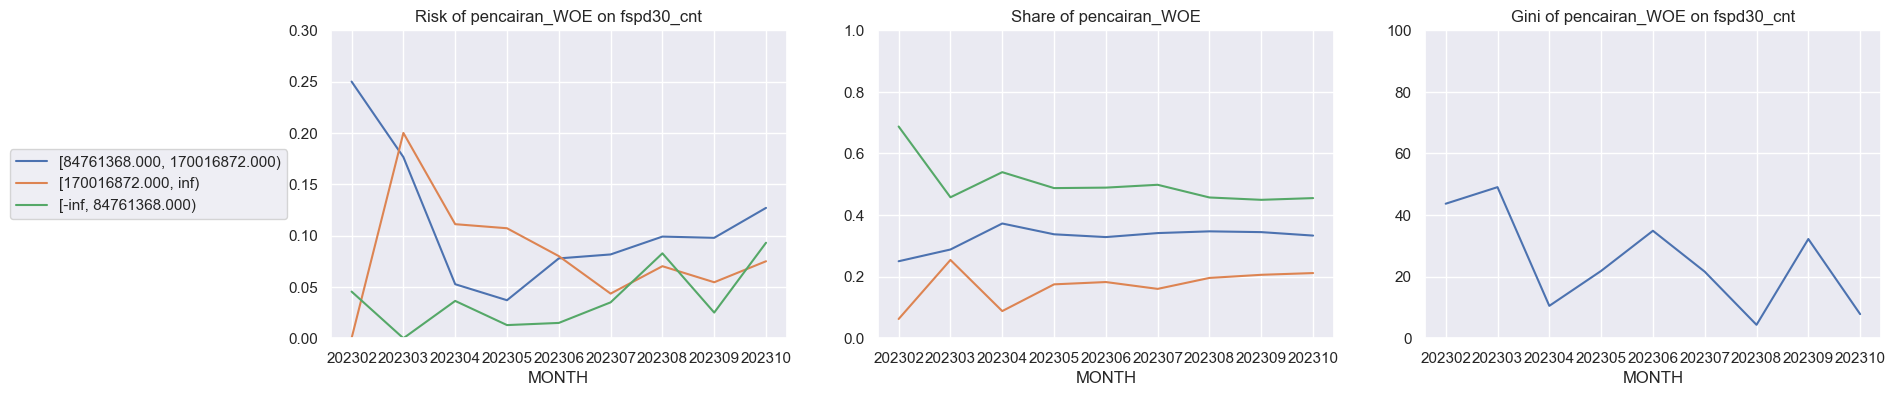

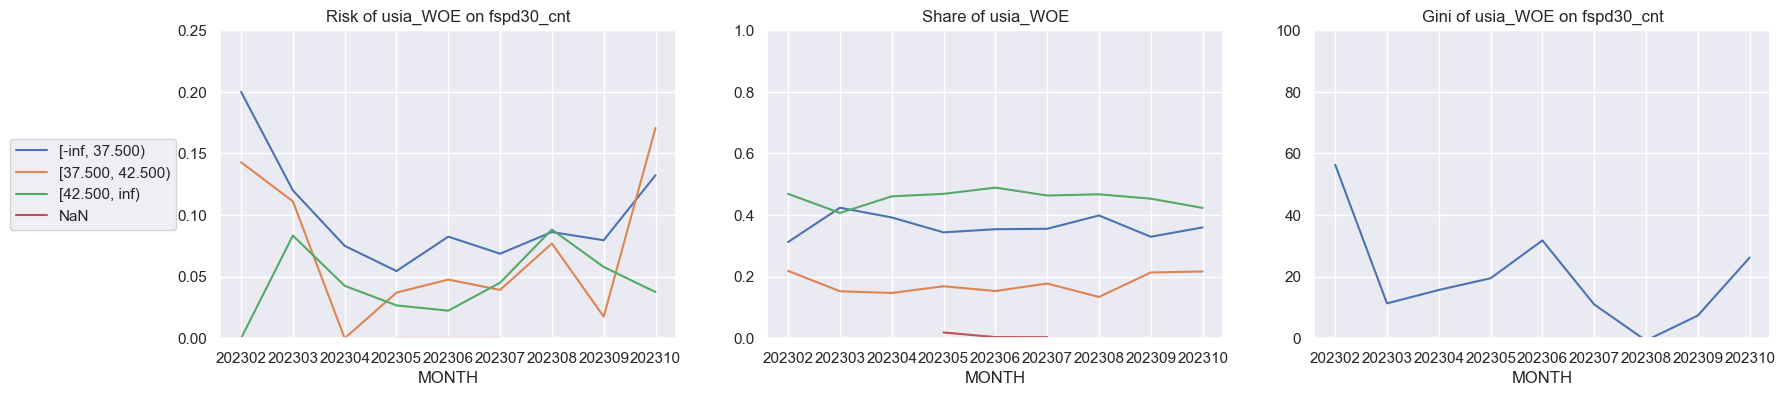

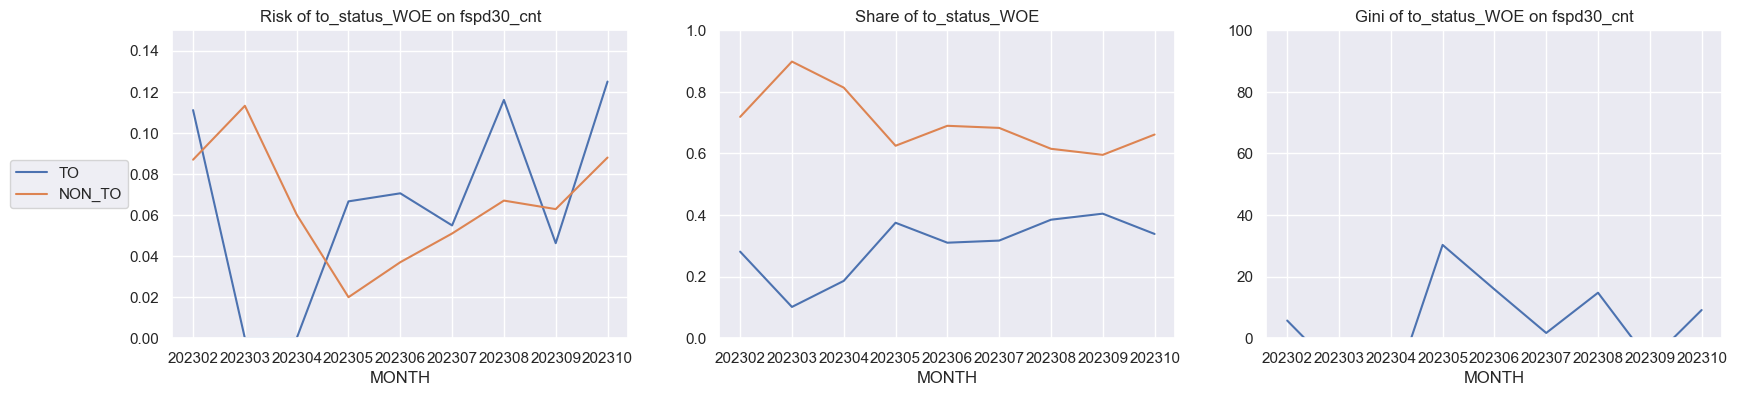

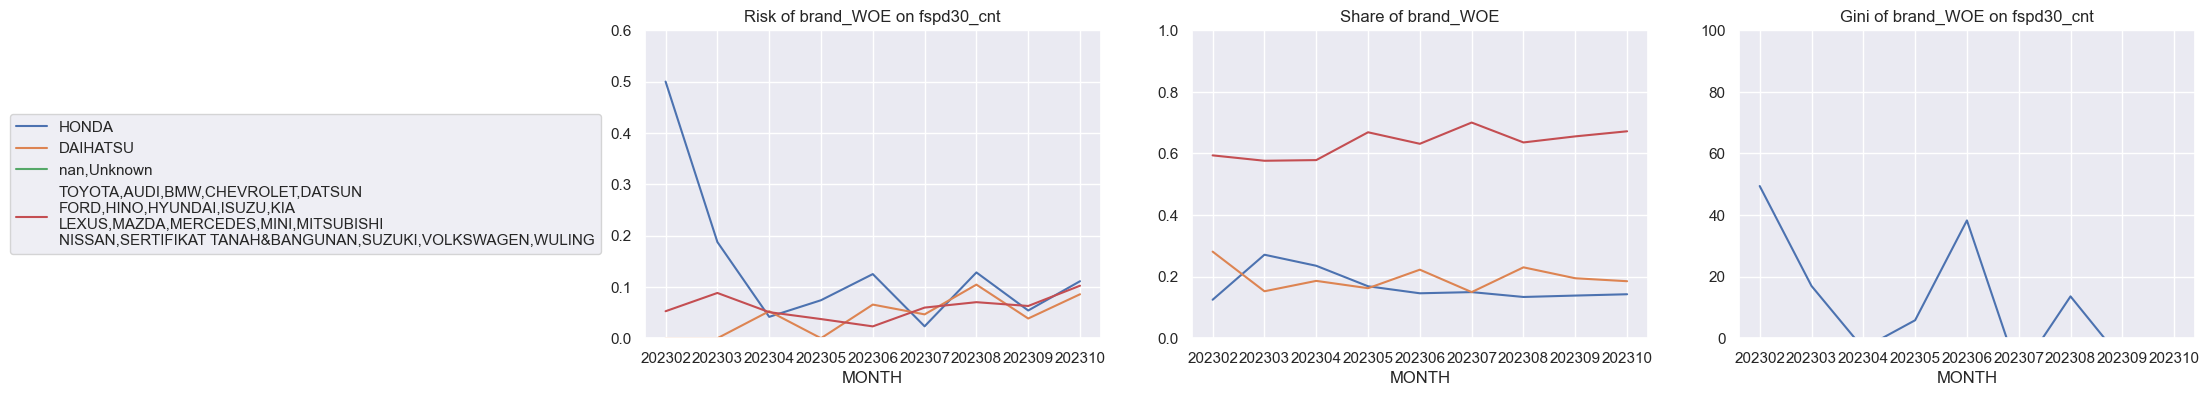

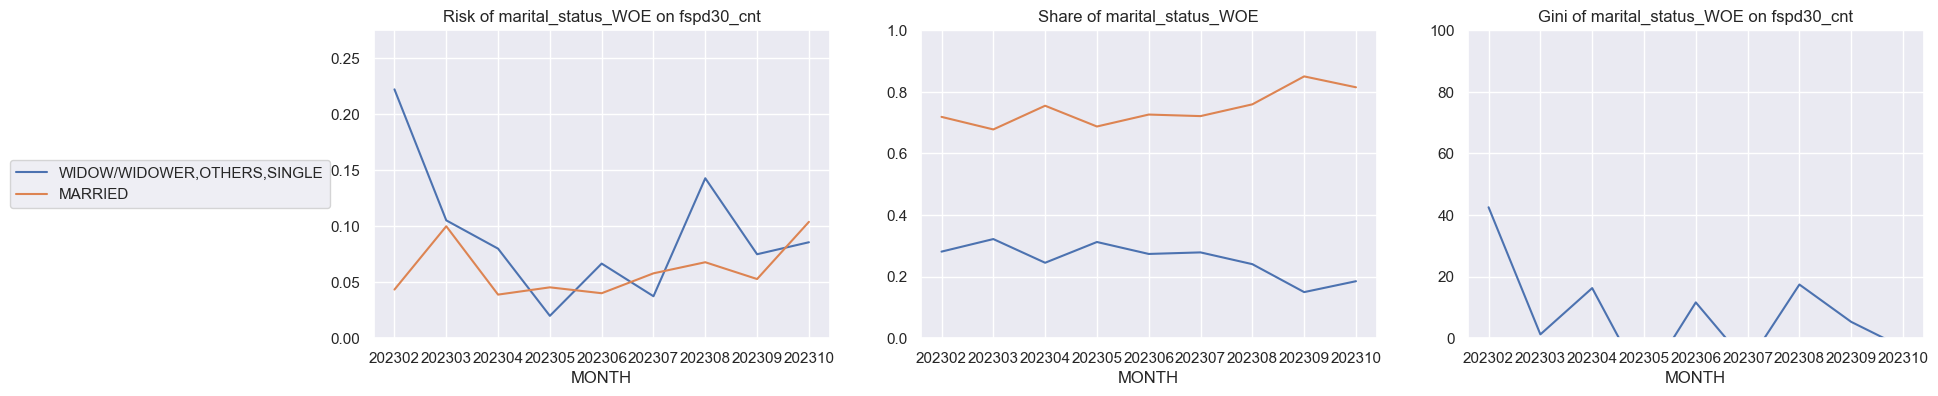

In [114]:
clf = modelSW

for col in list(clf.final_predictors_):
    documentation.GroupedEvaluation(
        data,
        predictor=col,
        sample="Observable",
        target=col_target,
        grouping=grouping,
        use_weight=True,
        output_folder=output_folder + "/stability",
    )

In [115]:
# clf = modelSW

# for col in list(clf.final_predictors_):
#     documentation.GroupedEvaluation(
#         data,
#         predictor=col,
#         sample="Observable",
#         target=col_target,
#         grouping=grouping,
#         use_weight=True,
#         output_folder=output_folder + "/stability",
#     )

We should also verify the population stability of the whole time period and stability of shorter target, e.g. FPD30.

In [116]:
# name of the short target column
target_for_default_short = "fdp30_cnt"
# name of the short target's base column
base_for_default_short = "fpd30_obs"

In [117]:
documentation.targets.append((target_for_default_short, base_for_default_short))
documentation.targets

[('fspd30_cnt', 'fspd30_obs'), ('fdp30_cnt', 'fpd30_obs')]

The following code adds base for short target (its name is defined above) if it does not already exist in the data.

In [118]:
if base_for_default_short not in data:
    data[base_for_default_short] = 0
    data.loc[data[target_for_default_short] == 0, base_for_default_short] = 1
    data.loc[data[target_for_default_short] == 1, base_for_default_short] = 1
    print("Column", base_for_default_short, "added/modified. Number of columns:", data.shape[1])
else:
    print("Column", base_for_default_short, "already exists.")

Column fpd30_obs already exists.


In [119]:
documentation.sample_dict["Observable short"] = data[base_for_default_short] == 1
documentation.sample_dict.keys()

dict_keys(['Observable', 'Train', 'Validation', 'Out of Time', 'Observable short'])

In [120]:
# for col in list(clf.final_predictors_):
#     documentation.GroupedEvaluation(
#         data,
#         predictor=col,
#         sample="Observable short",
#         target=target_for_default_short,
#         grouping=grouping,
#         use_weight=True,
#         output_folder=output_folder + "/stability_short",
#     )

### Stability Index

The following code calculates two versions of Elena's Stability Index, which are defined as follows.

**v1** 
1. Compute the bad rates in each category for each month
2. Compute the rank of each category within each month based on the bad rate
3. Compute the frequency of each position / rank within each category from step 2
4. Compute the ratios of the most frequent position / rank within each category from step 3
5. Compute average of the ratios from step 4

**v2**
1. Compute the bad rates in each category for each month
2. Compute the rank of each category within each month based on the bad rate
3. Compute the frequency of each position / rank through all categories from step 2 and the corresponding ratios
4. Compute the product of the ratios within each position / rank from step 3
5. Compute average of the products from step 4

*Note: Both version can give "false positives" (indicating that variable is unstable) for U-shaped variables.*

In [121]:
# from scoring.stability_index import stability_index_value

# stability_tab = []
# clf = modelSW

# for pred in clf.final_predictors_:
#     for mask in ["train_mask", "valid_mask", "test_mask", "oot_mask"]:
#         for ver in ["v1", "v2"]:
#             stability_tab.append(
#                 {
#                     "Name": pred,
#                     "Sample": mask[:-5],
#                     "Index version": ver,
#                     "Index value": stability_index_value(
#                         data[POS_NEW][eval(mask)],
#                         pred,
#                         col_target,
#                         col_base,
#                         col_month,
#                         col_weight=col_weight
#                     )[ver],
#                 }
#             )

# stability_tab = pd.DataFrame(stability_tab)
# stability_tab = stability_tab.groupby(["Name", "Index version", "Sample"])[["Index value"]].mean().unstack(level=[1, 2])

# pd.options.display.max_rows = 1000
# display(stability_tab.round(3))
# # stability_tab.to_csv(output_folder + "/stability/stability_index.csv")

In [122]:
# from scoring.stability_index import stability_index_value

# stability_tab = []
# clf = modelSW

# for pred in clf.final_predictors_:
#     for mask in ["train_mask", "valid_mask", "test_mask", "oot_mask"]:
#         for ver in ["v1", "v2"]:
#             stability_tab.append(
#                 {
#                     "Name": pred,
#                     "Sample": mask[:-5],
#                     "Index version": ver,
#                     "Index value": stability_index_value(
#                         data[eval(mask)],
#                         pred,
#                         col_target,
#                         col_base,
#                         col_month,
#                         col_weight=col_weight
#                     )[ver],
#                 }
#             )

# stability_tab = pd.DataFrame(stability_tab)
# stability_tab = stability_tab.groupby(["Name", "Index version", "Sample"])[["Index value"]].mean().unstack(level=[1, 2])

# pd.options.display.max_rows = 1000
# display(stability_tab.round(3))
# stability_tab.to_csv(output_folder + "/stability/stability_index.csv")

### PSI

In [123]:
# from scoring.stability_index import psi_calc_df

# monthly_psi, masked_psi = psi_calc_df(
#     data[POS_NEW],
#     cols_pred_psi=clf.final_predictors_,
#     col_month="MONTH",
#     col_weight=col_weight,
# )
# display(monthly_psi)

In [124]:
from scoring.stability_index import psi_calc_df

monthly_psi, masked_psi = psi_calc_df(
    data,
    cols_pred_psi=clf.final_predictors_,
    col_month="MONTH",
    col_weight=col_weight,
)
display(monthly_psi)

There are some different categories in variables sref and sact. They will be ignored in PSI.
Month run: variable pencairan_WOE is proceed. Done variables: 0/4
There are some different categories in variables sref and sact. They will be ignored in PSI.
There are some different categories in variables sref and sact. They will be ignored in PSI.
There are some different categories in variables sref and sact. They will be ignored in PSI.
There are some different categories in variables sref and sact. They will be ignored in PSI.
There are some different categories in variables sref and sact. They will be ignored in PSI.
There are some different categories in variables sref and sact. They will be ignored in PSI.
There are some different categories in variables sref and sact. They will be ignored in PSI.
Month run: variable usia_WOE is proceed. Done variables: 1/4
There are some different categories in variables sref and sact. They will be ignored in PSI.
Month run: variable to_status_WOE is

Variable  PSI avg per month
0       pencairan_WOE           0.107196
2       to_status_WOE           0.088397
3           brand_WOE           0.074476
1            usia_WOE           0.065551
4  marital_status_WOE           0.053142

## Model with exact set of predictors

Use predictors from stepwise model for marginal contribution test

### Estimate model

In [125]:
clf = modelSW
cols_mc_shortlist = list(clf.predictors)

Fit a model with an exact set of predictors. Set *cols_exactlist* to list of your chosen predictors.
 - *cols_exactlist*: list of predictors to fit with a model

In [126]:
# %%capture --no-display
# from scoring.model_selection import GiniStepwiseLogit

# cols_exactlist = cols_mc_shortlist

# modelSW1 = GiniStepwiseLogit(
#     initial_predictors=cols_shortlist2,
#     max_iter=1000,
#     min_increase=0.1,
#     max_decrease=0.05,
#     max_predictors=15,
#     max_correlation=0.4,
#     beta_sgn_criterion=False,
#     penalty="l2",
#     C=10e10,
#     correlation_sample=10000,
#     selection_method="forward",
#     use_cv=True,
#     cv_folds=5,
#     cv_seed=98765,
#     n_jobs=2,
# )

# modelSW1.fit(
#     data[train_mask][cols_exactlist],
#     data[train_mask][col_target],
#     data[valid_mask][cols_exactlist],
#     data[valid_mask][col_target],
#     sample_weight = data[train_mask][col_weight],
#     sample_weight_valid = data[valid_mask][col_weight],
# )
# m1 = modelSW1.progress.iloc[0]["Gini"]
# display(Markdown("Predictors: {}".format(",\n ".join(cols_exactlist))))
# display(Markdown("Gini: **{}**".format(m1)))

### Save model

In [127]:
# model_filename3 = "myModelSW1.model"
# pickle.dump(modelSW1, open(model_filename3, "wb"))

Load model.

In [128]:
# model_filename2 = "adscore_2_0_myModelSW.model"
# modelSW1 = pickle.load(open(model_filename3, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'myModelSW.model'

## Marginal contribution

Calculate marginal contribution for adding and removing predictors to/from a chosen set.
 - *cols_mc*: base list of predictors
 - *cols_to_add*: list of predictors to be added

In [ ]:
# from scoring.metrics import iv, gini, lift

# power_tab = []
# for j in range(0, len(cols_mc_shortlist)):
#     power_tab.append(
#         {
#             "Name": cols_mc_shortlist[j],
#             "IV Train": iv(
#                 data[POS_NEW].loc[train_mask, col_target],
#                 data[POS_NEW].loc[train_mask, cols_mc_shortlist[j]],
#             ),
#             "Gini Train": gini(
#                 data[POS_NEW].loc[train_mask, col_target],
#                 -data[POS_NEW].loc[train_mask, cols_mc_shortlist[j]],
#                 sample_weight = data[POS_NEW].loc[train_mask, col_weight]
#             ),
#             "IV Validate": iv(
#                 data[POS_NEW].loc[valid_mask, col_target],
#                 data[POS_NEW].loc[valid_mask, cols_mc_shortlist[j]],
#             ),
#             "Gini Validate": gini(
#                 data[POS_NEW].loc[valid_mask, col_target],
#                 -data[POS_NEW].loc[valid_mask, cols_mc_shortlist[j]],
#                 sample_weight = data[POS_NEW].loc[valid_mask, col_weight]
#             ),
#             "IV Test": iv(
#                 data[POS_NEW].loc[test_mask, col_target],
#                 data[POS_NEW].loc[test_mask, cols_mc_shortlist[j]],
#             ),
#             "Gini Test": gini(
#                 data[POS_NEW].loc[test_mask, col_target],
#                 -data[POS_NEW].loc[test_mask, cols_mc_shortlist[j]],
#                 sample_weight = data[POS_NEW].loc[test_mask, col_weight]
#             ),
#             "IV OOT": iv(
#                 data[POS_NEW].loc[oot_mask, col_target],
#                 data[POS_NEW].loc[oot_mask, cols_mc_shortlist[j]],
#             ),
#             "Gini OOT": gini(
#                 data[POS_NEW].loc[oot_mask, col_target],
#                 -data[POS_NEW].loc[oot_mask, cols_mc_shortlist[j]],
#                 sample_weight = data[POS_NEW].loc[oot_mask, col_weight]
#             ),
# #             "IV HOOT": iv(
# #                 data[POS_NEW].loc[hoot_mask, col_target],
# #                 data[POS_NEW].loc[hoot_mask, cols_mc_shortlist[j]],
# #             ),
# #             "Gini HOOT": gini(
# #                 data[POS_NEW].loc[hoot_mask, col_target],
# #                 -data[POS_NEW].loc[hoot_mask, cols_mc_shortlist[j]],
# #                 sample_weight = data[POS_NEW].loc[hoot_mask, col_weight]
# #             ),
#         }
#     )
# power_out = pd.DataFrame.from_records(power_tab)
# power_out = power_out.set_index("Name")
# power_out = power_out.sort_values("Gini Train", ascending=False)

# pd.options.display.max_rows = 1000
# display(power_out)
# pd.options.display.max_rows = 15
# power_out.to_csv(output_folder + "/predictors/covariates.csv")

In [ ]:
from scoring.metrics import iv, gini, lift

power_tab = []
for j in range(0, len(cols_mc_shortlist)):
    power_tab.append(
        {
            "Name": cols_mc_shortlist[j],
            "IV Train": iv(
                data.loc[train_mask, col_target],
                data.loc[train_mask, cols_mc_shortlist[j]],
            ),
            "Gini Train": gini(
                data.loc[train_mask, col_target],
                -data.loc[train_mask, cols_mc_shortlist[j]],
                sample_weight = data.loc[train_mask, col_weight]
            ),
            "IV Validate": iv(
                data.loc[valid_mask, col_target],
                data.loc[valid_mask, cols_mc_shortlist[j]],
            ),
            "Gini Validate": gini(
                data.loc[valid_mask, col_target],
                -data.loc[valid_mask, cols_mc_shortlist[j]],
                sample_weight = data.loc[valid_mask, col_weight]
            ),
#             "IV Test": iv(
#                 data.loc[test_mask, col_target],
#                 data.loc[test_mask, cols_mc_shortlist[j]],
#             ),
#             "Gini Test": gini(
#                 data.loc[test_mask, col_target],
#                 -data.loc[test_mask, cols_mc_shortlist[j]],
#                 sample_weight = data.loc[test_mask, col_weight]
#             ),
            "IV OOT": iv(
                data.loc[oot_mask, col_target],
                data.loc[oot_mask, cols_mc_shortlist[j]],
            ),
            "Gini OOT": gini(
                data.loc[oot_mask, col_target],
                -data.loc[oot_mask, cols_mc_shortlist[j]],
                sample_weight = data.loc[oot_mask, col_weight]
            ),
#             "IV HOOT": iv(
#                 data.loc[hoot_mask, col_target],
#                 data.loc[hoot_mask, cols_mc_shortlist[j]],
#             ),
#             "Gini HOOT": gini(
#                 data.loc[hoot_mask, col_target],
#                 -data.loc[hoot_mask, cols_mc_shortlist[j]],
#                 sample_weight = data.loc[hoot_mask, col_weight]
#             ),
        }
    )
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index("Name")
power_out = power_out.sort_values("Gini Train", ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(output_folder + "/predictors/covariates.csv")

In [ ]:
%%capture --no-display
# cols_mc_to_add = cols_woe
cols_mc_to_add = []

modelSW1.marginal_contribution(
    data[train_mask],
    data[train_mask][col_target],
    data[valid_mask],
    data[valid_mask][col_target],
    predictors_to_add = cols_mc_to_add,
    output_path = output_folder + "/model/marg_cont.csv"
)

In [ ]:
# %%capture --no-display
# # cols_mc_to_add = cols_woe
# cols_mc_to_add = []

# modelSW1.marginal_contribution(
#     data[POS_NEW][train_mask],
#     data[POS_NEW][train_mask][col_target],
#     data[POS_NEW][valid_mask],
#     data[POS_NEW][valid_mask][col_target],
#     predictors_to_add = cols_mc_to_add,
# #     output_path = output_folder + "/model/marg_cont.csv"
# )

## Cluster Surrogates

Based on clustering which you ran in the previous parts of workflow (either *hierarchical* or *k-means*), clusters of original variables were established. In this part of workflow, you can check what would happen if you swapped any of the predictors with another variable from the same cluster.
This is particulartly useful when you can’t use an originally selected predictor (e.g. there is a business reason why the predictor should not be used).
For this object to work, you need list of predictors (from your model), list of all variables and corresponding list of numbers assigning clusters to these variables. In the data set, you need to have all the variables from the list.

In [ ]:
from scoring.model_selection import VarClusSurrogates

surrogates = VarClusSurrogates(
    clustering_correlation.variables_, clustering_correlation.labels_, modelSW.final_predictors_
)

surrogates.fit(
    data[train_mask][cols_woe], data[train_mask][col_target], data[valid_mask][cols_woe], data[valid_mask][col_target]
)

In [ ]:
pd.options.display.max_rows = 1000
surrogates.displaySurrogates(output_folder + "/predictors/cluster_surrogates.csv")

## Score the dataset
**First choose which model is your final model** (into variable *clf*)!

In [ ]:
data.columns

In [ ]:
# clf = modelL1
clf = modelSW1

cols_final_predictors = list(clf.predictors)
# pd.DataFrame(cols_final_predictors).to_csv(output_folder + "/predictors/predictors.csv", index=False, header=None)
clf.print_final_model()

Create a new column with the prediction (probability of default).

In [ ]:
col_score = "ADSCORE_2_0"

data[col_score] = clf.predict(data)
print("Column", col_score, "with the prediction added/modified. Number of columns:", data.shape[1])

In [ ]:
# col_score = "ADSCORE_2_0"

# data[col_score] = clf.predict(data)
# print("Column", col_score, "with the prediction added/modified. Number of columns:", data.shape[1])

In [ ]:
data.columns

In [ ]:
data.reset_index()[['appid','ktp_no_customer', 'nama_customer', 'bookingdate', 'ADSCORE_2_0'] + clf.predictors].to_csv('data_adscore_2_0_score.csv', index=False)

In [ ]:
# import configparser
# from sqlalchemy import create_engine

# CONFIG_FILE = '/home/agustiar/Main_File/config_maxel.ini'

# # reading of configuration file
# config = configparser.ConfigParser()
# config.read(CONFIG_FILE)
# username = config.get('dtb_data', 'login')
# password = config.get('dtb_data', 'password')
# conn_path = config.get('dtb_data', 'path')

# # create engine
# engine = create_engine('oracle://{}:{}@{}'.format(username, password, conn_path), echo=False)

# def lookup_date(s):
#     """
#     This is an extremely fast approach to datetime parsing.
#     For large data, the same dates are often repeated. Rather than
#     re-parse these, we store all unique dates, parse them, and
#     use a lookup to convert all dates.
#     Example: df['date'] = lookup_date(df['date'])
#     """
    
#     dates = {date:pd.to_datetime(date) for date in s.unique()}
#     return s.map(dates)

# data_save = data[['skp_credit_case', 'date_decision', 'code_product_profile', 'code_client_type', 'SCORE_PEFINDO_2_0']]
# # inserting to a table
# try:
#     # handle incosistent datetime object
#     data_save['date_decision'] = lookup_date(data_save['date_decision'])
#     # inserting to database
#     data_save.to_sql('ag_pefindo_2_0_gm', engine, index=False, if_exists="append", schema = 'ap_maxel')
#     print('Success! New data is inserted into Predictors table', datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
# except:
#     print('Process failed', datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
# data_save = data[['skp_credit_case', 'date_decision', 'code_product_profile', 'code_client_type', 'SCORE_PEFINDO_2_0']]

In [ ]:
# data_save.to_csv('data_pef_2_0.csv', index=False)

# Scorecard table output
Output the scorecard to a table. Stats are calculated on a subset of data given by the mask defined below.

In [ ]:
# this mask is an union of masks for training, validation, testing and out of time data sets
table_mask = train_mask | valid_mask | oot_mask

In [ ]:
from scoring.scorecard import ScoreCard

scorecard_new = ScoreCard(
    grouping=grouping, predictors=clf.predictors, coefficients=clf.coef, intercept=clf.intercept
)

In [ ]:
pd.options.display.max_rows = 1000
display(scorecard_new.scorecard_table_simple().fillna(""))
pd.options.display.max_rows = 15

In [ ]:
pd.options.display.max_rows = 1000
scorecard_out = scorecard_new.scorecard_table_full(data, table_mask, col_target, weightcol=None)
scorecard_out.to_csv(output_folder + "/model/scorecard.csv")
display(scorecard_out.fillna(""))
pd.options.display.max_rows = 15

# Reject inference
In case there were many rejects in the approval process, it might happen that for some values of certain predictors, reject rate was much higher than for others. In this case, so called *„cherry picking“* migh have occured: only the best part of certain sub-population (corresponding to some predictor values) is approved resulting in default rate of this subpopulation being seemingly much lower than it would be normally. This might affect the future performance of the new model, as this sub-population would receive overly optimistic score based on training data.

## Reject inference analysis

In this analysis we see WoE of default rate (based on logarithm of odds „good vs bad“) compared to WoE of reject rate (based on logarithm odds „approve vs reject“). If these two WoEs have opposite trend for a certain predictor, it means that there is potential reject inference issue.

**For this object to work properly, you need to include rejected applications in the data and add a new 0-1 variable containing the rejected flag.** This means that the original masks as *train_mask* can't be used as they consist of observations with measureable defaults only, i.e. there are not the rejected observations in them.

The reject inference analysis can be peformed on two samples (e.g. train and validation) so you can also compare WoEs of these samples against each other.

In [ ]:
# from scoring.reject_inference import RejectInferenceCharts

# rejectinf = RejectInferenceCharts(
#     target=col_target,
#     reject=col_reject,
#     predictors=cols_final_predictors,
#     weight=col_weight,
# )
# rejectinf.fit(
#     data1=data[data[col_datatype] == "train"],
#     data2=data[data[col_datatype] == "valid"],
# )
# rejectinf.display()

## Rejected target imputation

Sometimes, we have many rejected cases without observed target, however there exist some kind of proxy target, which can be assigned to these observations so the final model can be scored on them as well as on the usual observations.

For example: there is a high reject rate, but for the rejected cases we have some external score which can tell us to some extent whether they woul default or not. To avoid reject inference we want to add these observations into our trainig sample.

**TargetImputer** is a class for target imputation based on pre-calculated target probabilities. Typical usage is if we want to assign a proxy target to rows where target is unobserved.
There are three imputation types that can be used:
- *randomized*: for each observation where we want to impute the target, an random number between 0 and 1 is generated. Then this ranom number is compared with the pre-calculated probability and target is assigned based on this comparison.
- *cutoff*: for each observation where we want to impute the target, the pre-caluclated probability is compared with this cutoff value and target is assigned based on this comparison.
- *weighted*: for each observation where we want to impute the target, two observations are generated. Each of them has a different value of the target, one of the has weight p and the other has weight 1-p, where p is the pre-calculated target probability.

When we initiate an instance of this class, we use the following arguments:
- imputation_type - Imputation which we want to use, can be 'randomized', 'cutoff' or 'weighted'
- cutoff - Cutoff value which is used if 'cutoff' imputation_type is selected (default: 0.5)
- random_seed - Random seed which is used if 'randomized' imputation_type is selected (default: 987)

Then, *fit* method is called, where the dataset where the target should be imputed is specified. This dataset must contain a column with pre-caluclated target probabilities (floats between 0 and 1) and a column with indicator whether target should be imputed for given row (integers with values 0 or 1). The method then calculates the imputed target using the parameter specified during initialization.

And finally, *transform* method add the imputed values into the dataset. We can specify, whether they should rewrite the original values or be added as new columns. For *weighted* imputation method, it is recommended to use optional argument `reset_index=True`, because this method duplicates some rows, and having rows with duplicate index can cause error in other parts of the workflow.

In [ ]:
# from scoring.reject_inference import TargetImputer

# targetImputer = TargetImputer(imputation_type='randomized', random_seed=987)

# targetImputer.fit(data = data,
#                   col_probs = col_score,
#                   col_reject = col_reject,
#                   col_weight = col_weight,
#                   prob_of = 1)

# data = targetImputer.transform(data = data,
#                                col_target = col_target,
#                                col_weight = col_weight,
#                                as_new_columns = True,
#                                reset_index = True)

# Correlations
Calculate and visualise correlation matrix

In [ ]:
documentation.Correlations(
    data,
    predictors=cols_final_predictors,
    sample="All",
    use_weight=True,
    output_folder=output_folder + "/analysis/",
    filename="correlation.png",
    show_plot=True
)

Show the list of the highest correlation (restricted to correlations that are, in absolute value, higher than *max_ok_correlation* parameter):

In [ ]:
cormat = data[cols_final_predictors].corr()
max_ok_correlation = 0.0

# find highest pairwise correlation (correlation greater than .. in absolute value)
hicors = []
for i in range(0, len(cormat)):
    for j in range(0, len(cormat)):
        if (cormat.iloc[i][j] > max_ok_correlation or cormat.iloc[i][j] < -max_ok_correlation) and i < j:
            hicors.append((i, j, cormat.index[i], cormat.index[j], cormat.iloc[i][j], abs(cormat.iloc[i][j])))
hicors.sort(key=lambda tup: tup[5], reverse=True)

hicors2 = pd.DataFrame(list(zip(*list(zip(*hicors))[2:5])))

# print list of highest correlations
hicors2.head(10)

# Performance characteristics
Performance characteristics of the model (Gini, Lift) and their visualisations.

## Import from Gradient boosting workflow

**If you used the Gradient boosting workflow** to develop the model, here you can import all the metadata from Gradient boosting workflow and continue from here. **PSW will be able to generate all the performance characteristics analysis**, score distribution and also comparison with another score and short target performance.

Otherwise, keep this outcommented.

In [ ]:
# import time
# import datetime
# import operator
# import math
# import random
# import numpy as np
# import pandas as pd

# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os.path
# import pickle
# import gc
# # check your tqdm version if import fails
# from tqdm.notebook import tqdm

# import sys

# sys.path.insert(0, "..")
# import scoring

# metadata = json.load(open("metadata_gb_wfl.json", "r", encoding="utf8"))

# col_time = metadata["col_time"]
# col_month = metadata["col_month"]
# col_day = metadata["col_day"]
# col_target = metadata["col_target"]
# col_base = metadata["col_base"]
# col_weight = metadata["col_weight"]
# col_reject = metadata["col_reject"]
# col_datatype = metadata["col_datatype"]
# col_id = metadata["col_id"]
# col_score = metadata["col_score"]

# from scoring import db
# data = db.read_csv('data_from_gb_wfl.csv', index_col=col_id)
# data[col_id] = data.index

# train_mask = (data[col_datatype] == 'train') & (data[col_base] == 1)
# valid_mask = (data[col_datatype] == 'valid') & (data[col_base] == 1)
# test_mask = (data[col_datatype] == 'test') & (data[col_base] == 1)
# oot_mask = (data[col_datatype] == 'oot') & (data[col_base] == 1)
# hoot_mask = (data[col_datatype] == 'hoot') & (data[col_base] == 1)
# observable_mask = (data[col_base] == 1)

# sns.set()
# %matplotlib inline
# %config InlineBackend.close_figures=True
# from IPython.display import display, Markdown, HTML
# pd.options.display.max_columns = None
# pd.options.display.max_rows = 15
# output_folder = 'documentation_lgbm'
# subfolders = [
#     "performance",
#     "predictors",
#     "stability",
#     "stability_short",
#     "analysis",
#     "model",
#     "nan_share"
# ]

# os.makedirs(output_folder, exist_ok=True)
    
# for folder in subfolders:
#     os.makedirs(os.path.join(output_folder, folder), exist_ok=True)
    
# from scoring import doctools
# documentation = pickle.load(open("documentation_gb_wfl.pkl", "rb"))

## Performance per sample

If some od these samples (train, valid, test, OOT, HOOT) are empty (i.e. you don't use them), **you need to comment their according rows in some of the following cells.** Such rows are marked by short comments at their ends.

In [ ]:
from scoring.metrics import gini, lift, kolmogorov_smirnov, eval_performance_wrapper

lift_perc = 10

eval_masks = {
    "train": train_mask,
    "valid": valid_mask,
#     "test": test_mask,
    "oot": oot_mask,
#     "hoot": hoot_mask,
}

In [ ]:
perf = eval_performance_wrapper(
    data=data,
    masks=eval_masks,
    col_target=col_target,
    col_score=col_score,
    col_weight=col_weight,
    lift_perc=10,
)
display(perf)
perf.to_csv(output_folder + "/performance/performance.csv")

In [ ]:
from scoring.tools import curves_wrapper

curves_wrapper(
    data=data,
    masks=eval_masks,
    col_target=col_target,
    col_score=col_score,
    col_weight=col_weight,
    lift_perc=10,
    output_folder=output_folder + "/performance/",
)

In [ ]:
# scoring.plot.plot_kolmogorov_smirnov(data[col_target], data[col_score])

## Performance per Product

In [ ]:
# data['code_product_profile'].unique()

In [ ]:
testing_prod = {}

for name,product in products.items():
    testing_prod[name] = pd.DataFrame({'sample':[
        'all', #train
#         'valid', #valid
#         'test', #test
        'oot', #OOT
#         'hoot' #HOOT
        ],'gini_'+str(name):[
        gini(data[product][train_mask|valid_mask][col_target],data[product][train_mask|valid_mask][col_score]) #train
#         gini(data[product][train_mask][col_target],data[product][train_mask][col_score]) #train
#         ,gini(data[product][valid_mask][col_target],data[product][valid_mask][col_score]) #valid
#         ,gini(data[product][test_mask][col_target],data[product][test_mask][col_score]) #test
        ,gini(data[product][oot_mask][col_target],data[product][oot_mask][col_score]) #OOT
#         ,gini(data[product][hoot_mask][col_target],data[product][hoot_mask][col_score]) #HOOT
        ],'lift_'+str(name)+'_'+str(lift_perc):[
        lift(data[product][train_mask|valid_mask][col_target],-data[product][train_mask|valid_mask][col_score],lift_perc) #train
#         ,lift(data[product][valid_mask][col_target],-data[product][valid_mask][col_score],lift_perc) #valid
#         ,lift(data[product][test_mask][col_target],-data[product][test_mask][col_score],lift_perc) #test
        ,lift(data[product][oot_mask][col_target],-data[product][oot_mask][col_score],lift_perc) #OOT
#         ,lift(data[product][hoot_mask][col_target],-data[product][hoot_mask][col_score],lift_perc) #HOOT
        ]
#         ,'KS_'+str(name):[
#         kolmogorov_smirnov(data[product][col_score],data[product][col_target]) #train
# #         ,kolmogorov_smirnov(data[product][valid_mask][col_score],data[product][valid_mask][col_target]) #valid
# #         ,kolmogorov_smirnov(data[product][test_mask][col_score],data[product][test_mask][col_target]) #test
# #         ,kolmogorov_smirnov(data[product][oot_mask][col_score],data[product][oot_mask][col_target]) #OOT
# #         ,kolmogorov_smirnov(data[product][hoot_mask][col_score],data[product][hoot_mask][col_target]) #HOOT
#         ]
        }).set_index('sample')

In [ ]:
performance = pd.concat([perf['gini']
                         ,testing_prod['refinancing']
                         ,testing_prod['jual_beli']
                         ,testing_prod['DT']
                         ,testing_prod['RO']
                        ],axis=1)

In [ ]:
display(performance[['ADSCORE_2_0'
                     ,'gini_refinancing'
                     ,'gini_jual_beli'
                     ,'gini_DT'
                     ,'gini_RO'
                    ]])

performance.to_csv(output_folder+'/performance/performance_product.csv')

## Performance per Month

In [ ]:
mask_monthly = {month: (data[col_month] == month) & 
                observable_mask for month in sorted(data.loc[:, col_month].unique())}

In [ ]:
from scoring.metrics import gini, lift, kolmogorov_smirnov, eval_performance_wrapper

lift_perc = 10

In [ ]:
perf = eval_performance_wrapper(
    data=data,
    masks=mask_monthly,
    col_target=col_target,
    col_score=col_score,
#     col_weight=col_weight,
    lift_perc=10,
)
display(perf)
perf.to_csv(output_folder + "/performance/performance.csv")

In [ ]:
# from scoring.tools import curves_wrapper

# curves_wrapper(
#     data=data,
#     masks=mask_monthly,
#     col_target=col_target,
#     col_score=col_score,
#     col_weight=col_weight,
#     lift_perc=10,
#     output_folder=output_folder + "/performance/",
# )

In [ ]:
# scoring.plot.plot_kolmogorov_smirnov(data[col_target], data[col_score])

## Gini in time

In [ ]:
documentation.GiniLiftInTimeScore(
    data=data,
    sample="Observable",
    scores=col_score,
    masks=["Train", "Validation", "Out of Time"],
    target=col_target,
    use_weight=True,
    lift_perc=10,
    get_gini=True,
    get_lift=True,
    output_folder=output_folder,
    filename_gini="performance/ginistability.png",
    filename_lift="performance/liftstability.png",
    show_plot=True,
)

## Performance - bootstrap

In this part, we make bootstrapped sample from the defined dataset `n_iter` times, measure Gini of the score each time and the calculate the (5%, 95%) confidence interval for Gini from it.

In [ ]:
# number of iterations for bootstrapping
n_iter = 100
# confidence interval range in percent (the CI will be calculated as [ci_range, 100-ci_range])
ci_range = 5

from scoring.metrics import bootstrap_gini

bootstrap_results = []

for name, mask in tqdm(eval_masks.items(), leave=False):
    mean, std, ci = bootstrap_gini(
        data=data[mask],
        col_target=col_target,
        col_score=col_score,
        col_weight=col_weight,
        n_iter=n_iter,
        ci_range=ci_range,
    )
    bootstrap_results.append([name, mean, std, ci[0], ci[1]])

bootstrap_results = pd.DataFrame(bootstrap_results).set_index(0)
bootstrap_results.index.rename("Sample", inplace=True)
bootstrap_results.columns = ["Gini Mean", "Gini std", "CI 5%", "CI 95%"]

In [ ]:
display(bootstrap_results)
bootstrap_results.to_csv(output_folder + "/performance/bootstrap_performance.csv")

In [ ]:
# # number of iterations for bootstrapping
# n_iter = 100
# # confidence interval range in percent (the CI will be calculated as [ci_range, 100-ci_range])
# ci_range = 5

# from scoring.metrics import bootstrap_gini

# bootstrap_results = []

# for name, mask in tqdm(eval_masks.items(), leave=False):
#     mean, std, ci = bootstrap_gini(
#         data=data[POS_NEW][mask],
#         col_target=col_target,
#         col_score=col_score,
#         col_weight=col_weight,
#         n_iter=n_iter,
#         ci_range=ci_range,
#     )
#     bootstrap_results.append([name, mean, std, ci[0], ci[1]])

# bootstrap_results = pd.DataFrame(bootstrap_results).set_index(0)
# bootstrap_results.index.rename("Sample", inplace=True)
# bootstrap_results.columns = ["Gini Mean", "Gini std", "CI 5%", "CI 95%"]

In [ ]:
display(bootstrap_results)

# Score distribution

## Distribution charts

In [ ]:
from scoring.plot import plot_score_dist

data["score_lin"] = np.log(data[col_score] / (1 - data[col_score]))
distr_linear = plot_score_dist(
    data[train_mask | valid_mask | oot_mask],
    score_name="score_lin",
    target_name=col_target,
    weight_name=col_weight,
    n_bins=25,
    savefile=output_folder + "/model/distr_linear.png",
)

distr_pd = plot_score_dist(
    data[train_mask | valid_mask | oot_mask],
    score_name=col_score,
    target_name=col_target,
    weight_name=col_weight,
    n_bins=100,
    min_score=0,
    max_score=1,
    savefile=output_folder + "/model/distr_pd.png",
)

## Calibration chart

In [ ]:
documentation.ScoreCalibration(
    data,
    score=col_score,
    sample=["Train", "Validation", "Out of Time"],
    target=col_target,
    use_weight=True,
    output_folder=os.path.join(output_folder, "model"),
    show_plot=True
)

# Comparison with another score

## Performance comparison
Similar charts to what were already done for the new scorecard are now drawn to compare the new scorecard to another scorecard. The value of the old score should be saved in a special column of original data set.

In [ ]:
# data['SCORE_PEFINDO_CIP'] = data['probabilityofdefault']

In [ ]:
# col_oldscore_1 = "SCORE_PEFINDO_CIP"

# # define subset dataOld where old score is not null
# old_mask_1 = pd.notnull(data[col_oldscore_1])

In [ ]:
# documentation.sample_dict["Old comparison"] = (valid_mask | test_mask | oot_mask) & old_mask_1
# documentation.sample_dict["Old comparison with rejected"] = (data[col_datatype].isin(["VALID", "test", "oot"])) & (pd.notnull(data[col_oldscore_1]))
# documentation.sample_dict.keys()

In [ ]:
# eval_old_masks_1 = {
#     "valid": valid_mask & old_mask_1,
#     "test": test_mask & old_mask_1,
#     "oot": oot_mask & old_mask_1,
# }

If the score gives the complementary probability (of non-default), run the following. Otherwise, don't run it.

In [ ]:
# data[col_oldscore] = 1 - data[col_oldscore]

In [ ]:
# lift_perc = 10

# perf_oldscore_1 = eval_performance_wrapper(
#     data=data,
#     masks=eval_old_masks_1,
#     col_target=col_target,
#     col_score=[col_score, col_oldscore_1],
#     col_weight=col_weight,
#     lift_perc=10,
# )

# display(perf_oldscore_1)

In [ ]:
# col_oldscore_2 = "pef_vec_1_1_score"

# # define subset dataOld where old score is not null
# old_mask_2 = pd.notnull(data[col_oldscore_2])

In [ ]:
# documentation.sample_dict["Old comparison"] = (valid_mask | test_mask | oot_mask) & old_mask_1 & old_mask_2
# documentation.sample_dict["Old comparison with rejected"] = (data[col_datatype].isin(["VALID", "test", "oot"])) & (pd.notnull(data[col_oldscore_2]))
# documentation.sample_dict.keys()

In [ ]:
# eval_old_masks_2 = {
#     "valid": valid_mask & old_mask_1 & old_mask_2,
#     "test": test_mask & old_mask_1 & old_mask_2,
#     "oot": oot_mask & old_mask_1 & old_mask_2,
# }

If the score gives the complementary probability (of non-default), run the following. Otherwise, don't run it.

In [ ]:
# data[col_oldscore] = 1 - data[col_oldscore]

In [ ]:
# lift_perc = 10

# perf_oldscore_2 = eval_performance_wrapper(
#     data=data,
#     masks=eval_old_masks_2,
#     col_target=col_target,
#     col_score=[col_score, col_oldscore_1, col_oldscore_2],
#     col_weight=col_weight,
#     lift_perc=10,
# )

# display(perf_oldscore_2)

In [ ]:
# col_oldscore = "pef_vec_1_1_score"

# # define subset dataOld where old score is not null
# old_mask = pd.notnull(data[col_oldscore])

In [ ]:
# documentation.sample_dict["Old comparison"] = (valid_mask | test_mask | oot_mask) & old_mask
# documentation.sample_dict["Old comparison with rejected"] = (data[col_datatype].isin(["VALID", "test", "oot"])) & (pd.notnull(data[col_oldscore]))
# documentation.sample_dict.keys()

In [ ]:
# eval_old_masks = {
#     "valid": valid_mask & old_mask,
#     "test": test_mask & old_mask,
#     "oot": oot_mask & old_mask,
# }

If the score gives the complementary probability (of non-default), run the following. Otherwise, don't run it.

In [ ]:
# data[col_oldscore] = 1 - data[col_oldscore]

In [ ]:
# lift_perc = 10

# perf_oldscore = eval_performance_wrapper(
#     data=data,
#     masks=eval_old_masks,
#     col_target=col_target,
#     col_score=[col_score, col_oldscore],
#     col_weight=col_weight,
#     lift_perc=10,
# )

# display(perf_oldscore)
# perf_oldscore.to_csv(output_folder + "/performance/comparison_performance.csv")

In [ ]:
# from scoring.tools import curves_wrapper

# curves_wrapper(
#     data=data,
#     masks={"test & oot": (valid_mask | test_mask | oot_mask) & old_mask},
#     col_target=col_target,
#     col_score=[col_score, col_oldscore],
#     col_weight=col_weight,
#     lift_perc=10,
#     output_folder=output_folder + "/performance/comparison_",
# )

In [ ]:
# perf_old_prod = {}

# def gini_(a,b):
#     try:
#         return gini(a,b)
#     except:
#         return None
    
# def lift_(a,b,c):
#     try:
#         return lift(a,b,c)
#     except:
#         return None
    
# for name, product in products.items():    
#     perf_old_prod[name] = pd.DataFrame({'scorecard':[
#          'old' #valid
#         ,'old' #test
#         ,'old' #oot
# #         ,'old' #hoot
#         ,'new' #valid
#         ,'new' #test
#         ,'new' #oot
# #         ,'new' #hoot
#         ],'sample':[
#         'valid' #valid
#         ,'test' #test
#         ,'oot'  #oot
# #         ,'hoot' #hoot
#         ,'valid'#valid
#         ,'test' #test
#         ,'oot'  #oot
# #         ,'hoot' #hoot
#         ], 'gini_'+str(name):[
#         gini_(data[product][valid_mask & old_mask][col_target],data[product][valid_mask & old_mask][col_oldscore]) #valid
#         ,gini_(data[product][test_mask & old_mask][col_target],data[product][test_mask & old_mask][col_oldscore]) #test
#         ,gini_(data[product][oot_mask & old_mask][col_target],data[product][oot_mask & old_mask][col_oldscore]) #oot
# #         ,gini_(data[product][hoot_mask & old_mask][col_target],data[product][hoot_mask & old_mask][col_oldscore]) #hoot
#         ,gini_(data[product][valid_mask & old_mask][col_target],data[product][valid_mask & old_mask][col_score]) #valid
#         ,gini_(data[product][test_mask & old_mask][col_target],data[product][test_mask & old_mask][col_score]) #test
#         ,gini_(data[product][oot_mask & old_mask][col_target],data[product][oot_mask & old_mask][col_score]) #oot
# #         ,gini_(data[product][hoot_mask & old_mask][col_target],data[product][hoot_mask & old_mask][col_score]) #hoot
#         ], 'lift_'+str(name)+'_'+str(lift_perc):[
#         lift_(data[product][valid_mask & old_mask][col_target],-data[product][valid_mask & old_mask][col_oldscore],lift_perc) #valid
#         ,lift_(data[product][test_mask & old_mask][col_target],-data[product][test_mask & old_mask][col_oldscore],lift_perc) #test
#         ,lift_(data[product][oot_mask & old_mask][col_target],-data[product][oot_mask & old_mask][col_oldscore],lift_perc) #oot
# #         ,lift_(data[product][hoot_mask & old_mask][col_target],-data[product][hoot_mask & old_mask][col_oldscore],lift_perc) #hoot
#         ,lift_(data[product][valid_mask & old_mask][col_target],-data[product][valid_mask & old_mask][col_score],lift_perc) #valid
#         ,lift_(data[product][test_mask & old_mask][col_target],-data[product][test_mask & old_mask][col_score],lift_perc) #test
#         ,lift_(data[product][oot_mask & old_mask][col_target],-data[product][oot_mask & old_mask][col_score],lift_perc) #oot
# #         ,lift_(data[product][hoot_mask & old_mask][col_target],-data[product][hoot_mask & old_mask][col_score],lift_perc) #hoot
#         ]}).set_index('sample').pivot(columns='scorecard')    

In [ ]:
# data[POS_EXT][['pef_vec_1_1_score']+[col_month]].groupby(col_month).apply(lambda x: x.isnull().mean()).transpose().round(3)

In [ ]:
# perf_oldnew = pd.concat([perf_oldscore,
#                          perf_old_prod['POS_NEW'],
#                          perf_old_prod['POS_EXT'],
#                          perf_old_prod['WCF'],
#                          perf_old_prod['TOPED']
#                         ],axis=1)

# perf_oldnew.to_csv(output_folder+'/performance/performance_oldscore_product.csv')

# display(perf_oldnew[['gini',
#                      'gini_POS_NEW',
#                      'gini_POS_EXT',
#                      'gini_WCF',
#                      'gini_TOPED'
#                     ]].sort_index(ascending=False))

## Gini in time comparison

In [ ]:
# documentation.ScoreComparison(
#     data,
#     scores=[col_score, col_oldscore],
#     sample="Old comparison",
#     target=col_target,
#     output_folder=output_folder + "/performance",
#     filename="comparison_ginistability.png",
# )

## Transition matrices

Matrices for the observable population

In [ ]:
# documentation.TransitionMatrix(
#     data=data,
#     score_new=col_score,
#     score_old=col_oldscore,
#     sample='Old comparison',
#     target=col_target,
#     use_weight=True,
#     quantiles_count=10,
#     show_plot=True,
#     draw_default_matrix=True,
#     draw_transition_matrix=True,
#     output_folder=output_folder,
#     filename_default='./analysis/devpop_default_rates.png',
#     filename_transition='./analysis/devpop_transition.png',
# )

Transition matrix for the whole population (put also the rejected etc. here)

In [ ]:
# documentation.TransitionMatrix(
#     data=data,
#     score_new=col_score,
#     score_old=col_oldscore,
#     sample='Old comparison with rejected',
#     target=col_target,
#     use_weight=True,
#     quantiles_count=10,
#     show_plot=True,
#     draw_default_matrix=False,
#     draw_transition_matrix=True,
#     output_folder=output_folder,
#     filename_transition='./analysis/allpop_transition.png',
# )

# Performance on short target
If there is also a shorter (e.g. FPD30) target in the original dataset, we draw also charts for performance on this target in this part of the workflow.

In [ ]:
# name of the short target column
col_short = "fpd30_cnt"
# name of the short target's base column
col_shortbase = "fpd30_obs"

If you don't have base column in your data set, the following code adds it. **Otherwise, don't run it.**

In [ ]:
if col_shortbase not in data:
    data[col_shortbase] = 0
    data.loc[data[col_short] == 0, col_shortbase] = 1
    data.loc[data[col_short] == 1, col_shortbase] = 1
    print("Column", col_shortbase, "added/modified. Number of columns:", data.shape[1])
else:
    print("Column", col_base, "already exists.")

In [ ]:
shortbase_mask = ((data[col_datatype] == "test") | (data[col_datatype] == "oot") | (data[col_datatype] == "hoot")) & (
    data[col_shortbase] == 1
)

In [ ]:
lift_perc = 10

perf_shorttarget = eval_performance_wrapper(
    data=data,
    masks={"short base test & oot": shortbase_mask},
    col_target=col_target,
    col_score=col_score,
    col_weight=col_weight,
    lift_perc=10,
)

display(perf_shorttarget)
perf_shorttarget.to_csv(output_folder + "/performance/performance_shorttarget.csv")

In [ ]:
documentation.targets = [(col_target, col_base), (col_short, col_shortbase)]

documentation.GiniLiftInTimeScore(
    data=data,
    sample="Observable",
    scores=col_short,
    masks=["Train", "Validation", "Out of Time"],
    target=col_target,
    use_weight=True,
    lift_perc=10,
    get_gini=True,
    get_lift=True,
    output_folder=output_folder,
    filename_gini="performance/ginistability.png",
    filename_lift="performance/liftstability.png",
    show_plot=True,
)

# Scorecard code export
This uses scorecard table generated above (before reject inference and performance analyses).

## SQL code

To run the scorecard on Oracle DWH.

In [ ]:
print(scorecard_new.to_SQL(ntbOut=False, file="scorecard.sql", output_folder=output_folder))

# generate special SQL query with grouping as requested by VN analytical team
# scorecard_new.to_SQL_with_grouping(ntbOut=True, file='scorecard_with_grouping.sql', output_folder=output_folder)

## Blaze table

To be imported using Blaze Remote Desktop *Blaze Tools*.

In [ ]:
scorecard_new.to_blaze_rd(ntbOut=False, file="my_blaze_scorecard.csv", output_folder=output_folder)

# generate slighly different format of Blaze Table compatible with Russian Blaze tools
# scorecard_new.to_blaze(ntbOut=True, file='my_blaze_scorecard.csv', output_folder=output_folder)

## Python code

To run the scorecard in any Python script independently on this workflow.

In [ ]:
print(scorecard_new.to_python(ntbOut=False, file="my_python_scorecard.py", output_folder=output_folder))

# HTML documentation

Create a basic HTML document with important scorecard characteristics. The results of some of the previous parts of the workflow have to be already created on disk, this part will just wrap them up.

If some specific parts (short target analysis, old score comparison) were not done, use the parameters below and set them to *False*.

In [ ]:
txt_scorecard_name = "ADSCORE_2_0_LITE"
txt_author_name = "Insan Aprilian"
short_target_analysis_done = True
old_score_comparison_done = False

In [ ]:
with open(output_folder + "/documentation.html", "w", encoding="utf-8") as f:
    f.write("<html>\n<head>\n<title>" + txt_scorecard_name + "</title>\n")
    f.write('<meta charset="utf-8">\n')
    f.write(
        "<style>\nbody{font: normal 10pt Helvetica, Arial, sans-serif;}\n"
        + ".textbold{font-weight:bold;}\n"
        + ".divcode{font-family:Courier New,Courier,Lucida Sans Typewriter,Lucida Typewriter,monospace;}\n"
        + ".divpic{padding-bottom: 20pt;}\n"
        + ".textlabel{font-style:italic;font-size:8pt;}\n"
        + "table{border-collapse:collapse;}\n"
        + "</style>\n"
    )
    f.write("</head>\n<body>")
    f.write("<h1>" + txt_scorecard_name + " - documentation</h1>\n")
    f.write("<h2>Document information</h2>\n")
    f.write('<div class="divpar">\n')
    f.write(' <div class="divtext"><span class="textbold">Author:</span> ' + txt_author_name + "</div>\n")
    f.write(
        ' <div class="divtext"><span class="textbold">Date:</span> '
        + datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
        + "</div>\n"
    )
    f.write("</div>\n")
    f.write("<h2>Data sample</h2>\n")
    f.write("<h3>Target</h3>")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divtext"><span class="textbold">Target variable:</span> '
        + pd.read_csv(output_folder + "/model/metadata.csv", header=None, index_col=0).loc["col_target"][1]
        + "</div>\n"
    )
    f.write(
        ' <div class="divtext"><span class="textbold">Base variable:</span> '
        + pd.read_csv(output_folder + "/model/metadata.csv", header=None, index_col=0).loc["col_base"][1]
        + "</div>\n"
    )
    f.write("</div>\n")
    f.write("<h3>Sample characteristics</h3>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divpic"><img src="analysis/data.png" />\n'
        + ' <br /><span class="textlabel">Observations and defaults in time</span></div>\n'
    )
    f.write(
        ' <div class="divtab">\n'
        + pd.read_csv(output_folder + "/analysis/summary.csv", header=[0, 1], index_col=0).to_html(na_rep="")
        + "\n </div>\n"
    )
    f.write("</div>\n")
    f.write("<h3>Covariates</h3>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divtab">\n'
        + pd.read_csv(output_folder + "/predictors/covariates.csv", header=0, index_col=0).to_html(na_rep="")
        + "\n </div>\n"
    )
    f.write("</div>\n")
    f.write("<h2>Final scorecard</h2>\n")
    f.write("<h3>Scorecard</h3>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divtab">\n'
        + pd.read_csv(
            output_folder + "/model/scorecard.csv", header=0, index_col=0, keep_default_na=False, na_values=[""]
        ).to_html(na_rep="")
        + "\n </div>\n"
    )
    f.write("</div>\n")
    f.write("<h3>Scoring SQL</h3>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divcode">\n'
        + open(output_folder + "/model/scorecard.sql", "r").read().replace(" ", "&nbsp;").replace("\n", "<br />")
        + "\n </div>\n"
    )
    f.write("</div>\n")
    f.write("<h2>Predictors</h2>\n")
#     for pred in pd.read_csv(output_folder + "/predictors/predictors.csv", index_col=None, header=None)[0].tolist():
#         pred0 = "".join(pred.split())[:-4]
#         f.write("<h3>" + pred0 + "</h3>\n")
#         f.write("<h4>Grouping</h4>")
#         f.write('<div class="divpar">\n')
#         f.write(' <div class="divpic"><img src="predictors/' + pred0 + '_binning.png" /></div>\n')
#         f.write("</div>\n")
#         f.write("<h4>Stability</h4>")
#         f.write('<div class="divpar">\n')
#         f.write(' <div class="divpic"><img src="stability/' + pred + '.png" /></div>\n')
#         f.write("</div>\n")
    f.write("<h2>Correlations</h2>\n")
    f.write("<h3>Correlation matrix between WOE variables</h3>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divpic"><img src="analysis/correlation.png" />\n'
        + ' <br /><span class="textlabel">Correlation of WOE variables</span></div>\n'
    )
    f.write("</div>\n")
    f.write("<h2>Model evaluation</h2>\n")
    f.write("<h3>Performance</h3>\n")
    f.write("<h4>General performance</h4>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divtab">\n'
        + pd.read_csv(output_folder + "/performance/performance.csv", header=0, index_col=0).to_html(na_rep="")
        + "\n </div>\n"
    )
    f.write(
        ' <div class="divpic"><img src="performance/roc.png" />\n'
        + ' <br /><span class="textlabel">ROC curve</span></div>\n'
    )
    f.write(
        ' <div class="divpic"><img src="performance/lift.png" />\n'
        + ' <br /><span class="textlabel">Lift curve</span></div>\n'
    )
    f.write("</div>\n")
    f.write("<h4>Performance stability</h4>\n")
    f.write('<div class="divpar">\n')
    f.write(
        ' <div class="divpic"><img src="performance/ginistability.png" />\n'
        + ' <br /><span class="textlabel">Stability of Gini in time</span></div>\n'
    )
    f.write("</div>\n")
    f.write("<h3>Marginal Contribution</h3>\n")
    f.write(
        ' <div class="divtab">\n'
        + pd.read_csv(output_folder + "/model/marg_cont.csv", header=0, index_col=0).to_html(na_rep="")
        + "\n </div>\n"
    )
    if short_target_analysis_done:
        f.write("<h3>Performance on shorter target</h3>\n")
        f.write("<h4>General performance</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divtab">\n'
            + pd.read_csv(output_folder + "/performance/performance_shorttarget.csv", header=0, index_col=0).to_html(
                na_rep=""
            )
            + "\n </div>\n"
        )
        f.write("</div>\n")
        f.write("<h4>Performance stability</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divpic"><img src="performance/ginistability_shorttarget.png" />\n'
            + ' <br /><span class="textlabel">Stability of Gini in time</span></div>\n'
        )
        f.write("</div>\n")
        f.write("<h3>Calibration</h3>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divpic"><img src="model/calibration.png" />\n'
            + ' <br /><span class="textlabel">Model calibration chart</span></div>\n'
        )
        f.write("</div>\n")
    if old_score_comparison_done:
        f.write("<h2>Comparison with current model</h2>\n")
        f.write("<h3>Performance comparison</h3>\n")
        f.write("<h4>General performance</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divtab">\n'
            + pd.read_csv(
                output_folder + "/performance/comparison_performance.csv", header=[0, 1], index_col=0
            ).to_html(na_rep="")
            + "\n </div>\n"
        )
        f.write(
            ' <div class="divpic"><img src="performance/comparison_roc.png" />\n'
            + ' <br /><span class="textlabel">ROC curve</span></div>\n'
        )
        f.write(
            ' <div class="divpic"><img src="performance/comparison_lift.png" />\n'
            + ' <br /><span class="textlabel">Lift curve</span></div>\n'
        )
        f.write("</div>\n")
        f.write("<h4>Performance stability</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divpic"><img src="performance/comparison_ginistability.png" />\n'
            + ' <br /><span class="textlabel">Stability of Gini in time</span></div>\n'
        )
        f.write("</div>\n")
        f.write("<h3>Transition matrices</h3>\n")
        f.write("<h4>Bad rate matrix</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divpic"><img src="analysis/devpop_matrix_default.png" />\n'
            + ' <br /><span class="textlabel">Default rate matrix</span></div>\n'
        )
        f.write("</div>\n")
        f.write("<h4>Transition matrix - development sample</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divpic"><img src="analysis/devpop_matrix_transition.png" />\n'
            + ' <br /><span class="textlabel">Transition matrix</span></div>\n'
        )
        f.write("</div>\n")
        f.write("<h4>Transition matrix - whole population</h4>\n")
        f.write('<div class="divpar">\n')
        f.write(
            ' <div class="divpic"><img src="analysis/allpop_matrix_transition.png" />\n'
            + ' <br /><span class="textlabel">Transition matrix</span></div>\n'
        )
        f.write("</div>\n")
    f.write("</body></html>")
    display(HTML(f"""<a href="{f.name}" target="_blank">Link to documentation <b>{f.name}</b></a>"""))
    print(
        "Link above might show documentation without pictures due to a bug in Jupyter. In that case please open the file locally."
    )

In [ ]:
# DOCX documentation (Alpha preview)

# Fill in the metadata carefuly. Especially list of predictors, path to exported grouping and scorecard, names of important columns etc.

In [ ]:
documentator_metadata = {
    
    ##################################
    ### BASIC BUSINESS INFORMATION ###
    ##################################
    "scorecard_name": "AD SCORE 2 0 LITE",
    "author_name": "Insan Aprilian",
    "country": "Indonesia",
    "area": "Underwriting",
    "segment": "All",
    
    ###################################
    ### BASIC TECHNICAL INFORMATION ###
    ###################################
    "PSW_version": psw_version,
    "use_weight": True,
    
    ######################################
    ### COLUMNS METADATA FROM WORKFLOW ###
    ######################################
    "columns": {
        "target": col_target,
        "base": col_base,
        "short_target": col_short,
        "short_base": col_shortbase,
        "time": col_month,
        "row_id": col_id,
        "score": col_score,
#         "old_score": col_oldscore,
        "data_type": col_datatype,
        "weight": col_weight,
    },
    
    #####################################################
    ### SAMPLE MASKS                                  ###
    ### ALL OF THE MASKS MUST EXIST, BUT CAN BE EMPTY ###
    #####################################################
    "samples": {
        "Train": train_mask,
        "Validation": valid_mask,
#         "Test": test_mask,
        "Out of Time": oot_mask,
#         "Historical Out of Time": hoot_mask,
        "Observable": observable_mask,
        "All": pd.Series(True, index=data.index),
#         "Old comparison": old_mask & (oot_mask | hoot_mask),
#         "Old comparison with rejected": (data[col_datatype].isin(["oot"])),
        },
    
    ##############################################
    ### PREDICTORS (BEFORE WOE TRANSFORMATION) ###
    ##############################################
    
    "predictors": [var_name[:-4] for var_name in cols_mc_shortlist],
    
    ########################################################################
    ### COVARIATES (ALL CONSIDERED VARIABLES, BEFORE WOE TRANSFORMATION) ###
    ########################################################################
    "covariates": [var_name[:-4] for var_name in cols_woe],
    
    #######################################
    ### PATH TO EXPORTED FINAL GROUPING ###
    #######################################
    "grouping_path": "myGrouping.json",
    
    ##############################################
    ### PATH TO EXPORTED FINAL STEPWISE OBJECT ###
    ##############################################
    "model_path": "myModelSW1.model",
    
}

In [ ]:
# from scoring.documentation import orchestrator

# output_docx = "documentation_docx"
# os.makedirs(output_docx, exist_ok=True)

# o = orchestrator.Orchestrator(
#     data=data,
#     metadata=documentator_metadata,
#     file=os.path.join(output_docx,"documentator_export"),
#     output_folder=output_docx
# )

# o.load_structure("../scoring/documentation/regressionscorecard.structure")

# o.export()

Exported documentation should be in `documentator_export.docx`. Word might consider this _corrupted_ on some versions. Please click on _fix this document_ and it should be fine.

__We advise to use *Web view* in Word to best view the documentation as it has large tables and pictures__

# XGBoost Workflow

If you want to run the codes for XGB model below <b>Don't re-run the codes from the previous sections</b>, since it will mess the references variable (variable name, output folder, etc). Thus, first you should finalize the Logistic Regression model workflow above then you can move on to this section.

In [ ]:
# Import Package
import xgboost as xgb
from xgboost import XGBClassifier 
from pycebox.ice import _get_quantiles, pdp, _get_grid_points as get_grid_points, _to_ice_data as to_ice_data
from xgboost.plotting import plot_tree
import pdb
import gc
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import re

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
# from skopt.space import Real, Categorical, Integer
# from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

In [ ]:
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True
from IPython.display import display, Markdown
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
output_folder = 'documentation_xgb_test'

if not os.path.exists(output_folder): os.makedirs(output_folder)
if not os.path.exists(output_folder+'/performance'): os.makedirs(output_folder+'/performance')
if not os.path.exists(output_folder+'/predictors'): os.makedirs(output_folder+'/predictors')
if not os.path.exists(output_folder+'/stability'): os.makedirs(output_folder+'/stability')
if not os.path.exists(output_folder+'/stability_short'): os.makedirs(output_folder+'/stability_short')
if not os.path.exists(output_folder+'/ice'): os.makedirs(output_folder +'/ice')
if not os.path.exists(output_folder+'/pdp'): os.makedirs(output_folder+'/pdp')
if not os.path.exists(output_folder+'/analysis'): os.makedirs(output_folder+'/analysis')
if not os.path.exists(output_folder+'/model'): os.makedirs(output_folder+'/model')
scoring.check_version('0.9.0')

In [ ]:
pd.DataFrame.from_records([['col_time',col_time],['col_month',col_month],['col_day',col_day],['col_target',col_target],['col_base',col_base]]) \
.to_csv(output_folder+'/model/metadata.csv',index=0,header=None)

In [ ]:
data_summary = data.groupby([col_month,'data_type']).aggregate({
    col_target:'sum',col_base:['sum','count']
})
data_summary.columns = [col_target,col_base,'Rows']
data_summary[col_target+' rate'] = data_summary[col_target]/data_summary[col_base]
display(data_summary)

data_summary = data_summary.reset_index(level='data_type').pivot(columns='data_type')
display(data_summary)
data_summary.to_csv(output_folder+'/analysis/summary.csv')

Inicialize doctools object for documentation generation.

In [ ]:
documentation_xgb = doctools.ProjectParameters()

Set a list of targets with their respective bases, time variable and rowid variable for plotting.

In [ ]:
documentation_xgb.targets = [(col_target, col_base)]
documentation_xgb.time_variable = col_month
documentation_xgb.rowid_variable = col_id
documentation_xgb.weight = col_weight

In [ ]:
documentation_xgb.sample_dict = {
    "Observable": observable_mask}

In [ ]:
documentation_xgb.PlotDataset(
    data,
    sample="Observable",
    target=col_target,
#     segment_col="Categorical_5",
    output_folder=os.path.join(output_folder, 'analysis'),
    show_plot=True
)

## First Model Trial

### Set of Covariates

The set of covariates:
* best represent of each cluster from variable clustering
* all numeric regression predictors
* all non-interaction categorical regression predictors
* all basic variables (both numerical and categorical) from interaction regression predictors
* MINUS the interactions from regression

Choosing Predictors

In [ ]:
# cols_final = list(set(cols_pred_num) - set(cols_poly)) + [c + '' for c in cols_pred_cat]
cols_final_30 = ['max_mob', 'cnt_p_crp_24m', 'days_since_delinquencydate',
                 'days_since_startdate_bigbank', 'days_since_delinquencydate_nbfi',
                 'days_since_nbfi_inquiry', 'avg_pf_otherconsumercredit_cnt_dok_24m',
                 'avg_pf_otherconsumercredit_avgcp_24m', 'days_since_disbursementdate_bigbank',
                 'days_since_delinquencydate_banks', 'r_cnt_pf_otherconsumercredit_contr_24m',
                 'avg_worstpastduedays_24m', 'days_since_disbursementdate_occ', 'min_tenor_24m',
                 'avg_cnt_cal_dok_24m', 'max_tenor_24m', 'days_since_disbursementdate_nbfi',
                 'max_principalbalance_open_gaa_12m', 'days_since_delinquencydate_occ',
                 'r_sum_totaltakenamount_open_gaa_totaltakenamount_24m', 'avg_crt_nbfi_cnt_dok_24m',
                 'avg_pf_otherconsumercredit_maxcp_24m', 'min_tenor_6m', 'avg_tenor_24m', 'cnt_nbfi_pf_6m',
                 'cnt_nbfi_pf_24m', 'sum_totalfacilityamount_24m', 'avg_principalarrears_nbf1_24m',
                 'avg_pastdueinterest_open_24m', 'max_totalfacilityamount_banks_24m']
cols_final_50 = ['max_mob', 'cnt_p_crp_24m', 'days_since_delinquencydate',
                 'days_since_startdate_bigbank', 'days_since_delinquencydate_nbfi',
                 'days_since_nbfi_inquiry', 'avg_pf_otherconsumercredit_cnt_dok_24m',
                 'avg_pf_otherconsumercredit_avgcp_24m', 'days_since_disbursementdate_bigbank',
                 'days_since_delinquencydate_banks', 'r_cnt_pf_otherconsumercredit_contr_24m',
                 'avg_worstpastduedays_24m', 'days_since_disbursementdate_occ', 'min_tenor_24m',
                 'avg_cnt_cal_dok_24m', 'max_tenor_24m', 'days_since_disbursementdate_nbfi',
                 'max_principalbalance_open_gaa_12m', 'days_since_delinquencydate_occ',
                 'r_sum_totaltakenamount_open_gaa_totaltakenamount_24m', 'avg_crt_nbfi_cnt_dok_24m',
                 'avg_pf_otherconsumercredit_maxcp_24m', 'min_tenor_6m', 'avg_tenor_24m',
                 'cnt_nbfi_pf_6m', 'cnt_nbfi_pf_24m', 'sum_totalfacilityamount_24m',
                 'avg_principalarrears_nbf1_24m', 'avg_pastdueinterest_open_24m',
                 'max_totalfacilityamount_banks_24m', 'avg_crt_nbfi_minoa_24m',
                 'min_realend_contr_24m', 'days_since_inquiry', 'days_since_disbursementdate_banks',
                 'days_since_startdate_occ', 'min_totalfacilityamount_banks_24m',
                 'sum_totalfacilityamount_banks_24m', 'avg_avgpa_24m', 'min_tenor_12m',
                 'days_since_restructuringdate', 'r_cnt_cc_kuk_contr_24m', 'avg_ct_creditcard_cnt_dok_24m',
                 'avg_cnt_dok_commercefinance_24m', 'cnt_cc_nonmsme_24m',
                 'r_max_totalfacilityamount_nbf1_totaltakenamount_24m',
                 'r_avg_outstandingamount_nbf1_totaltakenamount_24m', 'max_realend_contr_24m',
                 'r_cnt_ns_nonegativestatus_contr_24m', 'avg_pf_otherconsumercredit_sumoa_24m',
                 'days_since_restructuringdate_nbfi']

In [ ]:
# cols_final_30 = var_imp_shap[:30]['Feature'].tolist()
# cols_final_50 = var_imp_shap[:50]['Feature'].tolist()

Check Correlation

In [ ]:
# # pairwise correlation of preditors
# cormat = data[train_mask][cols_final + [col_target]].corr()

# # find highest pairwise correlation (correlation greater then 0.6 in absolute value)
# hicors = []
# for i in range(0,len(cormat)):
#     for j in range(0,len(cormat)):
#         if ((cormat.iloc[i][j] > 0.4 or cormat.iloc[i][j] < -0.4) and i < j):
#             hicors.append((i,j,cormat.index[i],cormat.index[j],cormat.iloc[i][j],abs(cormat.iloc[i][j])))
# hicors.sort(key= lambda tup: tup[5], reverse=True)

# hicors2 = pd.DataFrame(list(zip(*list(zip(*hicors))[2:5])))

# # #set colors
# # cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # # plot correlation matrix
# # fig, ax = plt.subplots(figsize=(10,8))
# # sns.heatmap(cormat, cmap=cmap, vmax=1,vmin=-1,center=0,annot=True,fmt='.1f')
# # plt.savefig(output_folder+'/analysis/correlation.png', format='png', dpi=72, bbox_inches='tight')
# # plt.show()

# # print list of highest correlations
# pd.options.display.max_rows = 1000
# display(hicors2)

Removing High Correlated Predictors

In [ ]:
# # Create correlation matrix
# corr_matrix = data[train_mask][cols_final].corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.6
# to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# # cols_final = list(set(cols_final) - set(to_drop))
# # print(cols_final)

### Monotonicity Constraint

It is often the case in a modeling problem or project that the functional form of an acceptable model is constrained in some way. This may happen due to business considerations, or because of the type of scientific question being investigated. In some cases, where there is a very strong prior belief that the true relationship has some quality, constraints can be used to improve the predictive performance of the model. In this case, we automatically set the monotonicity constraint based on correlation sign between the TARGET and the particular feature (alternative way, we can set the constraint manually: 1 for positive constraint and -1 for negative constraint):
https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html

In [ ]:
cols_bin = []

cols_final_30_constraints = {c:"0" for c in cols_final_30}
for col in list(set(cols_final_30)-set(cols_bin)):
    cor = data[[col,col_target]].corr().values[0,1]     
    cols_final_30_constraints[col] = str(np.where(cor < 0, -1, 1))

cols_final_30_constraints_str = '('
for c in cols_final_30:
    cols_final_30_constraints_str += cols_final_30_constraints[c]+','
cols_final_30_constraints_str = cols_final_30_constraints_str[:-1]+')'
print(cols_final_30_constraints_str)

In [ ]:
cols_bin = []

cols_final_50_constraints = {c:"0" for c in cols_final_50}
for col in list(set(cols_final_50)-set(cols_bin)):
    cor = data[[col,col_target]].corr().values[0,1]     
    cols_final_50_constraints[col] = str(np.where(cor < 0, -1, 1))

cols_final_50_constraints_str = '('
for c in cols_final_50:
    cols_final_50_constraints_str += cols_final_50_constraints[c]+','
cols_final_50_constraints_str = cols_final_50_constraints_str[:-1]+')'
print(cols_final_50_constraints_str)

### Booster

Preparing data

In [ ]:
dt_xgb_30 = data[cols_final_30]
dt_xgb_50 = data[cols_final_50]

# ensuring changing flag variables (0,1) to continous variable
# dt_xgb = data[cols_final].astype(float)

Handling Imbalance Problem

In [ ]:
# scale = data[train_mask][col_target].value_counts()[0]/data[train_mask][col_target].value_counts()[1]

First Booster Trial

In [ ]:
import xgboost as xgb

xgb_params_30 = {
    'max_depth': 1,    
    'colsample_bytree': 0.2, 
    'subsample': 0.4, 
    'eta': 0.1,
    'gamma': 0.2,
    'min_child_weight': 80,
    'reg_lambda': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'tree_method': 'hist',
    'verbose': 1,
    'silent': 1,
    'monotone_constraints': cols_final_30_constraints_str}

evals_result_30 = {}
booster_30 = xgb.train(params = xgb_params_30,
                        dtrain = xgb.DMatrix(dt_xgb_30[train_mask],data[train_mask][col_target]),                        
                        num_boost_round = 500,
                        early_stopping_rounds = 50,
                        evals = ((xgb.DMatrix(dt_xgb_30[train_mask],data[train_mask][col_target]),'train'),
                                 (xgb.DMatrix(dt_xgb_30[valid_mask],data[valid_mask][col_target]),'valid')
                                ), 
                        evals_result = evals_result_30)
    

scored_30 = booster_30.predict(xgb.DMatrix(dt_xgb_30), ntree_limit=booster_30.best_ntree_limit)

In [ ]:
# print('Gini Hoot:',2*roc_auc_score(data[hoot_mask][col_target],scored_30[hoot_mask])-1)
print('Gini Train:',2*roc_auc_score(data[train_mask][col_target],scored_30[train_mask])-1)
print('Gini Validation:',2*roc_auc_score(data[valid_mask][col_target],scored_30[valid_mask])-1)
print('Gini Test:',2*roc_auc_score(data[test_mask][col_target],scored_30[test_mask])-1)
print('Gini Oot:',2*roc_auc_score(data[oot_mask][col_target],scored_30[oot_mask])-1)

In [ ]:
import xgboost as xgb

xgb_params_50 = {
    'max_depth': 1,    
    'colsample_bytree': 0.2, 
    'subsample': 0.4, 
    'eta': 0.1,
    'gamma': 0.2,
    'min_child_weight': 80,
    'reg_lambda': 30,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'tree_method': 'hist',
    'verbose': 1,
    'silent': 1,
    'monotone_constraints': cols_final_50_constraints_str}

evals_result_50 = {}
booster_50 = xgb.train(params = xgb_params_50,
                        dtrain = xgb.DMatrix(dt_xgb_50[train_mask],data[train_mask][col_target]),                        
                        num_boost_round = 500,
                        early_stopping_rounds = 50,
                        evals = ((xgb.DMatrix(dt_xgb_50[train_mask],data[train_mask][col_target]),'train'),
                                 (xgb.DMatrix(dt_xgb_50[valid_mask],data[valid_mask][col_target]),'valid')
                                ), 
                        evals_result = evals_result_50)
    

scored_50 = booster_50.predict(xgb.DMatrix(dt_xgb_50), ntree_limit=booster_50.best_ntree_limit)

In [ ]:
# print('Gini Hoot:',2*roc_auc_score(data[hoot_mask][col_target],scored_50[hoot_mask])-1)
print('Gini Train:',2*roc_auc_score(data[train_mask][col_target],scored_50[train_mask])-1)
print('Gini Validation:',2*roc_auc_score(data[valid_mask][col_target],scored_50[valid_mask])-1)
print('Gini Test:',2*roc_auc_score(data[test_mask][col_target],scored_50[test_mask])-1)
print('Gini Oot:',2*roc_auc_score(data[oot_mask][col_target],scored_50[oot_mask])-1)

## Hyperparameter Optimization

Method `param_hyperopt()` is based on maximalization of 3-fold cross-validation AUC.  
Output is a dictionary of optimalized hyperparameters that could be paste into params before method iniciations.

There is an optional parameter `space` where you can insert your own space of possible hyperparameters to be searched. If this parameter is kept as `None`, a default space is used (see the source code if you want to review the default space).

### Default values

In [ ]:
default_params_30 = {
        'max_depth': 1,    
        'colsample_bytree': 0.2, 
        'subsample': 0.4, 
        'eta': 0.1,
        'gamma': 0.2,
        'min_child_weight': 80,
        'reg_lambda': 30,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'tree_method': 'hist',
        'verbose': 1,
        'silent': 1,
        'monotone_constraints': cols_final_30_constraints_str}

In [ ]:
default_params_50 = {
        'max_depth': 1,    
        'colsample_bytree': 0.2, 
        'subsample': 0.4, 
        'eta': 0.1,
        'gamma': 0.2,
        'min_child_weight': 80,
        'reg_lambda': 30,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'tree_method': 'hist',
        'verbose': 1,
        'silent': 1,
        'monotone_constraints': cols_final_50_constraints_str}

### Tuning

In [ ]:
# from hyperopt import hp, Trials, tpe, fmin, STATUS_OK, space_eval

# space = {
#         'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 100, dtype=int)),
#         'learning_rate': hp.choice('learning_rate', np.arange(0.02, 0.1, 0.02, dtype=float)),
#         'max_depth': hp.choice('max_depth', np.arange(2, 4, 1, dtype=int).tolist()),
#         'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 0.9, 0.05, dtype=float)),
#         'subsample': hp.choice('subsample', np.arange(0.5, 0.9, 0.05, dtype=float)),
#         'eta': hp.uniform('eta', 0.0, 1.0),
#         'gamma': hp.uniform('gamma', 0.0, 1.0),
#         'min_child_weight': hp.choice('min_child_weight', np.arange(10, 100, 10, dtype=int)),
#         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
#         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
#         'seed':1234
#         }

In [ ]:
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# def objective(space):
#     xgb_params = {
#         'n_estimators': space['n_estimators'], 
#         'learning_rate': space['learning_rate'], 
#         'max_depth': space['max_depth'],    
#         'colsample_bytree': space['colsample_bytree'], 
#         'subsample': space['subsample'], 
#         'eta': space['eta'],
#         'gamma': space['gamma'],
#         'min_child_weight': space['min_child_weight'],
#         'reg_alpha': space['reg_alpha'],
#         'reg_lambda': space['reg_lambda'],
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'booster': 'gbtree',
#         'tree_method': 'hist',
#         'verbose': 1,
#         'silent': 1,
#         'monotone_constraints': cols_final_constraints_str,
#         'seed':1234}

#     evals_result = {}
#     booster = xgb.train(params = xgb_params,
#                             dtrain = xgb.DMatrix(dt_xgb_30[train_mask],data[train_mask][col_target]),                        
#                             num_boost_round = 500,
#                             early_stopping_rounds = 50,
#                             evals = ((xgb.DMatrix(dt_xgb_30[train_mask],data[train_mask][col_target]),'train'),
#                                      (xgb.DMatrix(dt_xgb_30[valid_mask],data[valid_mask][col_target]),'valid')
#                                     ), 
#                             evals_result = evals_result)


#     scored = booster.predict(xgb.DMatrix(dt_xgb_30), ntree_limit=booster.best_ntree_limit)
    
#     gini_valid = 2*roc_auc_score(data[valid_mask][col_target],scored[valid_mask])-1

#     print('Gini Train:',2*roc_auc_score(data[train_mask][col_target],scored[train_mask])-1)
#     print('Gini Validation:',2*roc_auc_score(data[valid_mask][col_target],scored[valid_mask])-1)
#     print('Gini Test:',2*roc_auc_score(data[test_mask][col_target],scored[test_mask])-1)
#     print('Gini Oot:',2*roc_auc_score(data[oot_mask][col_target],scored[oot_mask])-1)

#     return {'loss': -gini_valid, 'status': STATUS_OK}

In [ ]:
# from hyperopt import space_eval

# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 500,
#                         trials = trials)

In [ ]:
# space_eval(space, best_hyperparams)

# # {'colsample_bytree': 0.8000000000000003,
# #  'eta': 0.8205556515290553,
# #  'gamma': 0.15276036995937214,
# #  'learning_rate': 0.06,
# #  'max_depth': 3,
# #  'min_child_weight': 30,
# #  'n_estimators': 100,
# #  'reg_alpha': 0.25062282973597205,
# #  'reg_lambda': 0.10868503523041462,
# #  'seed': 1234,
# #  'subsample': 0.8000000000000003}

In [ ]:
# print("The best hyperparameters are : ","\n")
# print(space_eval(space, best_hyperparams))

In [ ]:
params_30 = default_params_30

best_hyperparams = {'colsample_bytree': 0.8,
                     'eta': 0.8205556515290553,
                     'gamma': 0.15276036995937214,
                     'learning_rate': 0.07,
                     'max_depth': 3,
                     'min_child_weight': 400,
                     'n_estimators': 100,
                     'reg_alpha': 0.25062282973597205,
                     'reg_lambda': 0.10868503523041462,
                     'seed': 1234,
                     'subsample': 0.8}

for par in best_hyperparams:
    params_30[par] = best_hyperparams[par]
    
print(params_30)

In [ ]:
params_50 = default_params_50

best_hyperparams = {'colsample_bytree': 0.8,
                     'eta': 0.8205556515290553,
                     'gamma': 0.15276036995937214,
                     'learning_rate': 0.1,
                     'max_depth': 4,
                     'min_child_weight': 600,
                     'n_estimators': 100,
                     'reg_alpha': 0.25062282973597205,
                     'reg_lambda': 0.10868503523041462,
                     'seed': 1234,
                     'subsample': 0.8}

for par in best_hyperparams:
    params_50[par] = best_hyperparams[par]

print(params_50)

### Parameter Translation

In [ ]:
import xgboost as xgb

params_xgb_30 = params_30
xgbooster_30 = xgb.train(params = params_xgb_30,
                      dtrain = xgb.DMatrix(data[train_mask][cols_final_30],data[train_mask][col_target]),
                      evals = ((xgb.DMatrix(data[train_mask][cols_final_30], data[train_mask][col_target]), 'train'),
                               (xgb.DMatrix(data[valid_mask][cols_final_30], data[valid_mask][col_target]), 'test'),
                              ),
                      num_boost_round = 500,
                      early_stopping_rounds = 50)

In [ ]:
scored_30 = xgbooster_30.predict(xgb.DMatrix(dt_xgb_30), ntree_limit=xgbooster_30.best_ntree_limit)

print('Gini Train:',2*roc_auc_score(data[train_mask][col_target],scored_30[train_mask])-1)
print('Gini Validation:',2*roc_auc_score(data[valid_mask][col_target],scored_30[valid_mask])-1)
print('Gini Test:',2*roc_auc_score(data[test_mask][col_target],scored_30[test_mask])-1)
print('Gini Oot:',2*roc_auc_score(data[oot_mask][col_target],scored_30[oot_mask])-1)

In [ ]:
import xgboost as xgb

params_xgb_50 = params_50
xgbooster_50 = xgb.train(params = params_xgb_50,
                      dtrain = xgb.DMatrix(data[train_mask][cols_final_50],data[train_mask][col_target]),
                      evals = ((xgb.DMatrix(data[train_mask][cols_final_50], data[train_mask][col_target]), 'train'),
                               (xgb.DMatrix(data[valid_mask][cols_final_50], data[valid_mask][col_target]), 'test'),
                              ),
                      num_boost_round = 500,
                      early_stopping_rounds = 50)

In [ ]:
scored_50 = xgbooster_50.predict(xgb.DMatrix(dt_xgb_50), ntree_limit=xgbooster_50.best_ntree_limit)

print('Gini Train:',2*roc_auc_score(data[train_mask][col_target],scored_50[train_mask])-1)
print('Gini Validation:',2*roc_auc_score(data[valid_mask][col_target],scored_50[valid_mask])-1)
print('Gini Test:',2*roc_auc_score(data[test_mask][col_target],scored_50[test_mask])-1)
print('Gini Oot:',2*roc_auc_score(data[oot_mask][col_target],scored_50[oot_mask])-1)

## Predictor Removal

### Feature Importance

In [ ]:
USE_XGBOOST = True

In [ ]:
# if USE_XGBOOST:
#     %matplotlib inline
#     from matplotlib import rc

#     fs = booster.get_score(importance_type = 'weight')
#     imp=sorted([(k, v) for k, v in fs.items()], key=lambda x:x[1], reverse = True)
#     imp.reverse()

#     fig=plt.figure(figsize=(25,20))
#     ax=fig.add_subplot(111)
#     ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
#     plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=15)
#     plt.xticks(fontsize=15)
#     plt.xlabel('Importance',fontsize=15)
#     plt.ylim([-1, len(imp)])
#     plt.xlim([0, max([v for k, v in imp])*1.2])
#     plt.draw()

In [ ]:
# if USE_XGBOOST:
#     n_top = 10 #how many best variables I want to see
    
# if USE_XGBOOST:
#     pred_xgb_wgh_fix = [x[0] for x in sorted([(k, v) for k, v in booster.get_score(importance_type = 'weight').items()]\
#                                          , key=lambda x:x[1], reverse = True)]
#     pred_xgb_wgh_fix = [x if x[-4:]=='_WOE' else x+'_WOE' for x in pred_xgb_wgh_fix]
#     if len(pred_xgb_wgh_fix) > n_top:
#         pred_xgb_wgh_fix = pred_xgb_wgh_fix[:n_top]

In [ ]:
# if USE_XGBOOST:
#     fs = booster.get_score(importance_type = 'gain') # available importance types: 'gain', 'cover', 'weight'
#     imp = sorted([(k, v) for k, v in fs.items()], key=lambda x:x[1], reverse = True)
#     imp.reverse()

#     fig = plt.figure(figsize=(25,20))
#     ax = fig.add_subplot(111)
#     ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
#     plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=15)
#     plt.xticks(fontsize=15)
#     plt.xlabel('Importance',fontsize=15)
#     plt.ylim([-1, len(imp)])
#     plt.xlim([0, max([v for k, v in imp])*1.2])
#     plt.show()

In [ ]:
# if USE_XGBOOST:
#     n_top = 10 #how many best variables I want to see

# if USE_XGBOOST:
#     pred_xgb_gain_fix = [x[0] for x in sorted([(k, v) for k, v in booster.get_score(importance_type = 'gain').items()]\
#                                           , key=lambda x:x[1], reverse = True)]
#     pred_xgb_gain_fix = [x if x[-4:]=='_WOE' else x+'_WOE' for x in pred_xgb_gain_fix]
#     if len(pred_xgb_gain_fix) > n_top:
#         pred_xgb_gain_fix = pred_xgb_gain_fix[:n_top]

In [ ]:
# pred_xgb_gain_fix

### Check MC

In [ ]:
# dt_xgb = data[cols_final]

# time_start = time.time()

# # max_depth + colsample_bytree + subsample - optimal parameter value
# params = {
#     'max_depth': 2,    
#     'colsample_bytree': 0.4, 
#     'subsample': 0.2, 
#     'eta': 0.05,
#     'gamma': 0.01,
#     'min_child_weight': 35,
# #     'reg_lambda': 335,
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'booster': 'gbtree',
#     'tree_method': 'hist',
#     'verbose': 1,
#     'silent': 1,
# #     'scale_pos_weight': scale,
#     'monotone_constraints': cols_final_constraints_str}

# contrib = []
# evals_result = {}
# booster = xgb.train(params = params,
#                         dtrain = xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
#                         num_boost_round = 200,
#                         early_stopping_rounds = 50,
#                         evals = ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
#                                  (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'test')
#                                 ), 
#                         evals_result = evals_result,verbose_eval=False)
# scored = booster.predict(xgb.DMatrix(dt_xgb), ntree_limit=booster.best_ntree_limit)
# gini = 2*roc_auc_score(data[valid_mask][col_target],scored[valid_mask])-1
# contrib.append({'Gini':gini,'Variable':'_'})

# for x in cols_final:
#     dt_xgb_restr = dt_xgb.drop(x, axis=1, inplace=False)
#     constr = '('
#     for c in dt_xgb_restr.columns:
#         constr += cols_final_constraints[c]+','
#     constr = constr[:-1]+')'
#     params['monotone_constraints'] = constr
#     for i in range(len(dt_xgb_restr.columns)):
#         print('Predictor',dt_xgb_restr.columns[i],'Restriction:',eval(constr)[i])
#     evals_result = {}
#     booster = xgb.train(params = params,
#                         dtrain = xgb.DMatrix(dt_xgb_restr[train_mask],data[train_mask][col_target]),
#                         num_boost_round = 200,
#                         early_stopping_rounds = 10,
#                         evals = ((xgb.DMatrix(dt_xgb_restr[train_mask],data[train_mask][col_target]),'train'),
#                                  (xgb.DMatrix(dt_xgb_restr[valid_mask],data[valid_mask][col_target]),'test')
#                                 ), 
#                         evals_result = evals_result,verbose_eval=False)
#     scored = booster.predict(xgb.DMatrix(dt_xgb_restr), ntree_limit=booster.best_ntree_limit)
#     gini = 2*roc_auc_score(data[valid_mask][col_target],scored[valid_mask])-1
#     contrib.append({'Gini':gini,'Variable':x})

# time_end = time.time()
# print('time elapsed: {} sec.'.format(round(time_end - time_start,2)))

In [ ]:
# contrib1 = pd.DataFrame(contrib)
# contrib1.index = contrib1['Variable']
# contrib1.drop('Variable',axis=1,inplace=True)
# contrib1.sort_values('Gini',ascending=False,inplace=True)
# main_gini = contrib1.loc['_','Gini']
# contrib1['Difference'] = main_gini - contrib1['Gini']
# contrib1['Regression'] = contrib1.apply(lambda x: True if x.name in cols_pred_num else \
#                                          True if x.name in cols_pred_cat else False, axis=1)

# pd.options.display.max_rows = 1000
# display(contrib1)
# contrib1.to_csv(output_folder+'/model/marginal.csv')

## Final Model

### Export Model

In [ ]:
model_filename = 'ModelXGB30'
# pickle.dump(xgbooster_30, open(model_filename, 'wb'))
# xgbooster_30 = pickle.load(open(model_filename, 'rb'))

In [ ]:
xgbooster_30.feature_names

In [ ]:
# model_filename = 'ModelXGB50'
# pickle.dump(xgbooster_50, open(model_filename, 'wb'))
# xgbooster_50 = pickle.load(open(model_filename, 'rb'))

### Score Dataset

In [ ]:
col_score_xgb_30 = 'SCORE_XGB30'
data[col_score_xgb_30] = xgbooster_30.predict(xgb.DMatrix(dt_xgb_30), ntree_limit=xgbooster_30.best_ntree_limit)

In [ ]:
col_score_xgb_50 = 'SCORE_XGB50'
data[col_score_xgb_50] = xgbooster_50.predict(xgb.DMatrix(dt_xgb_50), ntree_limit=xgbooster_50.best_ntree_limit)

### Restriction Table

In [ ]:
# rest_tab = []
# for i in range(len(dt_xgb.columns)):
#     rest_tab.append({'Predictor':dt_xgb.columns[i],'Restriction':eval(cols_final_fix_constraints_str)[i]})
# rest_tab = pd.DataFrame(rest_tab)
# rest_tab.to_csv(output_folder+'/model/restrictions.csv',index=True)

### Model Validation

#### Predictor Correlation

In [ ]:
# pairwise correlation of preditors
cormat = data[train_mask][cols_final_30].corr()

# find highest pairwise correlation (correlation greater then 0.6 in absolute value)
hicors = []
for i in range(0,len(cormat)):
    for j in range(0,len(cormat)):
        if ((cormat.iloc[i][j] > 0.4 or cormat.iloc[i][j] < -0.4) and i < j):
            hicors.append((i,j,cormat.index[i],cormat.index[j],cormat.iloc[i][j],abs(cormat.iloc[i][j])))
hicors.sort(key= lambda tup: tup[5], reverse=True)

hicors2 = pd.DataFrame(list(zip(*list(zip(*hicors))[2:5])))

#set colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plot correlation matrix
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cormat, cmap=cmap, vmax=1,vmin=-1,center=0,annot=True,fmt='.1f')
plt.savefig(output_folder+'/analysis/correlation.png', format='png', dpi=72, bbox_inches='tight')
plt.show()

# print list of highest correlations
display(hicors2)

#### Predictor Stability

In [ ]:
col_short = "fspd30_cnt"
col_shortbase = "fspd30_obs" 
data['ones'] = 1

In [ ]:
# stabcharts(data, cols_final_fix, col_month, col_target, col_base, col_short, 
#            col_shortbase, 'ones', output_folder+'/stability/')

### Model Interpretation

#### ICE

Once we have trained a monotonic XGBoost model, we will use partial dependence plots and ICE plots to investigate the internal mechanisms of the model and <b>to verify its monotonic behavior</b>. Partial dependence plots show us the way machine-learned response functions change based on the values of one or two input variables of interest, while averaging out the effects of all other input variables. ICE plots can be used to create more localized descriptions of model predictions, and ICE plots pair nicely with partial dependence plots.

In [ ]:
icebooster = xgbooster_30
columns = cols_final_30
cat_columns = []
cont_columns = list(set(columns)-set(cat_columns))
ntree_limit = icebooster.best_ntree_limit

In [ ]:
documentation.model = (xgbooster_30,'XGB30',xgbooster_30.feature_names)

In [ ]:
# from scoring.doctools import IceplotRuCalculator

# ice = IceplotRuCalculator(documentation)

# for pred in xgbooster_30.feature_names:
#     print(pred)
#     ice_pred = ice.s((data[test_mask].reset_index(),'test')).p([pred]).calculate()
#     ice_pred.get_visualization(output_folder=output_folder+'/ice')

In [ ]:
# ice_execute(data=data, columns=columns, cont_columns=cont_columns, cat_columns = cat_columns, valid_mask=valid_mask, 
#                 icebooster=icebooster, ntree_limit=ntree_limit, 
#                 outfolder=output_folder+'/ice/')

#### PDP, ALE

* The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model. A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonous or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship.
* Accumulated local effects (ALE) describe how features influence the prediction of a machine learning model on average. ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs).

In [ ]:
# data['skp_credit_case'] = data.index
# data_pdp = data.copy()
# pp = ProjectParameters()
# pp.model = (fbooster,'XGB')
# pp.sample_dict = {'data_pdp': data_pdp}
# pp.sample_ordering = ['data_pdp']
# pp.model = (fbooster,'XGB')
# pp.targets = [(col_target, col_base), (col_short, col_shortbase)]
# pp.scores = ['prediction','prediction_non_monotone']
# pp.predictors_continuous = ['prediction','prediction_non_monotone']
# pp.predictors_grouped = ['prediction','prediction_non_monotone']
# pp.predictors_woe = ['prediction','prediction_non_monotone']
# pp.rowid_variable = 'skp_credit_case'
# pp.time_variable = 'date_decision'

In [ ]:
# pdp_feat_importance = pd.DataFrame()

# bin_data = {}

# for pred in cols_final_fix:
#     print('-'*125)
#     print(pred)
#     pdp = PartialDependencePlotCalculator(pp)
#     pdp = pdp.s([(data_pdp,'test')]).p([pred]).calculate()
#     pdp.get_visualization(pred, output_folder+'/pdp/')
#     display(pdp.get_table())

#     pdp_feat_importance = pdp_feat_importance.append(pd.DataFrame({ 'score range':pdp.get_table().T['XGB'].max()-pdp.get_table().T['XGB'].min()},
#                                                                   index=[pred]))

#     # Binning based on PDP
#     from sklearn.tree import DecisionTreeRegressor
#     pdp_bin = pdp.get_table()
#     pdp_bin = pdp_bin.T.reset_index()
#     pdp_bin['index'] = pdp_bin['index'].replace([-np.inf, np.inf], [-999999, 999999])
#     pdp_bin = pdp_bin[:-1]

#     clf = DecisionTreeRegressor(random_state=0, max_leaf_nodes=5, min_weight_fraction_leaf=0.03)
#     clf.fit(pdp_bin[['index']], pdp_bin['XGB'], sample_weight=np.array(pdp_bin['obs']))

#     bins = clf.tree_.threshold[clf.tree_.feature == 0]
#     bins = [-np.inf] + list(np.sort(bins)) + [np.inf]

#     pdp_bin['bin'] = pd.cut(pdp_bin['index'], bins=bins, right=False, labels=False)

#     bin_data_pred = {'bins': bins,
#                      'woes': list(pdp_bin.groupby('bin').agg(lambda x: sum(x['XGB']*x['obs'])/sum(x['obs']))['XGB']), }
#     bin_data_pred['nan_woe'] = -pdp.get_table().T.loc[np.nan, 'XGB']


#     bin_data = {**bin_data, **{pred: bin_data_pred}}
#     bin_data

#### SHAP

SHAP (SHapley Additive exPlanations): The SHAP values technique was proposed in recent papers by Scott M. Lundberg from the University of Washington. It is based on Shapley values, a technique used in game theory to determine how much each player in a collaborative game has contributed to its success. In our case, each SHAP value measures how much each feature in our model contributes, either positively or negatively, to the TARGET. 

In [ ]:
mybooster = xgbooster_30
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

In [ ]:
import shap
shap.initjs()

feature_names_xgb_all_native = mybooster.feature_names
explainer_xgb_all = shap.TreeExplainer(mybooster)
shap_values_xgb_all = explainer_xgb_all.shap_values(data[cols_final_30])

In [ ]:
shap.summary_plot(shap_values_xgb_all, data[cols_final_30], max_display=30, plot_type='bar',show=False)
plt.savefig(output_folder+'/analysis/shap_bar.png', bbox_inches='tight')
plt.show()

In [ ]:
shap.summary_plot(shap_values_xgb_all, data[cols_final_30], max_display=30,show=False)
plt.savefig(output_folder+'/analysis/shap.png', bbox_inches='tight')
plt.show()

In [ ]:
mybooster_50 = xgbooster_50
model_bytearray = mybooster_50.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster_50.save_raw = myfun

In [ ]:
import shap
shap.initjs()

feature_names_xgb_all_native = mybooster_50.feature_names
explainer_xgb_all = shap.TreeExplainer(mybooster_50)
shap_values_xgb_all = explainer_xgb_all.shap_values(data[cols_final_50])

In [ ]:
shap.summary_plot(shap_values_xgb_all, data[cols_final_50], max_display=50, plot_type='bar',show=False)
plt.savefig(output_folder+'/analysis/shap_bar_50.png', bbox_inches='tight')
plt.show()

In [ ]:
shap.summary_plot(shap_values_xgb_all, data[cols_final_50], max_display=50,show=False)
plt.savefig(output_folder+'/analysis/shap_50.png', bbox_inches='tight')
plt.show()

<b>How to interpret the shap summary plot?</b>
* The y-axis indicates the variable name, in order of importance from top to bottom.
* On the x-axis is the SHAP value. Indicates how much is the change in log-odds. 
* Gradient color indicates the original value for that variable. In booleans, it will take two colors, but in number it can contain the whole spectrum.
* Each point represents a row from the original dataset.

<b>Example:</b> We can say a predictor X is associated with high and negative values on the TARGET. Where high comes from the color (red) and negative from the x-axis value.

#### Gain

The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

In [ ]:
%matplotlib inline
from matplotlib import rc

fs = xgbooster_30.get_score(importance_type = 'gain')
imp=sorted([(k, v) for k, v in fs.items()], key=lambda x:x[1], reverse = True)
imp.reverse()

fig=plt.figure(figsize=(8,10))
ax=fig.add_subplot(111)
ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Importance',fontsize=12)
plt.ylim([-1, len(imp)])
plt.xlim([0, max([v for k, v in imp])*1.2])
plt.savefig(output_folder+'/analysis/gain_30.png', bbox_inches='tight')
plt.draw()

In [ ]:
# list(fs.keys())

### Model Performance

In [ ]:
def gini_(a,b):
    try:
        return gini(a,b)
    except:
        return None
    
def lift_(a,b,c):
    try:
        return lift(a,b,c)
    except:
        return None
    
def kolmogorov_smirnov_(a,b):
    try:
        return kolmogorov_smirnov(a,b)
    except:
        return None

In [ ]:
from scoring.metrics import gini, lift, kolmogorov_smirnov
lift_perc = 10

#### XGB 30

In [ ]:
perf = pd.DataFrame({'sample':[
    'train', #train
    'valid', #valid
    'test', #test
    'oot', #OOT
#     'hoot' #HOOT
    ], 'gini':[
    gini_(data[train_mask][col_target],data[train_mask][col_score_xgb_30]) #train
    ,gini_(data[valid_mask][col_target],data[valid_mask][col_score_xgb_30]) #valid
    ,gini_(data[test_mask][col_target],data[test_mask][col_score_xgb_30]) #test
    ,gini_(data[oot_mask][col_target],data[oot_mask][col_score_xgb_30]) #OOT
#     ,gini_(data[hoot_mask][col_target],data[hoot_mask][col_score_xgb_30]) #HOOT
    ], 'lift_'+str(lift_perc):[
    lift_(data[train_mask][col_target],-data[train_mask][col_score_xgb_30],lift_perc) #train
    ,lift_(data[valid_mask][col_target],-data[valid_mask][col_score_xgb_30],lift_perc) #valid
    ,lift_(data[test_mask][col_target],-data[test_mask][col_score_xgb_30],lift_perc) #test
    ,lift_(data[oot_mask][col_target],-data[oot_mask][col_score_xgb_30],lift_perc) #OOT
#     ,lift_(data[hoot_mask][col_target],-data[hoot_mask][col_score_xgb_30],lift_perc) #HOOT
#     ],'KS':[
#     kolmogorov_smirnov_(data[train_mask][col_score_xgb_30],data[train_mask][col_target]) #train
#     ,kolmogorov_smirnov_(data[valid_mask][col_score_xgb_30],data[valid_mask][col_target]) #valid
#     ,kolmogorov_smirnov_(data[test_mask][col_score_xgb_30],data[test_mask][col_target]) #test
#     ,kolmogorov_smirnov_(data[oot_mask][col_score_xgb_30],data[oot_mask][col_target]) #OOT
#     ,kolmogorov_smirnov_(data[hoot_mask][col_score_xgb_30],data[hoot_mask][col_target]) #HOOT
    ]}).set_index('sample')

In [ ]:
testing_prod = {}

for name,product in products.items():
    testing_prod[name] = pd.DataFrame({'sample':[
        'train', #train
        'valid', #valid
        'test', #test
        'oot', #OOT
#         'hoot' #HOOT
        ],'gini_'+str(name):[
        gini_(data[product][train_mask][col_target],data[product][train_mask][col_score_xgb_30]) #train
        ,gini_(data[product][valid_mask][col_target],data[product][valid_mask][col_score_xgb_30]) #valid
        ,gini_(data[product][test_mask][col_target],data[product][test_mask][col_score_xgb_30]) #test
        ,gini_(data[product][oot_mask][col_target],data[product][oot_mask][col_score_xgb_30]) #OOT
#         ,gini_(data[product][hoot_mask][col_target],data[product][hoot_mask][col_score_xgb_30]) #HOOT
        ],'lift_'+str(name)+'_'+str(lift_perc):[
        lift_(data[product][train_mask][col_target],-data[product][train_mask][col_score_xgb_30],lift_perc) #train
        ,lift_(data[product][valid_mask][col_target],-data[product][valid_mask][col_score_xgb_30],lift_perc) #valid
        ,lift_(data[product][test_mask][col_target],-data[product][test_mask][col_score_xgb_30],lift_perc) #test
        ,lift_(data[product][oot_mask][col_target],-data[product][oot_mask][col_score_xgb_30],lift_perc) #OOT
#         ,lift_(data[product][hoot_mask][col_target],-data[product][hoot_mask][col_score_xgb_30],lift_perc) #HOOT
#         ],'KS_'+str(name):[
#         kolmogorov_smirnov_(data[product][train_mask][col_score_xgb_30],data[product][train_mask][col_target]) #train
#         ,kolmogorov_smirnov_(data[product][valid_mask][col_score_xgb_30],data[product][valid_mask][col_target]) #valid
#         ,kolmogorov_smirnov_(data[product][test_mask][col_score_xgb_30],data[product][test_mask][col_target]) #test
#         ,kolmogorov_smirnov_(data[product][oot_mask][col_score_xgb_30],data[product][oot_mask][col_target]) #OOT
#         ,kolmogorov_smirnov_(data[product][hoot_mask][col_score_xgb_30],data[product][hoot_mask][col_target]) #HOOT
        ]}).set_index('sample')

In [ ]:
performance = pd.concat([perf['gini']
                         ,testing_prod['POS_NEW']
                         ,testing_prod['POS_EXT']
                         ,testing_prod['WCF']
                         ,testing_prod['TOPED']
                        ],axis=1)

In [ ]:
display(performance[['gini'
                     ,'gini_POS_NEW'
                     ,'gini_POS_EXT'
                     ,'gini_WCF'
                     ,'gini_TOPED'
                    ]])

performance.to_csv(output_folder+'/performance/performance_xgb_30.csv')

In [ ]:
#calculate data for Gini and Lift curves
from scoring.tools import calculate_gini_and_lift
train_gini, train_lift, train_curve = calculate_gini_and_lift(data[train_mask], col_target, col_score_xgb_30, pct = lift_perc) #train
valid_gini, valid_lift, valid_curve = calculate_gini_and_lift(data[valid_mask], col_target, col_score_xgb_30, pct = lift_perc) #valid
test_gini, test_lift, test_curve = calculate_gini_and_lift(data[test_mask], col_target, col_score_xgb_30, pct = lift_perc)    #test
oot_gini, oot_lift, oot_curve = calculate_gini_and_lift(data[oot_mask], col_target, col_score_xgb_30, pct = lift_perc)       #oot
# hoot_gini, hoot_lift, hoot_curve = calculate_gini_and_lift(data[hoot_mask], col_target, col_score_xgb_30, pct = lift_perc)    #hoot                                                                       #hoot

plt.figure(figsize = (7,7))
plt.axis([0, 1, 0, 1])
plt.plot([0] + list(train_curve['cum_good']),[0] + list(train_curve['cum_bad']), label = 'Train', color = 'g') #train
plt.plot([0] + list(valid_curve['cum_good']), [0] + list(valid_curve['cum_bad']), label = 'Validation', color = 'r') #valid
plt.plot([0] + list(test_curve['cum_good']), [0] + list(test_curve['cum_bad']), label = 'Test', color = 'y') #test
plt.plot([0] + list(oot_curve['cum_good']), [0] + list(oot_curve['cum_bad']), label = 'OOT', color = 'b') #oot
# plt.plot([0] + list(hoot_curve['cum_good']), [0] + list(hoot_curve['cum_bad']), label = 'Hist.OOT', color = 'm') #hoot
plt.plot(list(range(0, 101)), list(range(0, 101)), color='k')
plt.xlabel('Cumulative good count')
plt.ylabel('Cumulative bad count')
plt.legend(loc = "lower right")
plt.savefig(output_folder+'/performance/roc_30.png', bbox_inches='tight', dpi = 72)
plt.title('ROC-AUC')
plt.show()

plt.figure(figsize = (10,5))
plt.axis([0, 100, 0, max(train_curve['cum_lift'])+0.5])
plt.plot(train_curve['cum_perc'], train_curve['cum_lift'], label = 'Train', color = 'g') #train
plt.plot(valid_curve['cum_perc'], valid_curve['cum_lift'], label = 'Validation', color = 'r') #valid
plt.plot(test_curve['cum_perc'], test_curve['cum_lift'], label = 'Test', color = 'y') #test
plt.plot(oot_curve['cum_perc'], oot_curve['cum_lift'], label = 'OOT', color = 'b') #oot
# plt.plot(hoot_curve['cum_perc'], hoot_curve['cum_lift'], label = 'Hist.OOT', color = 'm') #hoot
plt.xlabel('Cumulative count [%]')
plt.ylabel('Lift')
plt.legend(loc = "upper right")
plt.savefig(output_folder+'/performance/lift_30.png', bbox_inches='tight', dpi = 72)
plt.title('Lift Curve')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

def proc_gini(x,y,z):
    fpr, tpr, _ = roc_curve(x[y], x[z], pos_label=0)
    roc_gini = (auc(fpr, tpr)-0.5)*2
    return roc_gini
%matplotlib inline
plt.figure(figsize = (10,7))

len1 = 0

# grouped = data[hoot_mask].groupby(col_month, axis=0) #hoot
# res_hoot= grouped.apply(proc_gini, col_target ,col_score_xgb_30) #hoot
# plt.plot(range(len1,len1+len(res_hoot)),-res_hoot, linewidth=2.0,label='hist. OOT', color = 'm', marker='o') #hoot

# if res_hoot is not None: len1 = len1 + len(res_hoot)

grouped = data[train_mask].groupby(col_month, axis=0) #train
res_train= grouped.apply(proc_gini, col_target ,col_score_xgb_30) #train
plt.plot(range(len1,len1+len(res_train)),-res_train, linewidth=2.0,label='Train', color = 'g', marker='o') #train
grouped = data[valid_mask].groupby(col_month, axis=0) #valid
res_valid= grouped.apply(proc_gini, col_target ,col_score_xgb_30) #valid
plt.plot(range(len1,len1+len(res_valid)),-res_valid, linewidth=2.0,label='Validation', color = 'r', marker='o') #valid
grouped = data[test_mask].groupby(col_month, axis=0) #test
res_test= grouped.apply(proc_gini, col_target ,col_score_xgb_30) #test
plt.plot(range(len1,len1+len(res_test)),-res_test, linewidth=2.0,label='Test', color = 'y', marker='o') #test

if res_train is not None: len1 = len1 + len(res_train)

grouped = data[oot_mask].groupby(col_month, axis=0) #oot
res_oot= grouped.apply(proc_gini, col_target ,col_score_xgb_30) #oot
plt.plot(range(len1,len1+len(res_oot)),-res_oot, linewidth=2.0,label='OOT', color = 'b', marker='o') #oot

plt.xticks(range(len(res_train)+len(res_oot)), np.sort(data[col_month].unique()), rotation=45)

plt.ylim([0,1])
plt.title('Gini by months')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Months')
plt.ylabel('Gini')
plt.savefig(output_folder+'/performance/ginistability_30.png', bbox_inches='tight', dpi = 72)
plt.show()

#### XGB 50

In [ ]:
perf = pd.DataFrame({'sample':[
    'train', #train
    'valid', #valid
    'test', #test
    'oot', #OOT
#     'hoot' #HOOT
    ], 'gini':[
    gini_(data[train_mask][col_target],data[train_mask][col_score_xgb_50]) #train
    ,gini_(data[valid_mask][col_target],data[valid_mask][col_score_xgb_50]) #valid
    ,gini_(data[test_mask][col_target],data[test_mask][col_score_xgb_50]) #test
    ,gini_(data[oot_mask][col_target],data[oot_mask][col_score_xgb_50]) #OOT
#     ,gini_(data[hoot_mask][col_target],data[hoot_mask][col_score_xgb_50]) #HOOT
    ], 'lift_'+str(lift_perc):[
    lift_(data[train_mask][col_target],-data[train_mask][col_score_xgb_50],lift_perc) #train
    ,lift_(data[valid_mask][col_target],-data[valid_mask][col_score_xgb_50],lift_perc) #valid
    ,lift_(data[test_mask][col_target],-data[test_mask][col_score_xgb_50],lift_perc) #test
    ,lift_(data[oot_mask][col_target],-data[oot_mask][col_score_xgb_50],lift_perc) #OOT
#     ,lift_(data[hoot_mask][col_target],-data[hoot_mask][col_score_xgb_50],lift_perc) #HOOT
#     ],'KS':[
#     kolmogorov_smirnov_(data[train_mask][col_score_xgb_50],data[train_mask][col_target]) #train
#     ,kolmogorov_smirnov_(data[valid_mask][col_score_xgb_50],data[valid_mask][col_target]) #valid
#     ,kolmogorov_smirnov_(data[test_mask][col_score_xgb_50],data[test_mask][col_target]) #test
#     ,kolmogorov_smirnov_(data[oot_mask][col_score_xgb_50],data[oot_mask][col_target]) #OOT
#     ,kolmogorov_smirnov_(data[hoot_mask][col_score_xgb_50],data[hoot_mask][col_target]) #HOOT
    ]}).set_index('sample')

In [ ]:
testing_prod = {}

for name,product in products.items():
    testing_prod[name] = pd.DataFrame({'sample':[
        'train', #train
        'valid', #valid
        'test', #test
        'oot', #OOT
#         'hoot' #HOOT
        ],'gini_'+str(name):[
        gini_(data[product][train_mask][col_target],data[product][train_mask][col_score_xgb_50]) #train
        ,gini_(data[product][valid_mask][col_target],data[product][valid_mask][col_score_xgb_50]) #valid
        ,gini_(data[product][test_mask][col_target],data[product][test_mask][col_score_xgb_50]) #test
        ,gini_(data[product][oot_mask][col_target],data[product][oot_mask][col_score_xgb_50]) #OOT
#         ,gini_(data[product][hoot_mask][col_target],data[product][hoot_mask][col_score_xgb_50]) #HOOT
        ],'lift_'+str(name)+'_'+str(lift_perc):[
        lift_(data[product][train_mask][col_target],-data[product][train_mask][col_score_xgb_50],lift_perc) #train
        ,lift_(data[product][valid_mask][col_target],-data[product][valid_mask][col_score_xgb_50],lift_perc) #valid
        ,lift_(data[product][test_mask][col_target],-data[product][test_mask][col_score_xgb_50],lift_perc) #test
        ,lift_(data[product][oot_mask][col_target],-data[product][oot_mask][col_score_xgb_50],lift_perc) #OOT
#         ,lift_(data[product][hoot_mask][col_target],-data[product][hoot_mask][col_score_xgb_50],lift_perc) #HOOT
#         ],'KS_'+str(name):[
#         kolmogorov_smirnov_(data[product][train_mask][col_score_xgb_50],data[product][train_mask][col_target]) #train
#         ,kolmogorov_smirnov_(data[product][valid_mask][col_score_xgb_50],data[product][valid_mask][col_target]) #valid
#         ,kolmogorov_smirnov_(data[product][test_mask][col_score_xgb_50],data[product][test_mask][col_target]) #test
#         ,kolmogorov_smirnov_(data[product][oot_mask][col_score_xgb_50],data[product][oot_mask][col_target]) #OOT
#         ,kolmogorov_smirnov_(data[product][hoot_mask][col_score_xgb_50],data[product][hoot_mask][col_target]) #HOOT
        ]}).set_index('sample')

In [ ]:
performance = pd.concat([perf['gini']
                         ,testing_prod['POS_NEW']
                         ,testing_prod['POS_EXT']
                         ,testing_prod['WCF']
                         ,testing_prod['TOPED']
                        ],axis=1)

In [ ]:
display(performance[['gini'
                     ,'gini_POS_NEW'
                     ,'gini_POS_EXT'
                     ,'gini_WCF'
                     ,'gini_TOPED'
                    ]])

performance.to_csv(output_folder+'/performance/performance_xgb_50.csv')

In [ ]:
#calculate data for Gini and Lift curves
from scoring.tools import calculate_gini_and_lift
train_gini, train_lift, train_curve = calculate_gini_and_lift(data[train_mask], col_target, col_score_xgb_50, pct = lift_perc) #train
valid_gini, valid_lift, valid_curve = calculate_gini_and_lift(data[valid_mask], col_target, col_score_xgb_50, pct = lift_perc) #valid
test_gini, test_lift, test_curve = calculate_gini_and_lift(data[test_mask], col_target, col_score_xgb_50, pct = lift_perc)    #test
oot_gini, oot_lift, oot_curve = calculate_gini_and_lift(data[oot_mask], col_target, col_score_xgb_50, pct = lift_perc)       #oot
# hoot_gini, hoot_lift, hoot_curve = calculate_gini_and_lift(data[hoot_mask], col_target, col_score_xgb_50, pct = lift_perc)    #hoot                                                                       #hoot

plt.figure(figsize = (7,7))
plt.axis([0, 1, 0, 1])
plt.plot([0] + list(train_curve['cum_good']),[0] + list(train_curve['cum_bad']), label = 'Train', color = 'g') #train
plt.plot([0] + list(valid_curve['cum_good']), [0] + list(valid_curve['cum_bad']), label = 'Validation', color = 'r') #valid
plt.plot([0] + list(test_curve['cum_good']), [0] + list(test_curve['cum_bad']), label = 'Test', color = 'y') #test
plt.plot([0] + list(oot_curve['cum_good']), [0] + list(oot_curve['cum_bad']), label = 'OOT', color = 'b') #oot
# plt.plot([0] + list(hoot_curve['cum_good']), [0] + list(hoot_curve['cum_bad']), label = 'Hist.OOT', color = 'm') #hoot
plt.plot(list(range(0, 101)), list(range(0, 101)), color='k')
plt.xlabel('Cumulative good count')
plt.ylabel('Cumulative bad count')
plt.legend(loc = "lower right")
plt.savefig(output_folder+'/performance/roc_30.png', bbox_inches='tight', dpi = 72)
plt.title('ROC-AUC')
plt.show()

plt.figure(figsize = (10,5))
plt.axis([0, 100, 0, max(train_curve['cum_lift'])+0.5])
plt.plot(train_curve['cum_perc'], train_curve['cum_lift'], label = 'Train', color = 'g') #train
plt.plot(valid_curve['cum_perc'], valid_curve['cum_lift'], label = 'Validation', color = 'r') #valid
plt.plot(test_curve['cum_perc'], test_curve['cum_lift'], label = 'Test', color = 'y') #test
plt.plot(oot_curve['cum_perc'], oot_curve['cum_lift'], label = 'OOT', color = 'b') #oot
# plt.plot(hoot_curve['cum_perc'], hoot_curve['cum_lift'], label = 'Hist.OOT', color = 'm') #hoot
plt.xlabel('Cumulative count [%]')
plt.ylabel('Lift')
plt.legend(loc = "upper right")
plt.savefig(output_folder+'/performance/lift_30.png', bbox_inches='tight', dpi = 72)
plt.title('Lift Curve')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

def proc_gini(x,y,z):
    fpr, tpr, _ = roc_curve(x[y], x[z], pos_label=0)
    roc_gini = (auc(fpr, tpr)-0.5)*2
    return roc_gini
%matplotlib inline
plt.figure(figsize = (10,7))

len1 = 0

# grouped = data[hoot_mask].groupby(col_month, axis=0) #hoot
# res_hoot= grouped.apply(proc_gini, col_target ,col_score_xgb_50) #hoot
# plt.plot(range(len1,len1+len(res_hoot)),-res_hoot, linewidth=2.0,label='hist. OOT', color = 'm', marker='o') #hoot

# if res_hoot is not None: len1 = len1 + len(res_hoot)

grouped = data[train_mask].groupby(col_month, axis=0) #train
res_train= grouped.apply(proc_gini, col_target ,col_score_xgb_50) #train
plt.plot(range(len1,len1+len(res_train)),-res_train, linewidth=2.0,label='Train', color = 'g', marker='o') #train
grouped = data[valid_mask].groupby(col_month, axis=0) #valid
res_valid= grouped.apply(proc_gini, col_target ,col_score_xgb_50) #valid
plt.plot(range(len1,len1+len(res_valid)),-res_valid, linewidth=2.0,label='Validation', color = 'r', marker='o') #valid
grouped = data[test_mask].groupby(col_month, axis=0) #test
res_test= grouped.apply(proc_gini, col_target ,col_score_xgb_50) #test
plt.plot(range(len1,len1+len(res_test)),-res_test, linewidth=2.0,label='Test', color = 'y', marker='o') #test

if res_train is not None: len1 = len1 + len(res_train)

grouped = data[oot_mask].groupby(col_month, axis=0) #oot
res_oot= grouped.apply(proc_gini, col_target ,col_score_xgb_50) #oot
plt.plot(range(len1,len1+len(res_oot)),-res_oot, linewidth=2.0,label='OOT', color = 'b', marker='o') #oot

plt.xticks(range(len(res_train)+len(res_oot)), np.sort(data[col_month].unique()), rotation=45)

plt.ylim([0,1])
plt.title('Gini by months')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Months')
plt.ylabel('Gini')
plt.savefig(output_folder+'/performance/ginistability_50.png', bbox_inches='tight', dpi = 72)
plt.show()

## Score distribution

### Distribution charts

In [ ]:
from scoring.plot import plot_score_dist

distr_linear = plot_score_dist(data[train_mask|valid_mask|test_mask|oot_mask], score_name = 'SCORE_XGB30',
                      target_name = col_target, weight_name = None, n_bins = 25,
                      savefile = output_folder+'/model/distr_linear_30.png')

distr_pd = plot_score_dist(data[train_mask|valid_mask|test_mask|oot_mask], score_name = col_score_xgb_30,
                      target_name = col_target, weight_name = None, n_bins = 100, min_score = 0, max_score = 1,
                      savefile = output_folder+'/model/distr_pd_30.png')

In [ ]:
from scoring.plot import plot_score_dist

distr_linear = plot_score_dist(data[train_mask|valid_mask|test_mask|oot_mask], score_name = 'SCORE_XGB50',
                      target_name = col_target, weight_name = None, n_bins = 25,
                      savefile = output_folder+'/model/distr_linear_50.png')

distr_pd = plot_score_dist(data[train_mask|valid_mask|test_mask|oot_mask], score_name = col_score_xgb_50,
                      target_name = col_target, weight_name = None, n_bins = 100, min_score = 0, max_score = 1,
                      savefile = output_folder+'/model/distr_pd_50.png')

### Calibration chart

In [ ]:
from scoring.plot import plot_calib
plot_calib(score = data[train_mask|valid_mask|test_mask|oot_mask][col_score_xgb_30],
           target = data[train_mask|valid_mask|test_mask|oot_mask][col_target],
           bins = 100,
           savepath=output_folder+'/model/',
           swap_probability = False)

### Comparison With Regression

In [ ]:
col_reg = 'SCORE_PEFINDO_2_0'

reg_mask = pd.notnull(data[col_reg])

#### Score Performance

General Score Performance

In [ ]:
perf_reg = pd.DataFrame({'scorecard':[
     'reg' #valid
    ,'reg' #test
    ,'reg' #oot
    ,'reg' #train
    ,'xgb30' #valid
    ,'xgb30' #test
    ,'xgb30' #oot
    ,'xgb30' #train
    ,'xgb50' #valid
    ,'xgb50' #test
    ,'xgb50' #oot
    ,'xgb50' #train
    ],'sample':[
    'valid' #valid
    ,'test' #test
    ,'oot'  #oot
    ,'train' #train
    ,'valid'#valid
    ,'test' #test
    ,'oot'  #oot
    ,'train' #train
    ,'valid'#valid
    ,'test' #test
    ,'oot'  #oot
    ,'train' #train
    ], 'gini':[
    gini_(data[valid_mask & reg_mask][col_target],data[valid_mask & reg_mask][col_reg]) #valid
    ,gini_(data[test_mask & reg_mask][col_target],data[test_mask & reg_mask][col_reg]) #test
    ,gini_(data[oot_mask & reg_mask][col_target],data[oot_mask & reg_mask][col_reg]) #oot
    ,gini_(data[train_mask & reg_mask][col_target],data[train_mask & reg_mask][col_reg]) #train
    ,gini_(data[valid_mask & reg_mask][col_target],data[valid_mask & reg_mask][col_score_xgb_30]) #valid
    ,gini_(data[test_mask & reg_mask][col_target],data[test_mask & reg_mask][col_score_xgb_30]) #test
    ,gini_(data[oot_mask & reg_mask][col_target],data[oot_mask & reg_mask][col_score_xgb_30]) #oot
    ,gini_(data[train_mask & reg_mask][col_target],data[train_mask & reg_mask][col_score_xgb_30]) #train
    ,gini_(data[valid_mask & reg_mask][col_target],data[valid_mask & reg_mask][col_score_xgb_50]) #valid
    ,gini_(data[test_mask & reg_mask][col_target],data[test_mask & reg_mask][col_score_xgb_50]) #test
    ,gini_(data[oot_mask & reg_mask][col_target],data[oot_mask & reg_mask][col_score_xgb_50]) #oot
    ,gini_(data[train_mask & reg_mask][col_target],data[train_mask & reg_mask][col_score_xgb_50]) #train
    ], 'lift_'+str(lift_perc):[
    lift_(data[valid_mask & reg_mask][col_target],-data[valid_mask & reg_mask][col_reg],lift_perc) #valid
    ,lift_(data[test_mask & reg_mask][col_target],-data[test_mask & reg_mask][col_reg],lift_perc) #test
    ,lift_(data[oot_mask & reg_mask][col_target],-data[oot_mask & reg_mask][col_reg],lift_perc) #oot
    ,lift_(data[train_mask & reg_mask][col_target],-data[train_mask & reg_mask][col_reg],lift_perc) #train
    ,lift_(data[valid_mask & reg_mask][col_target],-data[valid_mask & reg_mask][col_score_xgb_30],lift_perc) #valid
    ,lift_(data[test_mask & reg_mask][col_target],-data[test_mask & reg_mask][col_score_xgb_30],lift_perc) #test
    ,lift_(data[oot_mask & reg_mask][col_target],-data[oot_mask & reg_mask][col_score_xgb_30],lift_perc) #oot
    ,lift_(data[train_mask & reg_mask][col_target],-data[train_mask & reg_mask][col_score_xgb_30],lift_perc) #train
    ,lift_(data[valid_mask & reg_mask][col_target],-data[valid_mask & reg_mask][col_score_xgb_50],lift_perc) #valid
    ,lift_(data[test_mask & reg_mask][col_target],-data[test_mask & reg_mask][col_score_xgb_50],lift_perc) #test
    ,lift_(data[oot_mask & reg_mask][col_target],-data[oot_mask & reg_mask][col_score_xgb_50],lift_perc) #oot
    ,lift_(data[train_mask & reg_mask][col_target],-data[train_mask & reg_mask][col_score_xgb_50],lift_perc) #train
    ]}).set_index('sample').pivot(columns='scorecard')

Product Score Performance

In [ ]:
perf_prod = {}

for name, product in products.items():    
    perf_prod[name] = pd.DataFrame({'scorecard':[
         'reg' #valid
        ,'reg' #test
        ,'reg' #oot
        ,'reg' #train
        ,'xgb30' #valid
        ,'xgb30' #test
        ,'xgb30' #oot
        ,'xgb30' #train
        ,'xgb50' #valid
        ,'xgb50' #test
        ,'xgb50' #oot
        ,'xgb50' #train
        ],'sample':[
        'valid' #valid
        ,'test' #test
        ,'oot'  #oot
        ,'train' #train
        ,'valid'#valid
        ,'test' #test
        ,'oot'  #oot
        ,'train' #train
        ,'valid'#valid
        ,'test' #test
        ,'oot'  #oot
        ,'train' #train
        ], 'gini_'+str(name):[
        gini_(data[product][valid_mask & reg_mask][col_target],data[product][valid_mask & reg_mask][col_reg]) #valid
        ,gini_(data[product][test_mask & reg_mask][col_target],data[product][test_mask & reg_mask][col_reg]) #test
        ,gini_(data[product][oot_mask & reg_mask][col_target],data[product][oot_mask & reg_mask][col_reg]) #oot
        ,gini_(data[product][train_mask & reg_mask][col_target],data[product][train_mask & reg_mask][col_reg]) #train
        ,gini_(data[product][valid_mask & reg_mask][col_target],data[product][valid_mask & reg_mask][col_score_xgb_30]) #valid
        ,gini_(data[product][test_mask & reg_mask][col_target],data[product][test_mask & reg_mask][col_score_xgb_30]) #test
        ,gini_(data[product][oot_mask & reg_mask][col_target],data[product][oot_mask & reg_mask][col_score_xgb_30]) #oot
        ,gini_(data[product][train_mask & reg_mask][col_target],data[product][train_mask & reg_mask][col_score_xgb_30]) #train
        ,gini_(data[product][valid_mask & reg_mask][col_target],data[product][valid_mask & reg_mask][col_score_xgb_50]) #valid
        ,gini_(data[product][test_mask & reg_mask][col_target],data[product][test_mask & reg_mask][col_score_xgb_50]) #test
        ,gini_(data[product][oot_mask & reg_mask][col_target],data[product][oot_mask & reg_mask][col_score_xgb_50]) #oot
        ,gini_(data[product][train_mask & reg_mask][col_target],data[product][train_mask & reg_mask][col_score_xgb_50]) #train
        ], 'lift_'+str(name)+'_'+str(lift_perc):[
        lift_(data[product][valid_mask & reg_mask][col_target],-data[product][valid_mask & reg_mask][col_reg],lift_perc) #valid
        ,lift_(data[product][test_mask & reg_mask][col_target],-data[product][test_mask & reg_mask][col_reg],lift_perc) #test
        ,lift_(data[product][oot_mask & reg_mask][col_target],-data[product][oot_mask & reg_mask][col_reg],lift_perc) #oot
        ,lift_(data[product][train_mask & reg_mask][col_target],-data[product][train_mask & reg_mask][col_reg],lift_perc) #train
        ,lift_(data[product][valid_mask & reg_mask][col_target],-data[product][valid_mask & reg_mask][col_score_xgb_30],lift_perc) #valid
        ,lift_(data[product][test_mask & reg_mask][col_target],-data[product][test_mask & reg_mask][col_score_xgb_30],lift_perc) #test
        ,lift_(data[product][oot_mask & reg_mask][col_target],-data[product][oot_mask & reg_mask][col_score_xgb_30],lift_perc) #oot
        ,lift_(data[product][train_mask & reg_mask][col_target],-data[product][train_mask & reg_mask][col_score_xgb_30],lift_perc) #train
        ,lift_(data[product][valid_mask & reg_mask][col_target],-data[product][valid_mask & reg_mask][col_score_xgb_50],lift_perc) #valid
        ,lift_(data[product][test_mask & reg_mask][col_target],-data[product][test_mask & reg_mask][col_score_xgb_50],lift_perc) #test
        ,lift_(data[product][oot_mask & reg_mask][col_target],-data[product][oot_mask & reg_mask][col_score_xgb_50],lift_perc) #oot
        ,lift_(data[product][train_mask & reg_mask][col_target],-data[product][train_mask & reg_mask][col_score_xgb_50],lift_perc) #train
        ]}).set_index('sample').pivot(columns='scorecard')    

In [ ]:
perf_regxgb = pd.concat([perf_reg
                         ,perf_prod['POS_NEW']
                         ,perf_prod['POS_EXT']
                         ,perf_prod['WCF']
                         ,perf_prod['TOPED']
                        ],axis=1)

perf_regxgb.to_csv(output_folder+'/performance/performance_oldscore.csv')

In [ ]:
display(perf_regxgb[[
                     'gini',
                     'gini_POS_NEW',
                     'gini_POS_EXT',
                     'gini_WCF',
                     'gini_TOPED'
                    ]].sort_index(ascending=False))

In [ ]:
from scoring.tools import calculate_gini_and_lift
newscore_gini_30, newscore_lift_30, newscore_curve_30 = calculate_gini_and_lift(data[(valid_mask|test_mask|oot_mask) & reg_mask],
                                                         col_target, col_score_xgb_30, pct = lift_perc)
newscore_gini_50, newscore_lift_50, newscore_curve_50 = calculate_gini_and_lift(data[(valid_mask|test_mask|oot_mask) & reg_mask],
                                                         col_target, col_score_xgb_50, pct = lift_perc)
oldscore_gini, oldscore_lift, oldscore_curve = calculate_gini_and_lift(data[(valid_mask|test_mask|oot_mask) & reg_mask],
                                                         col_target, col_reg, pct = lift_perc)

plt.figure(figsize = (7,7))
plt.axis([0, 1, 0, 1])
plt.plot([0] + list(newscore_curve_30['cum_good']),[0] + list(newscore_curve_30['cum_bad']), label = 'xgb 30 score', color = 'g')
plt.plot([0] + list(newscore_curve_50['cum_good']),[0] + list(newscore_curve_50['cum_bad']), label = 'xgb 50 score', color = 'b')
plt.plot([0] + list(oldscore_curve['cum_good']), [0] + list(oldscore_curve['cum_bad']), label = 'reg score', color = 'r')
plt.plot(list(range(0, 101)), list(range(0, 101)), color='k')
plt.xlabel('Cumulative good count')
plt.ylabel('Cumulative bad count')
plt.legend(loc = "lower right")
plt.title('ROC-AUC: LOG_REG vs XGB')
plt.savefig(output_folder+'/performance/roc_oldscore.png', bbox_inches='tight', dpi = 72)
plt.show()

plt.figure(figsize = (10,5))
plt.axis([0, 100, 0, max(train_curve['cum_lift'])+0.5])
plt.plot(newscore_curve_30['cum_perc'], newscore_curve_30['cum_lift'], label = 'xgb 30 score', color = 'g')
plt.plot(newscore_curve_50['cum_perc'], newscore_curve_50['cum_lift'], label = 'xgb 30 score', color = 'b')
plt.plot(oldscore_curve['cum_perc'], oldscore_curve['cum_lift'], label = 'reg score', color = 'r')
plt.xlabel('Cumulative count [%]')
plt.ylabel('Lift')
plt.legend(loc = "upper right")
plt.title('Lift Curve: LOG_REG vs XGB')
plt.savefig(output_folder+'/performance/lift_oldscore.png', bbox_inches='tight', dpi = 72)
plt.show()

#### Score Stability

In [ ]:
from sklearn.metrics import roc_curve, auc

def proc_gini(x,y,z):
    fpr, tpr, _ = roc_curve(x[y], x[z], pos_label=0)
    roc_gini = (auc(fpr, tpr)-0.5)*2
    return roc_gini
%matplotlib inline
plt.figure(figsize = (10,7))
grouped = data[(valid_mask|test_mask|oot_mask) & reg_mask].groupby(col_month, axis=0)
res_new_30= grouped.apply(proc_gini, col_target ,col_score_xgb_30)
plt.plot(range(len(res_new_30)),-res_new_30, linewidth=2.0,label='xgb 30 score', color = 'g', marker='o')

grouped = data[(valid_mask|test_mask|oot_mask) & reg_mask].groupby(col_month, axis=0)
res_new_50= grouped.apply(proc_gini, col_target ,col_score_xgb_50)
plt.plot(range(len(res_new_50)),-res_new_50, linewidth=2.0,label='xgb 50 score', color = 'b', marker='o')

grouped = data[(valid_mask|test_mask|oot_mask) & reg_mask].groupby(col_month, axis=0)
res_old= grouped.apply(proc_gini, col_target ,col_reg)
plt.plot(range(len(res_old)),-res_old, linewidth=2.0,label='reg score', color = 'r', marker='o')

plt.xticks(range(len(res_valid)+len(res_oot)), np.sort(data[col_month].unique()), rotation=45)

plt.ylim([0,1])
plt.title('Gini by months')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Months')
plt.ylabel('Gini')
plt.savefig(output_folder+'/performance/ginistability_oldscore.png', bbox_inches='tight', dpi = 72)
plt.show()

### Transition Matrix

In [ ]:
from scoring.plot import transmatrix
    
transmatrix(oldscore = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_reg],
            newscore = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_score_xgb_30],
            target = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_target],
            base = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_base],
            obs = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_base],
            draw_default_matrix=True,
            draw_transition_matrix=True,
            savepath=output_folder+'/analysis/xgb_30_devpop_',
            quantiles_count = 10)

In [ ]:
from scoring.plot import transmatrix
    
transmatrix(oldscore = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_reg],
            newscore = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_score_xgb_50],
            target = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_target],
            base = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_base],
            obs = data[(valid_mask|test_mask|oot_mask) & reg_mask][col_base],
            draw_default_matrix=True,
            draw_transition_matrix=True,
            savepath=output_folder+'/analysis/xgb_50_devpop_',
            quantiles_count = 10)

In [ ]:
pop_mask = data.data_type != 'train'

transmatrix(oldscore = data[pop_mask & reg_mask][col_reg],
            newscore = data[pop_mask & reg_mask][col_score_xgb_30],
            target = data[pop_mask & reg_mask][col_target],
            base = data[pop_mask & reg_mask][col_base],
            obs = data[pop_mask & reg_mask][col_base],
            draw_default_matrix=False,
            draw_transition_matrix=True,
            savepath=output_folder+'/analysis/xgb_30_allpop_',
            quantiles_count = 10)

In [ ]:
pop_mask = data.data_type != 'train'

transmatrix(oldscore = data[pop_mask & reg_mask][col_reg],
            newscore = data[pop_mask & reg_mask][col_score_xgb_50],
            target = data[pop_mask & reg_mask][col_target],
            base = data[pop_mask & reg_mask][col_base],
            obs = data[pop_mask & reg_mask][col_base],
            draw_default_matrix=False,
            draw_transition_matrix=True,
            savepath=output_folder+'/analysis/xgb_50_allpop_',
            quantiles_count = 10)

### Blaze and SQL Codes

In [ ]:
cat_columns= list(set())
fbooster.dump_model(output_folder+'/model_for_code.bst')

#### Blaze

In [ ]:
lines = open(output_folder+'/model_for_code.bst')

In [ ]:
def f(s):

    while(True):
        line=next(lines)
        res=re.findall('^booster\[\d+\]:$', line)
        if not res:
            break

    res=re.findall('(\t*)(\d+):leaf=(.*)$', line)
    if res:
        tabs,numb,score=res[0]        
        try:
            ss=float(score)
            score='{:.10f}'.format(ss)
        except ValueError:
            None
        s.append('{}score+={};'.format(tabs,score))
        return
    
    res=re.findall('(\t*)\d+:\[([_a-zA-Zа-яА-Я0-9/\.+ -]+)([><=]+)(.+)\] yes=(\d+),no=(\d+)', line)
    if res:
        tabs,var,sign,const,yes,no=res[0]
        #var=translit(var, 'ru', reversed=True).replace('/','_')
        res=re.findall(',missing=(\d+)', line)
        missing=None
        if res:
            missing=res[0]        

        flag = False
        for c in cat_columns:
            if var.startswith(c):
                const=var[len(c)+1:]               
                var=c 
                if const=='nan':
                    const=None
                else:
                    try:
                        ss=float(const)
                        if ss==int(ss):
                            const='{}'.format(int(ss))
                    except ValueError:
                        None                    
                    if var in cat_columns:
                        #print(var)
                        const='"'+const+'"'
                flag=True
                break
        var=mp(var)
        if flag:
            if const==None:
                s.append('{0:}if({1:} is known) then {{'.format(tabs, var))
            else:
                s.append('{0:}if({1:} is unknown or {1:} {2:} {3:}) then {{'.format(tabs, var, '<>', const))
            '''
            elif not missing:
                s.append('{0:}if({1:} {2:} {3:}) then {{'.format(tabs, var, '<>', const))
            elif missing==yes:
                s.append('{0:}if({1:} is unknown or {1:} {2:} {3:}) then {{'.format(tabs, var, '<>', const))
            elif missing==no:
                s.append('{0:}if({1:} is known and {1:} {2:} {3:}) then {{'.format(tabs, var, '<>', const))
            '''
        else:            
            try:
                ss=float(const)
                const='{:.10f}'.format(ss)
            except ValueError:
                None            
            
            if not missing:
                s.append('{0:}if({1:} {2:} {3:}) then {{'.format(tabs, var, sign, const))
            elif missing==yes:
                s.append('{0:}if({1:} is unknown or {1:} {2:} {3:}) then {{'.format(tabs, var, sign, const))
            elif missing==no:
                s.append('{0:}if({1:} is known and {1:} {2:} {3:}) then {{'.format(tabs, var, sign, const))

        f(s)
        s.append(''.join(tabs)+'}');
        s.append(''.join(tabs)+'else {');       
        f(s)
        s.append(''.join(tabs)+'}');
        
        return
    print(line)
    raise ValueError 

In [ ]:
s=['score is an real initially 0;',]

try:
    while(True):
        f(s)
except StopIteration:        
    pass

with open(output_folder+'/model_blaze_test.txt', 'w', newline='') as f:
    f.write('\n'.join(s))

#### SQL

In [ ]:
lines=open(output_folder+'/model_for_code.bst')

In [ ]:
import re
#from transliterate import translit

#input file from xgb (saved by booster.dump_model())
lines=open(output_folder+'/model_for_code.bst')

def mp(var):
    mapping={
    
    }
    if var in mapping:
        return mapping[var]
    return var

def f(s):
    
    # -------------------------------------------------------------------- #
    # if line consists of header (beginning of new tree) go to next line
    while(True):
        line=next(lines)
        res=re.findall('^booster\[\d+\]:$', line)
        if not res:
            break
        else:
            boost_num = re.findall('\d+', res[0])
            if int(boost_num[0]) > 0:
                s.append('+')
    # -------------------------------------------------------------------- #

    # -------------------------------------------------------------------- #
    # append leaf value in format: \t...\score+=value
    res=re.findall('(\t*)(\d+):leaf=(.*)$', line)
    if res:
        tabs,numb,score=res[0]

        try:
            ss=float(score)
            score='{:.10f}'.format(ss)
        except ValueError:
            None
        s[-1] += str(score)
        return
    # -------------------------------------------------------------------- #
    
    res=re.findall('(\t*)\d+:\[([_a-zA-Zа-яА-Я0-9/\.+ -]+)([><=]+)(.+)\] yes=(\d+),no=(\d+)', line)
    if res:
        tabs,var,sign,const,yes,no=res[0]
        #var=translit(var, 'ru', reversed=True).replace('/','_')
        res=re.findall(',missing=(\d+)', line)
        missing=None
        if res:
            missing=res[0]
        
        try:
            ss=float(const)
            const='{:.10f}'.format(ss)
        except ValueError:
            None
            
        if not missing:
            s.append('{0:}case'.format(tabs))
            s.append('{0:}\twhen {1:} {2:} {3:} then '.format(tabs, var, sign, const))
        elif missing==yes:
            s.append('{0:}case'.format(tabs))
            s.append('{0:}\twhen {1:} is null or {1:} {2:} {3:} then '.format(tabs, var, sign, const))
        elif missing==no:
            s.append('{0:}case'.format(tabs))
            s.append('{0:}\twhen {1:} {2:} {3:} then '.format(tabs, var, sign, const))

        f(s)
        s.append(''.join(tabs)+'\telse ');       
        f(s)
        s.append(''.join(tabs)+'end');
        return
    print(line)
    raise ValueError
    
s=["""select \nskp_credit_case,\n""",
]

try:
    while(True):
        f(s)
except StopIteration:   
    s[-1] += ' as xgb_score from test'
    pass

In [ ]:
with open(output_folder+'/model_sql.sql', 'w', newline='') as f:
    f.write('\n'.join(s))

In [ ]:
import pandasql as ps

sqlpath = output_folder+'/model_sql.sql'
scriptFile = open(sqlpath,'r')
script = scriptFile.read()
print(script)

## HTML Documentation

In [ ]:
txt_scorecard_name = 'Indosat_A_XGB'
txt_author_name = 'SDP'
short_target_analysis_done = False
old_score_comparison_done = True

In [ ]:
with open(output_folder+'/documentation_xgb.html', 'w', encoding='utf-8') as f:
    f.write('<html>\n<head>\n<title>'+txt_scorecard_name+'</title>\n')
    f.write('<meta charset="utf-8">\n')    
    f.write('<style>\nbody{font: normal 10pt Helvetica, Arial, sans-serif;}\n'+ \
            '.textbold{font-weight:bold;}\n' + \
            '.divcode{font-family:Courier New,Courier,Lucida Sans Typewriter,Lucida Typewriter,monospace;}\n' + \
            '.divpic{padding-bottom: 20pt;}\n' + \
            '.textlabel{font-style:italic;font-size:8pt;}\n' + \
            'table{border-collapse:collapse;}\n' + \
            '</style>\n')
    f.write('</head>\n<body>')
    f.write('<h1>'+txt_scorecard_name+' - documentation</h1>\n')
    f.write('<h2>Document information</h2>\n')
    f.write('<div class="divpar">\n')
    f.write(' <div class="divtext"><span class="textbold">Author:</span> '+txt_author_name+'</div>\n')
    f.write(' <div class="divtext"><span class="textbold">Date:</span> '+ \
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M")+'</div>\n')
    f.write('</div>\n')
    f.write('<h2>Data sample</h2>\n')
    f.write('<h3>Target</h3>')
    f.write('<div class="divpar">\n')
    f.write(' <div class="divtext"><span class="textbold">Target variable:</span> '+\
            pd.read_csv(output_folder+'/model/metadata.csv',header=None,index_col=0).loc['col_target'][1]+'</div>\n')
    f.write(' <div class="divtext"><span class="textbold">Base variable:</span> '+\
            pd.read_csv(output_folder+'/model/metadata.csv',header=None,index_col=0).loc['col_base'][1]+'</div>\n')
    f.write('</div>\n')
    f.write('<h3>Sample characteristics</h3>\n')
    f.write('<div class="divpar">\n')
    f.write(' <div class="divpic"><img src="analysis/data.png" />\n' + \
            ' <br /><span class="textlabel">Observations and defaults in time</span></div>\n')
    f.write(' <div class="divtab">\n'+pd.read_csv(output_folder+'/analysis/summary.csv',header=[0,1],index_col=0) \
            .to_html(na_rep='')+'\n </div>\n')
    f.write('</div>\n')
    f.write('<h2>Predictors</h2>\n')
    for pred in sorted(pd.read_csv('pred_xgb.csv',index_col=None,header=None)[0].tolist()):
        f.write('<h3>'+pred+'</h3>\n')
#         if pred[-4:]=='_WOE':
#             f.write('<h4>Grouping</h4>')
#             f.write('<div class="divpar">\n')
#             f.write(' <div class="divpic"><img src="predictors/'+pred[:-4]+'_binning.png" /></div>\n')
#             f.write('</div>\n')
#         f.write('<h4>Stability</h4>')
#         f.write('<div class="divpar">\n')
#         f.write(' <div class="divpic"><img src="stability/'+pred+'_stability.png" /></div>\n')
        f.write('</div>\n')
        f.write('<h4>PDP, ALE</h4>')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="pdp/'+pred+'_pdp.png" /></div>\n')
        f.write('</div>\n')
    f.write('<h2>Predictor influence on model</h2>\n')
    f.write('<h3>Monotonic restrictions</h3>\n')    
    f.write(' <div class="divtab">\n'+pd.read_csv(output_folder+'/model/restrictions.csv',header=0,index_col=0) \
            .to_html(na_rep='')+'\n </div>\n')
    f.write('<h3>SHAP</h3>\n')
    f.write(' <div class="divpic"><img src="analysis/shap.png" /></div>\n')
    f.write(' <div class="divpic"><img src="analysis/shap_bar.png" /></div>\n')
    f.write('<h3>Gain</h3>\n')
    f.write(' <div class="divpic"><img src="analysis/gain.png" /></div>\n')
#     f.write('<h2>Categorical predictors grouping code</h2>\n')
#     f.write('<div class="divpar">\n')
#     f.write(' <div class="divcode">\n'+open(output_folder+'/grouping.sql', 'r').read() \
#             .replace(' ','&nbsp;').replace('\n','<br />')+'\n </div>\n')
#     f.write('<h2>Marginal contribution</h2>\n')
#     f.write(' <div class="divtab">\n'+pd.read_csv(output_folder+'/model/marginal.csv',header=[0,1],index_col=0) \
#            .to_html(na_rep='')+'\n </div>\n')
#     f.write('<h2>Correlations</h2>\n')
#     f.write('<h3>Correlation matrix between WOE variables</h3>\n')
#     f.write('<div class="divpar">\n')
#     f.write(' <div class="divpic"><img src="analysis/correlation.png" />\n' + \
#             ' <br /><span class="textlabel">Correlation of WOE variables</span></div>\n')
    f.write('</div>\n')
    f.write('<h2>Model evaluation</h2>\n')
    f.write('<h3>Performance</h3>\n')
    f.write('<h4>General performance</h4>\n')
    f.write('<div class="divpar">\n')
    f.write(' <div class="divtab">\n'+pd.read_csv(output_folder+'/performance/performance_prod.csv',header=0,index_col=0) \
            .to_html(na_rep='',justify='justify',float_format=lambda x: '%10.4f' % x)+'\n </div>\n')
    f.write(' <div class="divpic"><img src="performance/roc.png" />\n' + \
            ' <br /><span class="textlabel">ROC curve</span></div>\n')
    f.write(' <div class="divpic"><img src="performance/lift.png" />\n' + \
            ' <br /><span class="textlabel">Lift curve</span></div>\n')
    f.write('</div>\n')
    f.write('<h4>Performance stability</h4>\n')
    f.write('<div class="divpar">\n')
    f.write(' <div class="divpic"><img src="performance/ginistability.png" />\n' + \
            ' <br /><span class="textlabel">Stability of Gini in time</span></div>\n')
    f.write('</div>\n')
    if short_target_analysis_done:
        f.write('<h3>Performance on shorter target</h3>\n')
        f.write('<h4>General performance</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divtab">\n'+ \
                pd.read_csv(output_folder+'/performance/performance_shorttarget.csv',index_col=0) \
                .to_html(na_rep='',float_format=lambda x: '%10.4f' % x)+'\n </div>\n')
        f.write('</div>\n')
        f.write('<h4>Performance stability</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="performance/ginistability_shorttarget.png" />\n' + \
                ' <br /><span class="textlabel">Stability of Gini in time</span></div>\n')
        f.write('</div>\n')
        f.write('<h3>Calibration</h3>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="model/calibration.png" />\n' + \
                ' <br /><span class="textlabel">Model calibration chart</span></div>\n')
        f.write('</div>\n')
    if old_score_comparison_done:
        f.write('<h2>Comparison with regression model</h2>\n')
        f.write('<h3>Performance comparison</h3>\n')
        f.write('<h4>General performance</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divtab">\n'+ \
                pd.read_csv(output_folder+'/performance/performance_oldscore.csv',header=[0,1],index_col=0) \
                .to_html(na_rep='',float_format=lambda x: '%10.4f' % x)+'\n </div>\n')
        f.write(' <div class="divpic"><img src="performance/roc_oldscore.png" />\n' + \
                ' <br /><span class="textlabel">ROC curve</span></div>\n')
        f.write(' <div class="divpic"><img src="performance/lift_oldscore.png" />\n' + \
                ' <br /><span class="textlabel">Lift curve</span></div>\n')
        f.write('</div>\n')
        f.write('<h4>Performance stability</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="performance/ginistability_oldscore.png" />\n' + \
                ' <br /><span class="textlabel">Stability of Gini in time</span></div>\n')
        f.write('</div>\n')
        f.write('<h3>Transition matrices</h3>\n')
        f.write('<h4>Bad rate matrix</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="analysis/devpop_matrix_default.png" />\n' + \
                ' <br /><span class="textlabel">Default rate matrix</span></div>\n')
        f.write('</div>\n')
        f.write('<h4>Transition matrix - development sample</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="analysis/devpop_matrix_transition.png" />\n' + \
                ' <br /><span class="textlabel">Transition matrix</span></div>\n')
        f.write('</div>\n')
        f.write('<h4>Transition matrix - whole population</h4>\n')
        f.write('<div class="divpar">\n')
        f.write(' <div class="divpic"><img src="analysis/allpop_matrix_transition.png" />\n' + \
                ' <br /><span class="textlabel">Transition matrix</span></div>\n')
        f.write('</div>\n')  
    f.write('</body></html>')
    print('Created documentation in file',f.name)

## Testing

In [ ]:
test = data[cols_final_fix]

In [ ]:
score = pd.DataFrame(ps.sqldf(script, locals())).set_index('skp_credit_case')

In [ ]:
# data = data.drop(['xgb_score','xgb_score_scale'],axis=1)
data = data.join(score)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data['xgb_score_scale'] = scaler.fit_transform(data[['xgb_score']])

# data['xgb_score_sc'] = (data[col_score_xgb] - data[col_score_xgb].min())/(data[col_score_xgb].max() - data[col_score_xgb].min())

In [ ]:
col_score_test = 'xgb_score'

In [ ]:
perf_test = pd.DataFrame({'sample':[
    'train', #train
    'valid', #valid
    'test', #test
    'oot', #OOT
    'hoot' #HOOT
    ], 'gini':[
    gini_(data[train_mask][col_target],data[train_mask][col_score_test]) #train
    ,gini_(data[valid_mask][col_target],data[valid_mask][col_score_test]) #valid
    ,gini_(data[test_mask][col_target],data[test_mask][col_score_test]) #test
    ,gini_(data[oot_mask][col_target],data[oot_mask][col_score_test]) #OOT
    ,gini_(data[hoot_mask][col_target],data[hoot_mask][col_score_test]) #HOOT
    ], 'lift_'+str(lift_perc):[
    lift_(data[train_mask][col_target],-data[train_mask][col_score_test],lift_perc) #train
    ,lift_(data[valid_mask][col_target],-data[valid_mask][col_score_test],lift_perc) #valid
    ,lift_(data[test_mask][col_target],-data[test_mask][col_score_test],lift_perc) #test
    ,lift_(data[oot_mask][col_target],-data[oot_mask][col_score_test],lift_perc) #OOT
    ,lift_(data[hoot_mask][col_target],-data[hoot_mask][col_score_test],lift_perc) #HOOT
    ],'KS':[
    kolmogorov_smirnov_(data[train_mask][col_score_test],data[train_mask][col_target]) #train
    ,kolmogorov_smirnov_(data[valid_mask][col_score_test],data[valid_mask][col_target]) #valid
    ,kolmogorov_smirnov_(data[test_mask][col_score_test],data[test_mask][col_target]) #test
    ,kolmogorov_smirnov_(data[oot_mask][col_score_test],data[oot_mask][col_target]) #OOT
    ,kolmogorov_smirnov_(data[hoot_mask][col_score_test],data[hoot_mask][col_target]) #HOOT
    ]}).set_index('sample')

In [ ]:
testing_prod_test = {}

for name,product in products.items():
    testing_prod_test[name] = pd.DataFrame({'sample':[
        'train', #train
        'valid', #valid
        'test', #test
        'oot', #OOT
        'hoot' #HOOT
        ],'gini_'+str(name):[
        gini_(data[product][train_mask][col_target],data[product][train_mask][col_score_test]) #train
        ,gini_(data[product][valid_mask][col_target],data[product][valid_mask][col_score_test]) #valid
        ,gini_(data[product][test_mask][col_target],data[product][test_mask][col_score_test]) #test
        ,gini_(data[product][oot_mask][col_target],data[product][oot_mask][col_score_test]) #OOT
        ,gini_(data[product][hoot_mask][col_target],data[product][hoot_mask][col_score_test]) #HOOT
        ],'lift_'+str(name)+'_'+str(lift_perc):[
        lift_(data[product][train_mask][col_target],-data[product][train_mask][col_score_test],lift_perc) #train
        ,lift_(data[product][valid_mask][col_target],-data[product][valid_mask][col_score_test],lift_perc) #valid
        ,lift_(data[product][test_mask][col_target],-data[product][test_mask][col_score_test],lift_perc) #test
        ,lift_(data[product][oot_mask][col_target],-data[product][oot_mask][col_score_test],lift_perc) #OOT
        ,lift_(data[product][hoot_mask][col_target],-data[product][hoot_mask][col_score_test],lift_perc) #HOOT
        ],'KS_'+str(name):[
        kolmogorov_smirnov_(data[product][train_mask][col_score_test],data[product][train_mask][col_target]) #train
        ,kolmogorov_smirnov_(data[product][valid_mask][col_score_test],data[product][valid_mask][col_target]) #valid
        ,kolmogorov_smirnov_(data[product][test_mask][col_score_test],data[product][test_mask][col_target]) #test
        ,kolmogorov_smirnov_(data[product][oot_mask][col_score_test],data[product][oot_mask][col_target]) #OOT
        ,kolmogorov_smirnov_(data[product][hoot_mask][col_score_test],data[product][hoot_mask][col_target]) #HOOT
        ]}).set_index('sample')

In [ ]:
performance_test = pd.concat([perf_test                         
                         ,testing_prod_test['POS_NEW']
                         ,testing_prod_test['POS_EXT']
                         ,testing_prod_test['POS_OL']
                         ,testing_prod_test['MPF']
                         ,testing_prod_test['ACL']
                         ,testing_prod_test['TOKOPEDIA']
                        ],axis=1)

In [ ]:
display(performance_test[['gini'                     
                     ,'gini_POS_NEW'
                     ,'gini_POS_EXT'
                     ,'gini_POS_OL'
                     ,'gini_MPF'
                     ,'gini_ACL'
                     ,'gini_TOKOPEDIA'
                    ]])

In [ ]:
performance[['gini'                     
                     ,'gini_POS_NEW'
                     ,'gini_POS_EXT'
                     ,'gini_POS_OL'
                     ,'gini_MPF'
                     ,'gini_ACL'
                     ,'gini_TOKOPEDIA'
                    ]] - performance_test[['gini'                     
                     ,'gini_POS_NEW'
                     ,'gini_POS_EXT'
                     ,'gini_POS_OL'
                     ,'gini_MPF'
                     ,'gini_ACL'
                     ,'gini_TOKOPEDIA'
                    ]]

In [ ]:
from scoring.plot import plot_score_dist

distr_linear = plot_score_dist(data[train_mask|valid_mask|test_mask|oot_mask|hoot_mask], score_name = 'xgb_score',
                      target_name = col_target, weight_name = None, n_bins = 25)
